In [ ]:
import os
import sys
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.formula.api import ols
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', context='notebook', font_scale=1.05)
plt.rcParams['figure.dpi'] = 120

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Ans-Fyp/weinstock.csv' # set to your actual CSV path


if not os.path.exists(DATA_PATH):
    print(f"Dataset not found at {DATA_PATH}.\nPlease copy your CSV to this location or update DATA_PATH.")
else:
   # load with low_memory=False to avoid mixed dtypes; parse dates
  df = pd.read_csv(DATA_PATH, parse_dates=['time'], low_memory=False)
  print('Loaded:', DATA_PATH)
  print('Rows,Cols:', df.shape)
  display(df.head())

Loaded: /content/drive/MyDrive/Ans-Fyp/weinstock.csv
Rows,Cols: (647858, 41)


id     gl                time Gender   Race  EduLevel  AnnualInc  \
0  199  200.0 1900-01-01 17:49:32      F  White         7          2   
1  199  195.0 1900-01-01 17:54:32      F  White         7          2   
2  199  236.0 1900-01-01 20:29:31      F  White         7          2   
3  199  210.0 1900-01-01 20:34:31      F  White         7          2   
4  199  196.0 1900-01-01 20:39:31      F  White         7          2   

  MaritalStatus  DaysWkEx  DaysWkDrinkAlc  ...  Type I diabetes mellitus  \
0       Married       7.0             0.0  ...                       0.0   
1       Married       7.0             0.0  ...                       0.0   
2       Married       7.0             0.0  ...                       0.0   
3       Married       7.0             0.0  ...                       0.0   
4       Married       7.0             0.0  ...                       0.0   

   Aspirin  Simvastatin  Lisinopril Vitamin D  Multivitamin preparation  \
0      0.0          0.0         0.0       0.0                       0.0   
1      0.0          0.0         0.0       0.0                       0.0   
2      0.0          0.0         0.0       0.0                       0.0   
3      0.0          0.0         0.0       0.0                       0.0   
4      0.0          0.0         0.0       0.0                       0.0   

   Omeprazole  atorvastatin  Synthroid  vitamin D3  
0         0.0           0.0        0.0         1.0  
1         0.0           0.0        0.0         1.0  
2         0.0           0.0        0.0         1.0  
3         0.0           0.0        0.0         1.0  
4         0.0           0.0        0.0         1.0  

[5 rows x 41 columns]

In [ ]:
df.head().style.set_properties(
    **{
        'background-color': 'OliveDrab',
        'color': 'white',
        'border-color': 'darkblack'
    })

In [ ]:
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
print(df.columns)

Index(['id', 'gl', 'time', 'Gender', 'Race', 'EduLevel', 'AnnualInc',
       'MaritalStatus', 'DaysWkEx', 'DaysWkDrinkAlc', 'DaysMonBingeAlc',
       'T1DDiagAge', 'NumHospDKA', 'NumSHSinceT1DDiag', 'InsDeliveryMethod',
       'UnitsInsTotal', 'NumMeterCheckDay', 'Height', 'Weight', 'Hypertension',
       'Hyperlipidemia', 'Hypothyroidism', 'Depression',
       'Coronary_artery_disease', 'Diabetic_peripheral_neuropathy',
       'Dyslipidemia', 'Chronic_kidney_disease', 'Osteoporosis',
       'Proliferative_diabetic_retinopathy', 'Hypercholesterolemia',
       'Erectile_dysfunction', 'Type_I_diabetes_mellitus', 'Aspirin',
       'Simvastatin', 'Lisinopril', 'Vitamin_D', 'Multivitamin_preparation',
       'Omeprazole', 'atorvastatin', 'Synthroid', 'vitamin_D3'],
      dtype='object')


In [ ]:
#  group columns into numeric, categorical, time, id
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
if 'time' in df.columns: cat_cols = [c for c in cat_cols if c!='time']


print('Numeric cols:', len(num_cols))
print('Categorical cols:', len(cat_cols))
print('Sample numeric:', num_cols[:10])
print('Sample categorical:', cat_cols[:10])


# quick describe
display(df[num_cols].describe().T)

Numeric cols: 36
Categorical cols: 4
Sample numeric: ['id', 'gl', 'EduLevel', 'AnnualInc', 'DaysWkEx', 'DaysWkDrinkAlc', 'DaysMonBingeAlc', 'T1DDiagAge', 'NumHospDKA', 'NumSHSinceT1DDiag']
Sample categorical: ['Gender', 'Race', 'MaritalStatus', 'InsDeliveryMethod']


count        mean        std   min  \
id                                  647858.0   99.361198  58.566241   1.0   
gl                                  647858.0  173.863578  82.542535  39.0   
EduLevel                            647858.0    7.785519   2.083849   0.0   
AnnualInc                           647858.0    3.544987   2.132227   0.0   
DaysWkEx                            647858.0    4.954698   2.075663   0.0   
DaysWkDrinkAlc                      647858.0    9.984311  12.088201   0.0   
DaysMonBingeAlc                     647858.0    0.068348   0.341231   0.0   
T1DDiagAge                          647858.0   28.029899  12.647459   5.0   
NumHospDKA                          647858.0    0.053504   0.264390   0.0   
NumSHSinceT1DDiag                   647858.0    4.284947   2.672915   0.0   
UnitsInsTotal                       647858.0   42.486262  28.275020   0.0   
NumMeterCheckDay                    647858.0    5.859364   2.581981   0.0   
Height                              647858.0   65.980606  10.252673   0.0   
Weight                              647858.0  174.014097  37.056446   0.0   
Hypertension                        647858.0    0.630387   0.482700   0.0   
Hyperlipidemia                      647858.0    0.363172   0.480914   0.0   
Hypothyroidism                      647858.0    0.276352   0.447193   0.0   
Depression                          647858.0    0.188625   0.391210   0.0   
Coronary_artery_disease             647858.0    0.186930   0.389856   0.0   
Diabetic_peripheral_neuropathy      647858.0    0.151246   0.358289   0.0   
Dyslipidemia                        647858.0    0.153088   0.360072   0.0   
Chronic_kidney_disease              647858.0    0.120847   0.325950   0.0   
Osteoporosis                        647858.0    0.116573   0.320911   0.0   
Proliferative_diabetic_retinopathy  647858.0    0.135607   0.342371   0.0   
Hypercholesterolemia                647858.0    0.111975   0.315336   0.0   
Erectile_dysfunction                647858.0    0.115680   0.319841   0.0   
Type_I_diabetes_mellitus            647858.0    0.100840   0.301117   0.0   
Aspirin                             647858.0    0.473791   0.499313   0.0   
Simvastatin                         647858.0    0.317304   0.465427   0.0   
Lisinopril                          647858.0    0.263902   0.440747   0.0   
Vitamin_D                           647858.0    0.239634   0.426861   0.0   
Multivitamin_preparation            647858.0    0.203639   0.402704   0.0   
Omeprazole                          647858.0    0.142156   0.349210   0.0   
atorvastatin                        647858.0    0.120503   0.325549   0.0   
Synthroid                           647858.0    0.109206   0.311898   0.0   
vitamin_D3                          647858.0    0.099858   0.299811   0.0   

                                           25%    50%         75%        max  
id                                   48.000000   99.0  150.000000  203.00000  
gl                                  112.000000  161.0  223.000000  401.00000  
EduLevel                              6.000000    9.0    9.000000   11.00000  
AnnualInc                             2.000000    4.0    5.000000    7.00000  
DaysWkEx                              4.000000    5.0    7.000000    7.00000  
DaysWkDrinkAlc                        0.000000    4.0   25.000000   30.00000  
DaysMonBingeAlc                       0.000000    0.0    0.000000    3.00000  
T1DDiagAge                           17.000000   29.0   37.000000   57.00000  
NumHospDKA                            0.000000    0.0    0.000000    2.00000  
NumSHSinceT1DDiag                     1.000000    5.0    7.000000    7.00000  
UnitsInsTotal                        26.000000   38.0   52.000000  220.00000  
NumMeterCheckDay                      4.000000    5.0    7.000000   19.00000  
Height                               64.409484   67.0   70.078778   77.00000  
Weight                              151.000000  174.0  199.800000  279.98674  
Hype

In [ ]:
# missingness
miss = pd.DataFrame({
'missing_count': df.isnull().sum(),
'missing_pct': df.isnull().mean()*100
}).sort_values('missing_pct', ascending=False)


display(miss.head(60))

missing_count  missing_pct
id                                              0          0.0
gl                                              0          0.0
time                                            0          0.0
Gender                                          0          0.0
Race                                            0          0.0
EduLevel                                        0          0.0
AnnualInc                                       0          0.0
MaritalStatus                                   0          0.0
DaysWkEx                                        0          0.0
DaysWkDrinkAlc                                  0          0.0
DaysMonBingeAlc                                 0          0.0
T1DDiagAge                                      0          0.0
NumHospDKA                                      0          0.0
NumSHSinceT1DDiag                               0          0.0
InsDeliveryMethod                               0          0.0
UnitsInsTotal                                   0          0.0
NumMeterCheckDay                                0          0.0
Height                                          0          0.0
Weight                                          0          0.0
Hypertension                                    0          0.0
Hyperlipidemia                                  0          0.0
Hypothyroidism                                  0          0.0
Depression                                      0          0.0
Coronary_artery_disease                         0          0.0
Diabetic_peripheral_neuropathy                  0          0.0
Dyslipidemia                                    0          0.0
Chronic_kidney_disease                          0          0.0
Osteoporosis                                    0          0.0
Proliferative_diabetic_retinopathy              0          0.0
Hypercholesterolemia                            0          0.0
Erectile_dysfunction                            0          0.0
Type_I_diabetes_mellitus                        0          0.0
Aspirin                                         0          0.0
Simvastatin                                     0          0.0
Lisinopril                                      0          0.0
Vitamin_D                                       0          0.0
Multivitamin_preparation                        0          0.0
Omeprazole                                      0          0.0
atorvastatin                                    0          0.0
Synthroid                                       0          0.0
vitamin_D3                                      0          0.0

In [ ]:
# memory usage
mem = df.memory_usage(deep=True).sort_values(ascending=False)
print('Total memory: {:.2f} MB'.format(mem.sum()/1024**2))
print('\nTop columns by memory:')
print(mem.head(41)/1024**2)

Total memory: 316.98 MB

Top columns by memory:
MaritalStatus                         35.237094
InsDeliveryMethod                     34.215893
Race                                  33.752406
Gender                                30.892277
gl                                     4.942764
id                                     4.942764
AnnualInc                              4.942764
EduLevel                               4.942764
DaysWkEx                               4.942764
time                                   4.942764
Dyslipidemia                           4.942764
DaysWkDrinkAlc                         4.942764
T1DDiagAge                             4.942764
DaysMonBingeAlc                        4.942764
NumHospDKA                             4.942764
NumSHSinceT1DDiag                      4.942764
UnitsInsTotal                          4.942764
NumMeterCheckDay                       4.942764
Height                                 4.942764
Weight                                 4


-- gl --


count    647858.000000
mean        173.863578
std          82.542535
min          39.000000
1%           39.000000
5%           60.000000
25%         112.000000
50%         161.000000
75%         223.000000
95%         335.000000
99%         401.000000
max         401.000000
Name: gl, dtype: float64

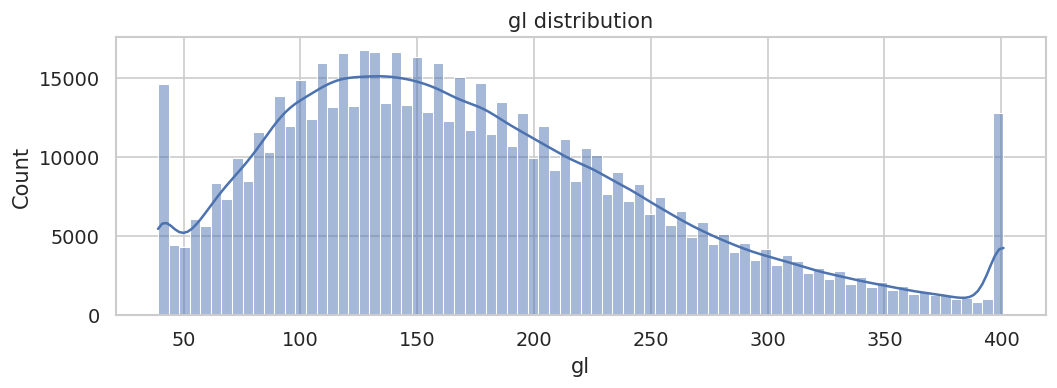

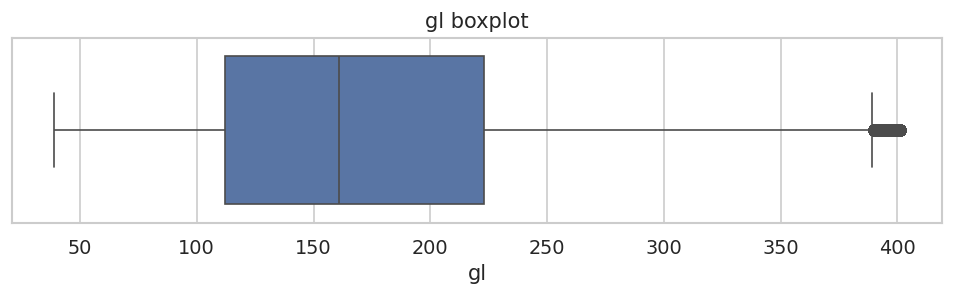


-- UnitsInsTotal --


count    647858.000000
mean         42.486262
std          28.275020
min           0.000000
1%            0.000000
5%            0.000000
25%          26.000000
50%          38.000000
75%          52.000000
95%         100.000000
99%         130.000000
max         220.000000
Name: UnitsInsTotal, dtype: float64

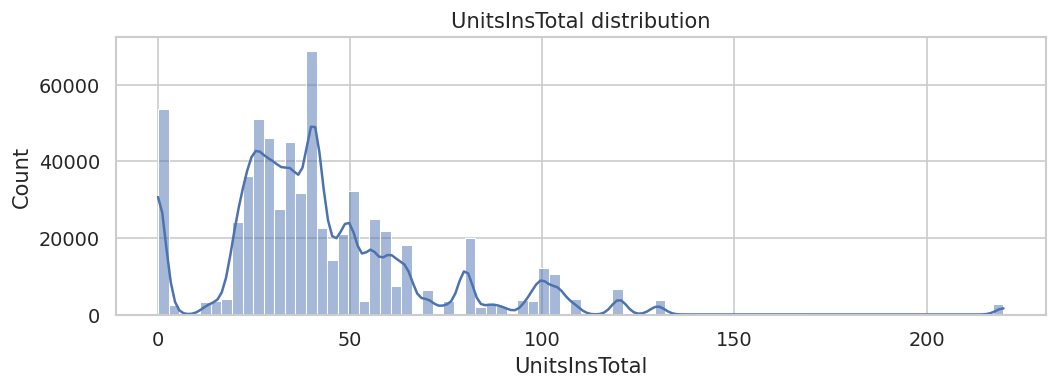

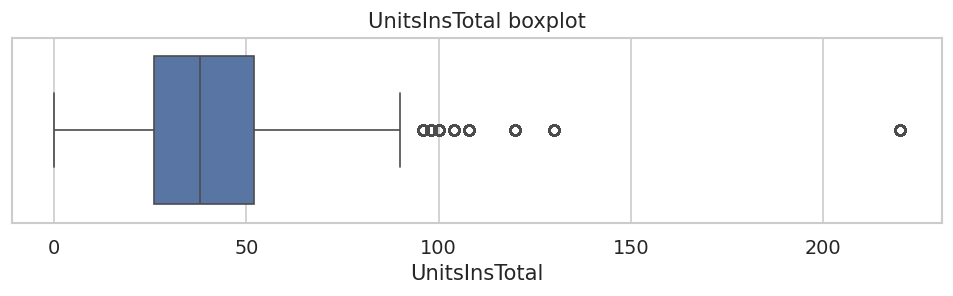

In [ ]:
# distribution and summary for gl and UnitsInsTotal
for col in ['gl','UnitsInsTotal']:
 if col in df.columns:
  print('\n--', col, '--')
  display(df[col].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)
  plt.figure(figsize=(10,3))
  sns.histplot(df[col].dropna(), bins=80, kde=True)
  plt.title(f'{col} distribution')
  plt.show()


  plt.figure(figsize=(10,2))
  sns.boxplot(x=df[col].dropna())
  plt.title(f'{col} boxplot')
  plt.show()

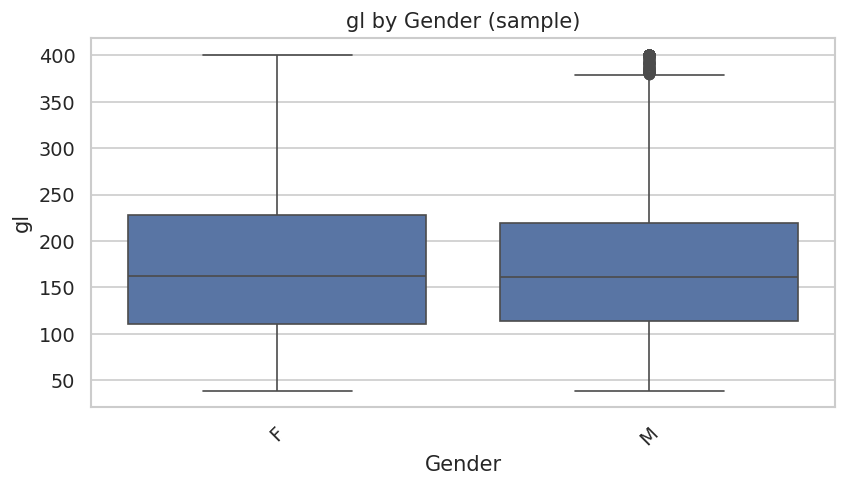

count        mean  median        std
Gender                                       
M       348387  173.156277   161.0  79.664634
F       299471  174.686410   161.0  85.761882

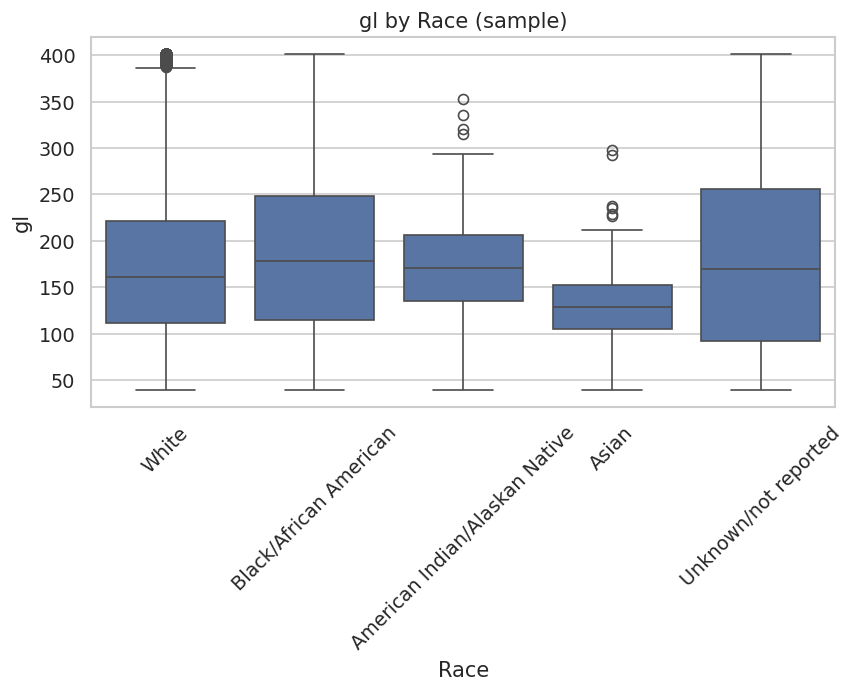

count        mean  median         std
Race                                                                  
White                           621246  173.872703   161.0   82.270537
Black/African American           18148  182.745426   172.0   93.707233
Asian                             3723  130.209777   127.0   42.776286
American Indian/Alaskan Native    2800  174.658571   167.0   72.521689
Unknown/not reported              1941  170.484286   154.0  100.853984

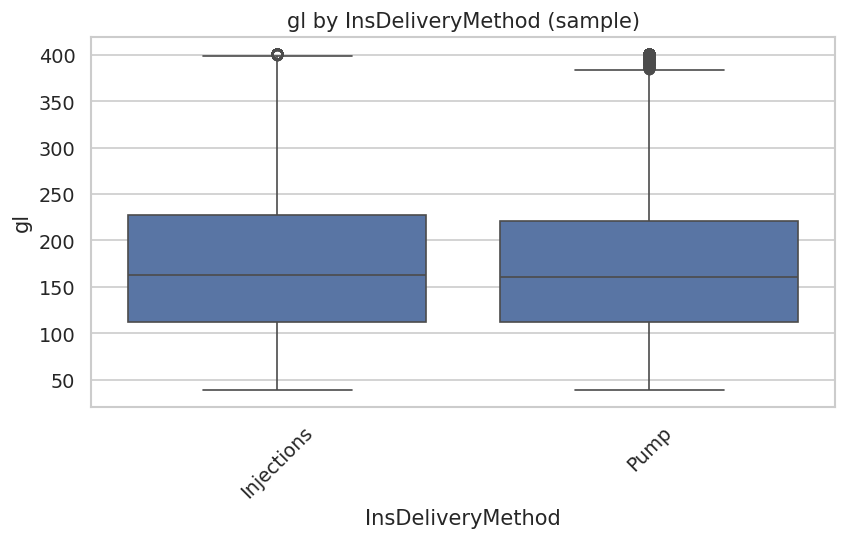

count        mean  median        std
InsDeliveryMethod                                       
Pump               390943  173.048892   161.0  81.464488
Injections         256915  175.103272   162.0  84.141515

In [ ]:
# bivariate summaries
if 'gl' in df.columns:
 for cat in ['Gender','Race','InsDeliveryMethod']:
  if cat in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=cat, y='gl', data=df.sample(min(20000,len(df))))
    plt.title(f'gl by {cat} (sample)')
    plt.xticks(rotation=45)
    plt.show()


    # group stats (mean, median, std)
    g = df.groupby(cat)['gl'].agg(['count','mean','median','std']).sort_values('count', ascending=False)
    display(g)

gl                                    1.000000
Diabetic_peripheral_neuropathy        0.089138
Erectile_dysfunction                  0.073218
Hyperlipidemia                        0.058526
Lisinopril                            0.046447
Hypertension                          0.042644
Omeprazole                            0.040132
DaysMonBingeAlc                       0.039477
Proliferative_diabetic_retinopathy    0.034996
T1DDiagAge                            0.029312
Depression                            0.029026
Aspirin                               0.028667
Type_I_diabetes_mellitus              0.028189
Weight                                0.026471
vitamin_D3                            0.024311
Osteoporosis                          0.020173
AnnualInc                             0.019826
atorvastatin                          0.019191
Synthroid                             0.018833
id                                    0.017378
Coronary_artery_disease               0.013709
Hypothyroidism                        0.012137
Vitamin_D                             0.010012
Multivitamin_preparation              0.000311
Height                               -0.004092
NumHospDKA                           -0.004497
DaysWkEx                             -0.005413
NumSHSinceT1DDiag                    -0.005437
UnitsInsTotal                        -0.005607
DaysWkDrinkAlc                       -0.010716
EduLevel                             -0.019579
Dyslipidemia                         -0.028138
Hypercholesterolemia                 -0.029409
Simvastatin                          -0.040063
Chronic_kidney_disease               -0.051050
NumMeterCheckDay                     -0.107374
Name: gl, dtype: float64

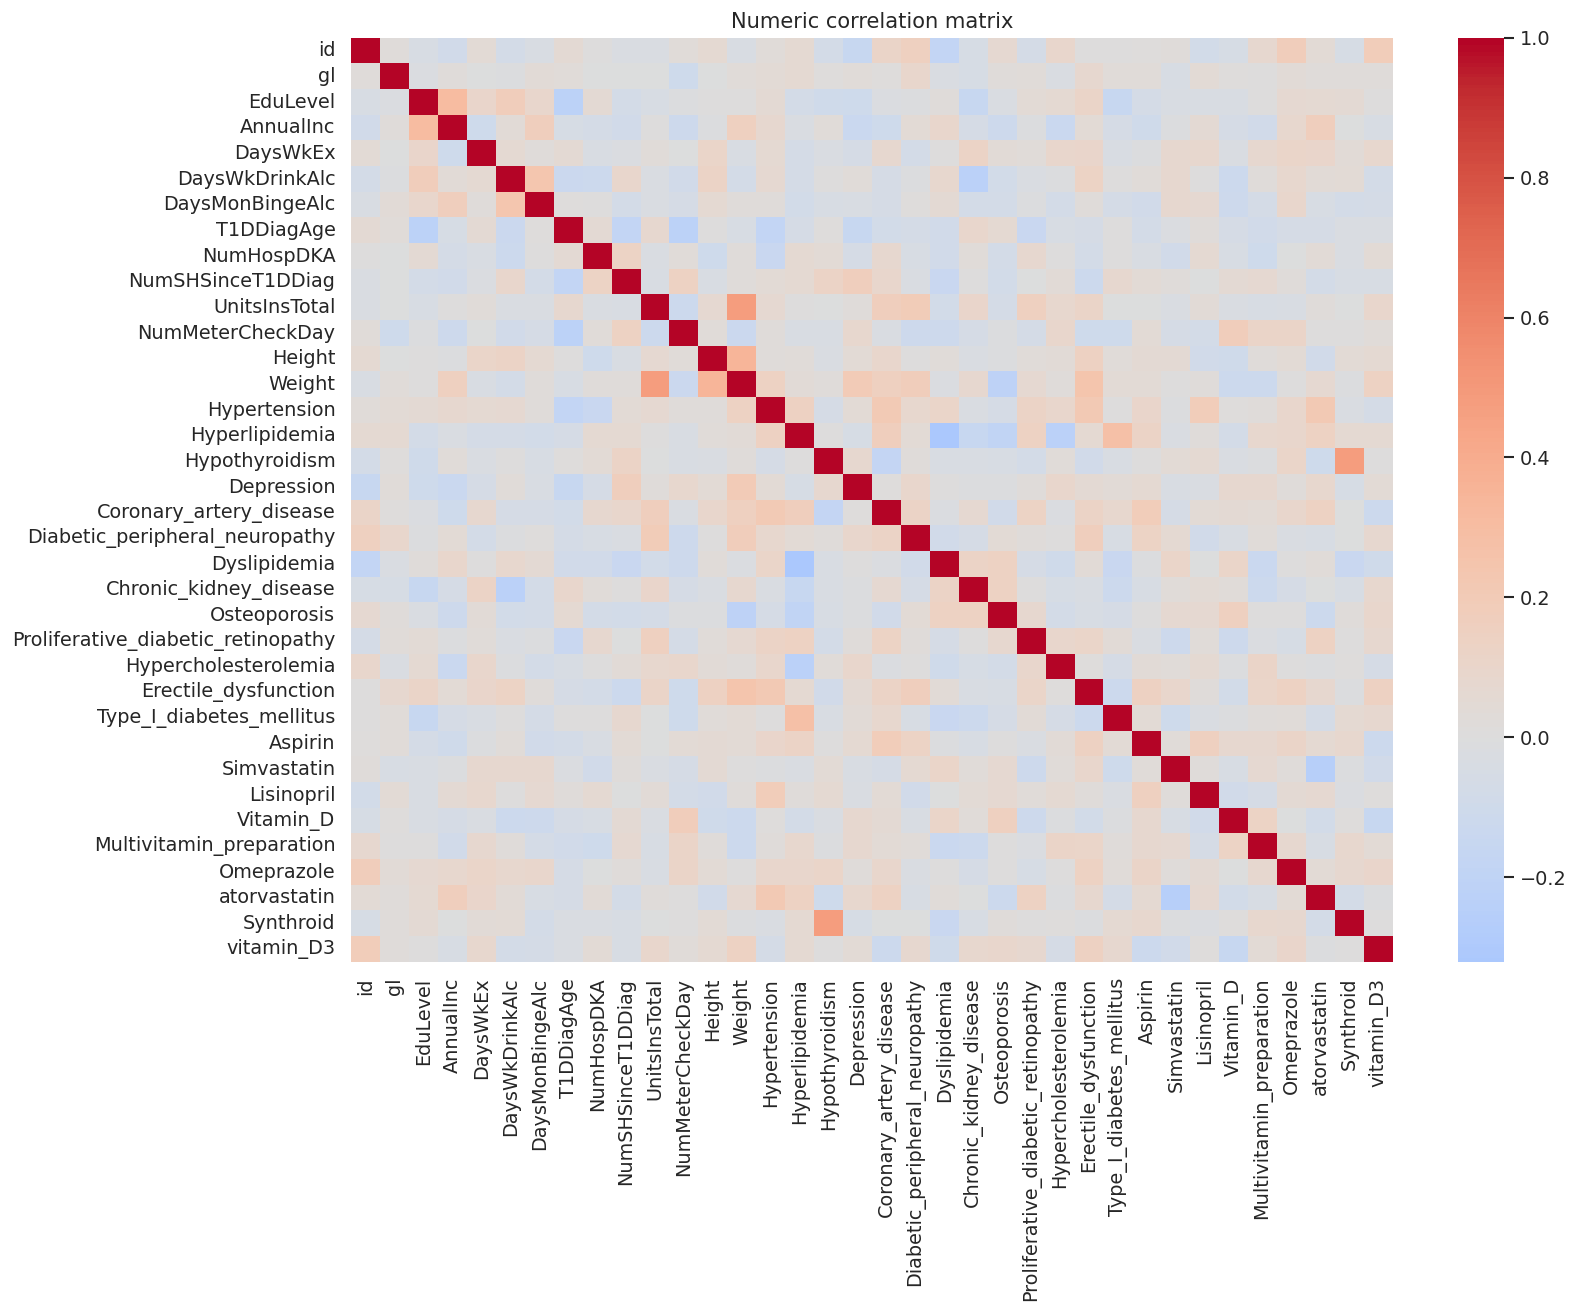

In [ ]:
# correlation matrix for numeric columns
num = df.select_dtypes(include=[np.number]).columns.tolist()
if 'gl' in num:
  corr_with_gl = df[num].corr()['gl'].sort_values(ascending=False)
  display(corr_with_gl)


  plt.figure(figsize=(14,10))
  sns.heatmap(df[num].corr(), cmap='coolwarm', center=0)
  plt.title('Numeric correlation matrix')
  plt.show()

count         mean         std         min          25%          50%  \
id      200.0   101.015000   58.511991    1.000000    50.750000   100.500000   
count   200.0  3239.290000  740.858633  432.000000  2945.000000  3429.000000   
mean    200.0   175.321868   32.944713  105.182527   150.648754   172.202236   
std     200.0    74.975553   15.734880   30.181623    62.815204    75.405149   
min     200.0    41.135000    7.565910   39.000000    39.000000    39.000000   
max     200.0   387.290000   28.406700  227.000000   388.500000   401.000000   
median  200.0   166.545000   35.535466   99.000000   140.000000   161.500000   
cv      200.0     0.431455    0.071076    0.272154     0.381119     0.433320   

                75%          max  
id       151.250000   203.000000  
count   3747.500000  5146.000000  
mean     199.858215   265.378128  
std       83.816229   119.280929  
min       39.000000   105.000000  
max      401.000000   401.000000  
median   191.000000   287.000000  
cv         0.481236     0.600381

id  count        mean         std   min    max  median        cv
9     10   5146  153.328605   76.522326  39.0  401.0   147.0  0.499074
96    97   4708  147.631054   54.061065  44.0  401.0   140.0  0.366190
23    24   4589  155.434953   72.284556  39.0  401.0   144.0  0.465047
81    82   4167  167.557955   81.612352  39.0  401.0   162.0  0.487069
111  112   4167  148.442765   47.009391  39.0  363.0   148.0  0.316684
60    61   4085  220.622032  114.469271  39.0  401.0   216.0  0.518848
165  167   3988  160.641675   89.724242  39.0  401.0   138.0  0.558537
71    72   3960  135.099747   63.672417  39.0  401.0   124.0  0.471299
84    85   3928  197.714613  102.576504  39.0  401.0   191.0  0.518811
19    20   3925  150.680764   75.040793  39.0  401.0   139.0  0.498012

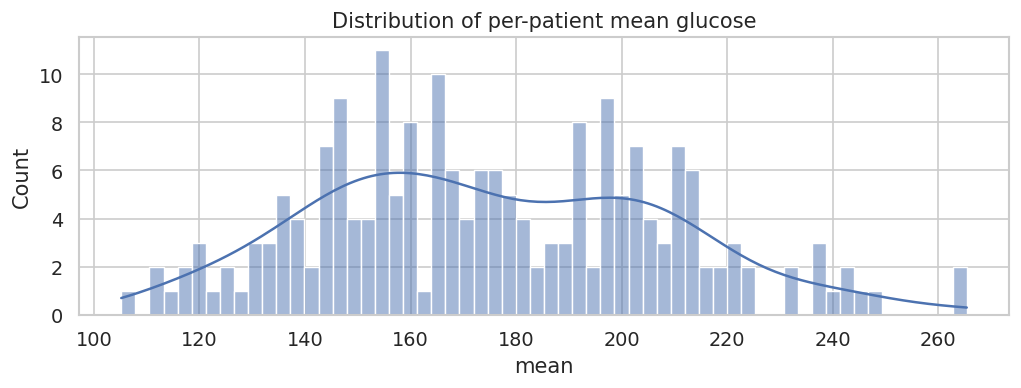

In [ ]:
# group by id to compute per-patient stats
if 'id' in df.columns and 'gl' in df.columns:
  per_patient = df.groupby('id')['gl'].agg(['count','mean','std','min','max','median']).reset_index()
  per_patient['cv'] = per_patient['std']/per_patient['mean']
  display(per_patient.describe().T)


  # patients with most readings
  display(per_patient.sort_values('count', ascending=False).head(10))


  # histogram of per-patient mean
  plt.figure(figsize=(10,3))
  sns.histplot(per_patient['mean'].dropna(), bins=60, kde=True)
  plt.title('Distribution of per-patient mean glucose')
  plt.show()

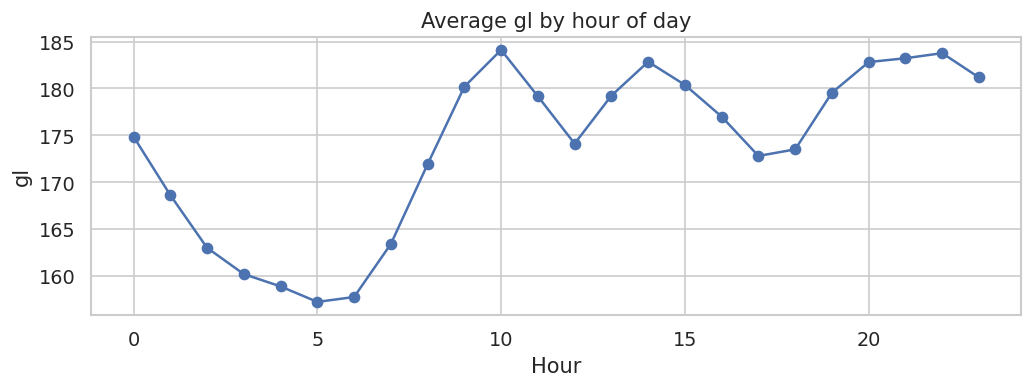

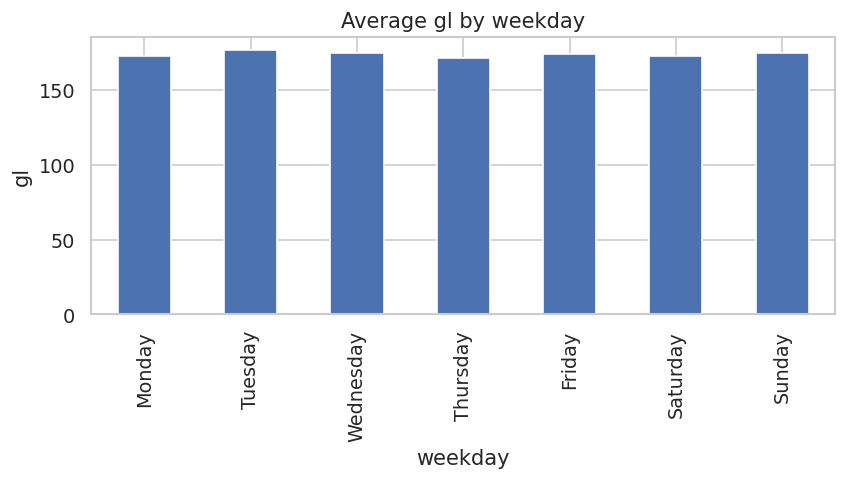

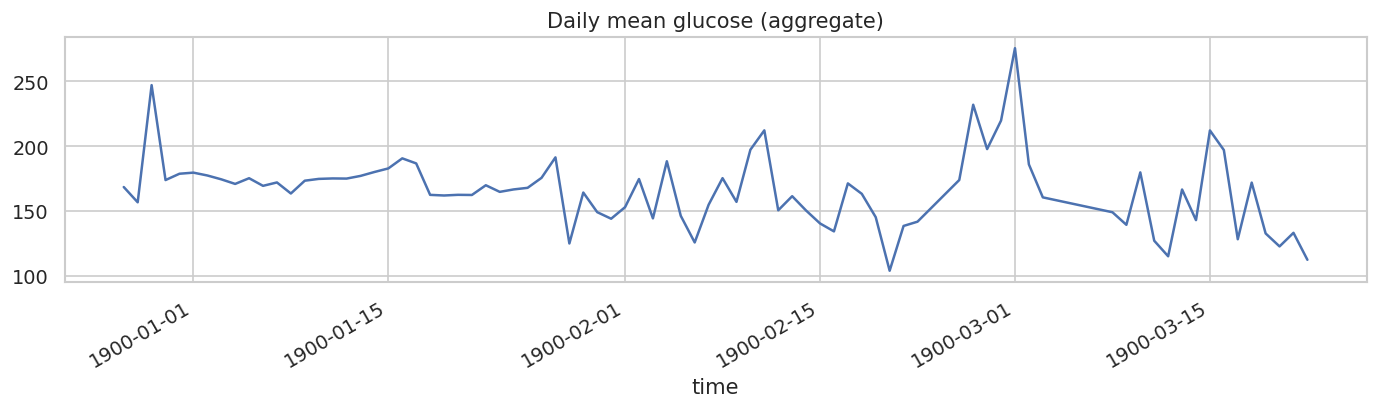

In [ ]:
#time features and diurnal patterns
if 'time' in df.columns:
    df['hour'] = df['time'].dt.hour
    df['weekday'] = df['time'].dt.day_name()


    # hourly mean glucose
    hourly = df.groupby('hour')['gl'].mean()
    plt.figure(figsize=(10,3))
    hourly.plot(marker='o')
    plt.title('Average gl by hour of day')
    plt.xlabel('Hour')
    plt.ylabel('gl')
    plt.show()


    # weekday mean
    wk = df.groupby('weekday')['gl'].mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.figure(figsize=(8,3))
    wk.plot(kind='bar')
    plt.title('Average gl by weekday')
    plt.ylabel('gl')
    plt.show()


    # daily aggregate (resample) — may be large; use sample for plotting
    daily = df.set_index('time').resample('D')['gl'].mean().dropna()
    if len(daily) > 2:
      plt.figure(figsize=(14,3))
      daily.plot()
      plt.title('Daily mean glucose (aggregate)')
      plt.show()

In [ ]:
# Rolling metrics (example: 1h, 4h windows) — careful with large data
if 'time' in df.columns:
  df = df.sort_values(['id','time'])
  # compute per-patient rolling mean with small sample function
  def compute_rolling(group, col='gl'):
    group['roll_1h'] = group[col].rolling(window=6, min_periods=1).mean() # assuming 10-min or 5-min freq adjust window
    group['roll_4h'] = group[col].rolling(window=24, min_periods=1).mean()
    group['gl_diff'] = group[col].diff()
    return group


# apply to a small sample for speed
sample_ids = df['id'].unique()[:10]
sample = df[df['id'].isin(sample_ids)].groupby('id').apply(compute_rolling)
display(sample.head())

id     gl                time Gender   Race  EduLevel  AnnualInc  \
id                                                                            
1  414668   1  223.0 1900-01-01 18:35:14      F  White         7          5   
   414669   1  221.0 1900-01-01 18:40:14      F  White         7          5   
   414670   1  233.0 1900-01-01 18:45:14      F  White         7          5   
   414671   1  223.0 1900-01-01 18:50:14      F  White         7          5   
   414672   1  214.0 1900-01-01 18:55:14      F  White         7          5   

          MaritalStatus  DaysWkEx  DaysWkDrinkAlc  ...  \
id                                                 ...   
1  414668       Married       4.0             4.0  ...   
   414669       Married       4.0             4.0  ...   
   414670       Married       4.0             4.0  ...   
   414671       Married       4.0             4.0  ...   
   414672       Married       4.0             4.0  ...   

           Multivitamin_preparation  Omeprazole  atorvastatin  Synthroid  \
id                                                                         
1  414668                       0.0         0.0           0.0        0.0   
   414669                       0.0         0.0           0.0        0.0   
   414670                       0.0         0.0           0.0        0.0   
   414671                       0.0         0.0           0.0        0.0   
   414672                       0.0         0.0           0.0        0.0   

          vitamin_D3  hour  weekday     roll_1h     roll_4h  gl_diff  
id                                                                    
1  414668        0.0    18   Monday  223.000000  223.000000      NaN  
   414669        0.0    18   Monday  222.000000  222.000000     -2.0  
   414670        0.0    18   Monday  225.666667  225.666667     12.0  
   414671        0.0    18   Monday  225.000000  225.000000    -10.0  
   414672        0.0    18   Monday  222.800000  222.800000     -9.0  

[5 rows x 46 columns]

In [ ]:
# Cell 15: VIF computation
from statsmodels.stats.outliers_influence import variance_inflation_factor
num = df.select_dtypes(include=[np.number]).columns.tolist()
# exclude target
num = [c for c in num if c!='gl']


# sample for VIF stability
X = df[num].dropna().sample(min(20000, df.shape[0]), random_state=42)
X = X.loc[:, X.std()>0]


vif = pd.DataFrame({'feature': X.columns, 'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})
display(vif.sort_values('VIF', ascending=False).head(30))

feature        VIF
11                          Height  50.972248
12                          Weight  43.779441
1                         EduLevel  16.673030
3                         DaysWkEx   8.011724
10                NumMeterCheckDay   7.113785
6                       T1DDiagAge   6.526951
2                        AnnualInc   5.311472
0                               id   4.971938
9                    UnitsInsTotal   4.861964
8                NumSHSinceT1DDiag   4.342946
35                            hour   3.775197
13                    Hypertension   3.686582
14                  Hyperlipidemia   2.458543
26                         Aspirin   2.283058
4                   DaysWkDrinkAlc   2.245737
15                  Hypothyroidism   2.167988
27                     Simvastatin   1.733758
33                       Synthroid   1.687000
19                    Dyslipidemia   1.685285
17         Coronary_artery_disease   1.683469
28                      Lisinopril   1.615873
29                       Vitamin_D   1.603844
16                      Depression   1.602531
32                    atorvastatin   1.576511
24            Erectile_dysfunction   1.524363
23            Hypercholesterolemia   1.471817
21                    Osteoporosis   1.470488
30        Multivitamin_preparation   1.470338
18  Diabetic_peripheral_neuropathy   1.465930
34                      vitamin_D3   1.425877

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def comprehensive_eda(df, target_col='UnitsInsTotal', time_col='time', save_report=False):
    """
    Comprehensive EDA function with professional structured output.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Target variable for analysis
    time_col : str
        Timestamp column name
    save_report : bool
        Whether to save report to file

    Returns
    -------
    results : dict
        Complete EDA results dictionary
    """

    def print_header(text, level=1):
        """Print formatted headers"""
        chars = ['═', '─', '·']
        widths = [80, 70, 60]

        char = chars[min(level-1, 2)]
        width = widths[min(level-1, 2)]

        print(f"\n{char * width}")
        print(f" {text.upper()}" if level == 1 else f"  {text}")
        print(f"{char * width}")

    def print_metric(label, value, unit=''):
        """Print formatted metric"""
        print(f"  • {label:.<50} {value:>15} {unit}")

    results = {}

    # ═══════════════════════════════════════════════════════════════════════════
    # 1. DATASET OVERVIEW
    # ═══════════════════════════════════════════════════════════════════════════
    print_header("📊 DATASET OVERVIEW", 1)

    n_rows, n_cols = df.shape
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2
    n_duplicates = df.duplicated().sum()
    n_numeric = df.select_dtypes(include=[np.number]).shape[1]
    n_categorical = df.select_dtypes(include=['object', 'category']).shape[1]

    print_metric("Total Records", f"{n_rows:,}")
    print_metric("Total Features", f"{n_cols:,}")
    print_metric("Numeric Features", f"{n_numeric:,}")
    print_metric("Categorical Features", f"{n_categorical:,}")
    print_metric("Memory Usage", f"{memory_mb:.2f}", "MB")
    print_metric("Duplicate Rows", f"{n_duplicates:,}")
    print_metric("Completeness", f"{(1 - df.isnull().sum().sum()/(n_rows*n_cols))*100:.2f}", "%")

    results['overview'] = {
        'n_rows': n_rows,
        'n_cols': n_cols,
        'n_numeric': n_numeric,
        'n_categorical': n_categorical,
        'memory_mb': round(memory_mb, 2),
        'duplicates': int(n_duplicates),
        'completeness_pct': round((1 - df.isnull().sum().sum()/(n_rows*n_cols))*100, 2)
    }

    # ═══════════════════════════════════════════════════════════════════════════
    # 2. DATA QUALITY ASSESSMENT
    # ═══════════════════════════════════════════════════════════════════════════
    print_header("🔍 DATA QUALITY ASSESSMENT", 1)

    quality_df = pd.DataFrame({
        'Feature': df.columns,
        'Type': df.dtypes.astype(str),
        'Missing': df.isnull().sum(),
        'Missing_%': (df.isnull().sum() / len(df) * 100).round(2),
        'Unique': [df[col].nunique() for col in df.columns],
        'Cardinality_%': [(df[col].nunique() / len(df) * 100) for col in df.columns]
    })

    quality_df = quality_df.sort_values('Missing_%', ascending=False)

    print("\n  Missing Values Summary:")
    if quality_df['Missing'].sum() == 0:
        print("    ✓ No missing values detected!")
    else:
        print(quality_df[quality_df['Missing'] > 0].to_string(index=False))

    # Check for constant features
    constant_features = [col for col in df.columns if df[col].nunique() == 1]
    if constant_features:
        print(f"\n  ⚠ Constant Features (Remove): {len(constant_features)}")
        for feat in constant_features:
            print(f"    - {feat}")

    # Check for high cardinality
    high_card = quality_df[quality_df['Cardinality_%'] > 95]
    if len(high_card) > 0:
        print(f"\n  ⚠ High Cardinality Features: {len(high_card)}")
        for _, row in high_card.iterrows():
            print(f"    - {row['Feature']}: {row['Unique']} unique values")

    results['data_quality'] = quality_df.to_dict('records')

    # ═══════════════════════════════════════════════════════════════════════════
    # 3. NUMERIC FEATURES ANALYSIS
    # ═══════════════════════════════════════════════════════════════════════════
    print_header("📈 NUMERIC FEATURES ANALYSIS", 1)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(numeric_cols) > 0:
        numeric_stats = df[numeric_cols].describe(
            percentiles=[.01, .05, .10, .25, .50, .75, .90, .95, .99]
        ).T

        # Add additional statistics
        numeric_stats['skewness'] = df[numeric_cols].skew()
        numeric_stats['kurtosis'] = df[numeric_cols].kurtosis()
        numeric_stats['zeros_%'] = (df[numeric_cols] == 0).sum() / len(df) * 100
        numeric_stats['cv'] = numeric_stats['std'] / numeric_stats['mean']

        print("\n  Summary Statistics:")
        print(numeric_stats.round(2).to_string())

        # Distribution analysis
        print_header("Distribution Characteristics", 2)

        for col in numeric_cols[:10]:  # Limit to first 10 for readability
            skew = df[col].skew()
            kurt = df[col].kurtosis()

            if abs(skew) < 0.5:
                skew_type = "Symmetric"
            elif skew > 0:
                skew_type = "Right-skewed"
            else:
                skew_type = "Left-skewed"

            print(f"\n  {col}:")
            print(f"    Range: [{df[col].min():.2f}, {df[col].max():.2f}]")
            print(f"    Distribution: {skew_type} (skew={skew:.2f}, kurt={kurt:.2f})")
            print(f"    Zeros: {(df[col]==0).sum():,} ({(df[col]==0).sum()/len(df)*100:.1f}%)")

        results['numeric_analysis'] = numeric_stats.round(3).to_dict()

    # ═══════════════════════════════════════════════════════════════════════════
    # 4. CATEGORICAL FEATURES ANALYSIS
    # ═══════════════════════════════════════════════════════════════════════════
    print_header("📊 CATEGORICAL FEATURES ANALYSIS", 1)

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    if len(categorical_cols) > 0:
        cat_summary = []

        for col in categorical_cols:
            n_unique = df[col].nunique()
            top_value = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else None
            top_freq = (df[col] == top_value).sum() if top_value else 0
            top_pct = (top_freq / len(df) * 100) if top_value else 0

            cat_summary.append({
                'Feature': col,
                'Unique': n_unique,
                'Top_Value': top_value,
                'Top_Freq': top_freq,
                'Top_%': round(top_pct, 1),
                'Entropy': round(stats.entropy(df[col].value_counts(normalize=True)), 2)
            })

        cat_df = pd.DataFrame(cat_summary)
        print("\n  Category Summary:")
        print(cat_df.to_string(index=False))

        # Detailed breakdown for each categorical variable
        print_header("Value Distributions", 2)
        for col in categorical_cols:
            print(f"\n  {col}:")
            value_counts = df[col].value_counts()
            for val, count in value_counts.head(5).items():
                print(f"    • {val}: {count:,} ({count/len(df)*100:.1f}%)")
            if len(value_counts) > 5:
                print(f"    • ... and {len(value_counts)-5} more categories")

        results['categorical_analysis'] = cat_df.to_dict('records')

    # ═══════════════════════════════════════════════════════════════════════════
    # 5. TARGET VARIABLE DEEP DIVE
    # ═══════════════════════════════════════════════════════════════════════════
    if target_col in df.columns:
        print_header(f"🎯 TARGET VARIABLE: {target_col}", 1)

        if df[target_col].dtype in [np.number]:
            target_stats = df[target_col].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99])

            print("\n  Distribution Statistics:")
            for stat, value in target_stats.items():
                print_metric(stat.capitalize(), f"{value:.2f}")

            # Outlier detection
            Q1 = df[target_col].quantile(0.25)
            Q3 = df[target_col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers_lower = (df[target_col] < lower_bound).sum()
            outliers_upper = (df[target_col] > upper_bound).sum()
            outliers_total = outliers_lower + outliers_upper

            print("\n  Outlier Analysis (IQR Method):")
            print_metric("Lower Outliers", f"{outliers_lower:,}", f"({outliers_lower/len(df)*100:.1f}%)")
            print_metric("Upper Outliers", f"{outliers_upper:,}", f"({outliers_upper/len(df)*100:.1f}%)")
            print_metric("Total Outliers", f"{outliers_total:,}", f"({outliers_total/len(df)*100:.1f}%)")

            print("\n  Shape Metrics:")
            print_metric("Skewness", f"{df[target_col].skew():.3f}")
            print_metric("Kurtosis", f"{df[target_col].kurtosis():.3f}")
            print_metric("Coefficient of Variation", f"{df[target_col].std()/df[target_col].mean():.3f}")

            results['target_analysis'] = {
                'statistics': target_stats.to_dict(),
                'outliers': {
                    'lower': int(outliers_lower),
                    'upper': int(outliers_upper),
                    'total': int(outliers_total),
                    'percentage': round(outliers_total/len(df)*100, 2)
                },
                'shape': {
                    'skewness': round(df[target_col].skew(), 3),
                    'kurtosis': round(df[target_col].kurtosis(), 3)
                }
            }

    # ═══════════════════════════════════════════════════════════════════════════
    # 6. CORRELATION ANALYSIS
    # ═══════════════════════════════════════════════════════════════════════════
    if len(numeric_cols) > 1:
        print_header("🔗 CORRELATION ANALYSIS", 1)

        corr_matrix = df[numeric_cols].corr()

        if target_col in numeric_cols:
            target_corr = corr_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False)

            print("\n  Top 15 Correlations with Target:")
            for i, (feature, corr_val) in enumerate(target_corr.head(15).items(), 1):
                strength = "Strong" if abs(corr_val) > 0.5 else "Moderate" if abs(corr_val) > 0.3 else "Weak"
                direction = "+" if corr_val > 0 else "-"
                print(f"    {i:2d}. {feature:.<45} {direction}{abs(corr_val):.3f} ({strength})")

            # Find multicollinearity
            print_header("Multicollinearity Check", 2)
            high_corr_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.8:
                        high_corr_pairs.append({
                            'Feature_1': corr_matrix.columns[i],
                            'Feature_2': corr_matrix.columns[j],
                            'Correlation': round(corr_matrix.iloc[i, j], 3)
                        })

            if high_corr_pairs:
                print(f"\n  ⚠ Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.8):")
                for pair in high_corr_pairs[:10]:
                    print(f"    • {pair['Feature_1']} ↔ {pair['Feature_2']}: {pair['Correlation']:.3f}")
            else:
                print("\n  ✓ No severe multicollinearity detected")

            results['correlation'] = {
                'target_correlations': target_corr.to_dict(),
                'high_corr_pairs': high_corr_pairs
            }

    # ═══════════════════════════════════════════════════════════════════════════
    # 7. TIME SERIES ANALYSIS
    # ═══════════════════════════════════════════════════════════════════════════
    if time_col in df.columns:
        print_header("📅 TIME SERIES ANALYSIS", 1)

        try:
            if df[time_col].dtype == 'object':
                df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

            time_min = df[time_col].min()
            time_max = df[time_col].max()
            time_span = (time_max - time_min).days

            print("\n  Temporal Coverage:")
            print_metric("Start Date", str(time_min))
            print_metric("End Date", str(time_max))
            print_metric("Time Span", f"{time_span}", "days")
            print_metric("Avg Records/Day", f"{len(df)/time_span:.1f}")

            # Extract temporal features if not already present
            if 'hour' not in df.columns and hasattr(df[time_col].dt, 'hour'):
                df['_hour'] = df[time_col].dt.hour
                hourly_dist = df['_hour'].value_counts().sort_index()

                print("\n  Hourly Distribution:")
                print(f"    Peak Hour: {hourly_dist.idxmax()}:00 ({hourly_dist.max():,} records)")
                print(f"    Low Hour: {hourly_dist.idxmin()}:00 ({hourly_dist.min():,} records)")

            results['time_analysis'] = {
                'start_date': str(time_min),
                'end_date': str(time_max),
                'span_days': time_span,
                'records_per_day': round(len(df)/time_span, 1)
            }

        except Exception as e:
            print(f"  ⚠ Time analysis error: {e}")

    # ═══════════════════════════════════════════════════════════════════════════
    # 8. DATA QUALITY ISSUES & RECOMMENDATIONS
    # ═══════════════════════════════════════════════════════════════════════════
    print_header("⚠️  DATA QUALITY ISSUES & RECOMMENDATIONS", 1)

    issues = []
    recommendations = []

    # Check for high zero percentages
    for col in numeric_cols:
        zero_pct = (df[col] == 0).sum() / len(df) * 100
        if 10 < zero_pct < 95:
            issues.append(f"{col}: {zero_pct:.1f}% zeros")
            recommendations.append(f"Consider binary encoding or special handling for {col}")

    # Check for skewed distributions
    for col in numeric_cols:
        if abs(df[col].skew()) > 2:
            issues.append(f"{col}: Highly skewed (skew={df[col].skew():.2f})")
            recommendations.append(f"Consider log transformation for {col}")

    # Check for low variance
    for col in numeric_cols:
        if df[col].std() / (df[col].mean() + 1e-10) < 0.01:
            issues.append(f"{col}: Very low variance")
            recommendations.append(f"Consider removing {col} (low information)")

    if issues:
        print("\n  Issues Detected:")
        for i, issue in enumerate(issues[:15], 1):
            print(f"    {i}. {issue}")
    else:
        print("\n  ✓ No major issues detected")

    if recommendations:
        print("\n  Recommendations:")
        for i, rec in enumerate(set(recommendations[:10]), 1):
            print(f"    {i}. {rec}")

    results['quality_issues'] = issues
    results['recommendations'] = recommendations

    # ═══════════════════════════════════════════════════════════════════════════
    # SUMMARY
    # ═══════════════════════════════════════════════════════════════════════════
    print_header("EDA COMPLETE", 1)
    print(f"\n  📊 Analyzed {n_rows:,} records across {n_cols} features")
    print(f"  🎯 Target variable: {target_col}")
    print(f"  ⚠️  {len(issues)} potential issues identified")
    print(f"  💡 {len(set(recommendations))} recommendations generated")
    print("\n" + "═" * 80 + "\n")

    return results

# ==============
results = comprehensive_eda(df, target_col='UnitsInsTotal', time_col='time')
print(results.keys())


════════════════════════════════════════════════════════════════════════════════
 📊 DATASET OVERVIEW
════════════════════════════════════════════════════════════════════════════════
  • Total Records.....................................         647,858 
  • Total Features....................................              43 
  • Numeric Features..................................              37 
  • Categorical Features..............................               5 
  • Memory Usage......................................          359.11 MB
  • Duplicate Rows....................................               0 
  • Completeness......................................          100.00 %

════════════════════════════════════════════════════════════════════════════════
 🔍 DATA QUALITY ASSESSMENT
════════════════════════════════════════════════════════════════════════════════

  Missing Values Summary:
    ✓ No missing values detected!

══════════════════════════════════════════════════════════

## **Data Visualization**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def comprehensive_eda_plots(df, target_col='UnitsInsTotal'):
    """
    Create comprehensive visualization suite for diabetes dataset

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    target_col : str
        Target variable name
    """

    # ============================================================================
    # IDENTIFY KEY COLUMN GROUPS
    # ============================================================================
    all_cols = df.columns.tolist()

    # Find comorbidity columns
    comorbidities = []
    comorbidity_keywords = ['hypertension', 'hyperlipidemia', 'hypothyroidism', 'depression',
                           'coronary', 'neuropathy', 'dyslipidemia', 'kidney', 'osteoporosis',
                           'retinopathy', 'hypercholesterolemia', 'erectile']

    for col in all_cols:
        col_lower = col.lower().replace('_', ' ')
        if any(keyword in col_lower for keyword in comorbidity_keywords):
            if df[col].dtype in [np.number] and df[col].max() <= 1:  # Binary columns
                comorbidities.append(col)

    # Find medication columns
    medications = []
    medication_keywords = ['aspirin', 'simvastatin', 'lisinopril', 'vitamin',
                          'multivitamin', 'omeprazole', 'atorvastatin', 'synthroid']

    for col in all_cols:
        col_lower = col.lower().replace('_', ' ')
        if any(keyword in col_lower for keyword in medication_keywords):
            if df[col].dtype in [np.number] and df[col].max() <= 1:  # Binary columns
                medications.append(col)

    # Find complication columns
    complications = []
    complication_keywords = ['neuropathy', 'retinopathy', 'kidney', 'coronary']
    for keyword in complication_keywords:
        matching_cols = [col for col in all_cols if keyword.lower() in col.lower().replace('_', ' ')]
        complications.extend(matching_cols)
    complications = list(set(complications))  # Remove duplicates

    # ============================================================================
    # FIGURE 1: DATASET OVERVIEW DASHBOARD (4x3 grid)
    # ============================================================================
    fig1 = plt.figure(figsize=(20, 16))
    fig1.suptitle('📊 DATASET OVERVIEW DASHBOARD', fontsize=20, fontweight='bold', y=0.995)

    # 1.1 Target Distribution
    ax1 = plt.subplot(4, 3, 1)
    df[target_col].hist(bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(df[target_col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[target_col].mean():.1f}')
    ax1.axvline(df[target_col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[target_col].median():.1f}')
    ax1.set_xlabel('Total Insulin Units', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.set_title('Target: Insulin Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 1.2 Target Box Plot (outliers)
    ax2 = plt.subplot(4, 3, 2)
    box_data = ax2.boxplot(df[target_col], vert=True, patch_artist=True)
    box_data['boxes'][0].set_facecolor('lightblue')
    box_data['boxes'][0].set_alpha(0.7)
    ax2.set_ylabel('Insulin Units', fontsize=10)
    ax2.set_title('Insulin Distribution (Box Plot)', fontweight='bold')
    ax2.grid(alpha=0.3)

    # 1.3 Glucose Distribution
    ax3 = plt.subplot(4, 3, 3)
    df['gl'].hist(bins=60, edgecolor='black', alpha=0.7, color='orange')
    ax3.axvline(70, color='red', linestyle='--', linewidth=2, label='Hypo threshold (<70)')
    ax3.axvline(180, color='red', linestyle='--', linewidth=2, label='Hyper threshold (>180)')
    ax3.axvspan(70, 180, alpha=0.2, color='green', label='Target range')
    ax3.set_xlabel('Glucose Level (mg/dL)', fontsize=10)
    ax3.set_ylabel('Frequency', fontsize=10)
    ax3.set_title('Glucose Distribution', fontweight='bold')
    ax3.legend(fontsize=8)
    ax3.grid(alpha=0.3)

    # 1.4 Gender Distribution
    ax4 = plt.subplot(4, 3, 4)
    gender_counts = df['Gender'].value_counts()
    colors = ['#3498db', '#e74c3c']
    wedges, texts, autotexts = ax4.pie(gender_counts.values, labels=gender_counts.index,
                                         autopct='%1.1f%%', startangle=90, colors=colors)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax4.set_title('Gender Distribution', fontweight='bold')

    # 1.5 Race Distribution
    ax5 = plt.subplot(4, 3, 5)
    race_counts = df['Race'].value_counts()
    ax5.barh(race_counts.index, race_counts.values, color='teal', alpha=0.7)
    ax5.set_xlabel('Count', fontsize=10)
    ax5.set_title('Race Distribution', fontweight='bold')
    ax5.grid(alpha=0.3, axis='x')
    for i, v in enumerate(race_counts.values):
        ax5.text(v + 5000, i, f'{v:,}', va='center', fontsize=9)

    # 1.6 Marital Status
    ax6 = plt.subplot(4, 3, 6)
    marital_counts = df['MaritalStatus'].value_counts().head(5)
    ax6.bar(range(len(marital_counts)), marital_counts.values, color='purple', alpha=0.7)
    ax6.set_xticks(range(len(marital_counts)))
    ax6.set_xticklabels(marital_counts.index, rotation=45, ha='right', fontsize=9)
    ax6.set_ylabel('Count', fontsize=10)
    ax6.set_title('Top 5 Marital Status', fontweight='bold')
    ax6.grid(alpha=0.3, axis='y')

    # 1.7 Insulin Delivery Method
    ax7 = plt.subplot(4, 3, 7)
    method_counts = df['InsDeliveryMethod'].value_counts()
    colors = ['#2ecc71', '#f39c12']
    bars = ax7.bar(method_counts.index, method_counts.values, color=colors, alpha=0.7)
    ax7.set_ylabel('Count', fontsize=10)
    ax7.set_title('Insulin Delivery Method', fontweight='bold')
    ax7.grid(alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}\n({height/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 1.8 Age at T1D Diagnosis
    ax8 = plt.subplot(4, 3, 8)
    df['T1DDiagAge'].hist(bins=30, edgecolor='black', alpha=0.7, color='coral')
    ax8.axvline(df['T1DDiagAge'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df["T1DDiagAge"].mean():.1f} years')
    ax8.set_xlabel('Age at Diagnosis (years)', fontsize=10)
    ax8.set_ylabel('Frequency', fontsize=10)
    ax8.set_title('Type 1 Diabetes Diagnosis Age', fontweight='bold')
    ax8.legend()
    ax8.grid(alpha=0.3)

    # 1.9 Exercise Days per Week
    ax9 = plt.subplot(4, 3, 9)
    exercise_counts = df['DaysWkEx'].value_counts().sort_index()
    ax9.bar(exercise_counts.index, exercise_counts.values, color='green', alpha=0.7)
    ax9.set_xlabel('Days per Week', fontsize=10)
    ax9.set_ylabel('Count', fontsize=10)
    ax9.set_title('Exercise Frequency', fontweight='bold')
    ax9.grid(alpha=0.3, axis='y')

    # 1.10 Weight Distribution
    ax10 = plt.subplot(4, 3, 10)
    df[df['Weight'] > 0]['Weight'].hist(bins=40, edgecolor='black', alpha=0.7, color='brown')
    ax10.axvline(df[df['Weight'] > 0]['Weight'].mean(), color='red', linestyle='--', linewidth=2,
                 label=f'Mean: {df[df["Weight"] > 0]["Weight"].mean():.1f} lbs')
    ax10.set_xlabel('Weight (lbs)', fontsize=10)
    ax10.set_ylabel('Frequency', fontsize=10)
    ax10.set_title('Weight Distribution', fontweight='bold')
    ax10.legend()
    ax10.grid(alpha=0.3)

    # 1.11 Number of Daily Meter Checks
    ax11 = plt.subplot(4, 3, 11)
    meter_counts = df['NumMeterCheckDay'].value_counts().sort_index()
    ax11.bar(meter_counts.index, meter_counts.values, color='navy', alpha=0.7)
    ax11.set_xlabel('Daily Checks', fontsize=10)
    ax11.set_ylabel('Count', fontsize=10)
    ax11.set_title('Glucose Monitoring Frequency', fontweight='bold')
    ax11.grid(alpha=0.3, axis='y')

    # 1.12 Weekday Pattern
    ax12 = plt.subplot(4, 3, 12)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_counts = df['weekday'].value_counts().reindex(weekday_order)
    ax12.plot(weekday_counts.index, weekday_counts.values, marker='o', linewidth=2, markersize=8, color='purple')
    ax12.set_xticklabels(weekday_counts.index, rotation=45, ha='right', fontsize=9)
    ax12.set_ylabel('Count', fontsize=10)
    ax12.set_title('Records by Weekday', fontweight='bold')
    ax12.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('05_correlation_matrix.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 05_correlation_matrix.png")
    plt.show()

    # ============================================================================
    # FIGURE 6: BEHAVIORAL & LIFESTYLE FACTORS (2x3 grid)
    # ============================================================================
    fig6 = plt.figure(figsize=(18, 10))
    fig6.suptitle('🏃 BEHAVIORAL & LIFESTYLE FACTORS', fontsize=18, fontweight='bold', y=0.995)

    # 6.1 Exercise vs Insulin
    ax1 = plt.subplot(2, 3, 1)
    exercise_insulin = df.groupby('DaysWkEx')[target_col].agg(['mean', 'std', 'count'])
    ax1.bar(exercise_insulin.index, exercise_insulin['mean'],
            yerr=exercise_insulin['std']/np.sqrt(exercise_insulin['count']),
            color='green', alpha=0.7, capsize=5)
    ax1.set_xlabel('Exercise Days per Week', fontsize=10)
    ax1.set_ylabel('Average Insulin Units', fontsize=10)
    ax1.set_title('Exercise Frequency vs Insulin', fontweight='bold')
    ax1.grid(alpha=0.3, axis='y')

    # 6.2 Exercise vs Glucose
    ax2 = plt.subplot(2, 3, 2)
    exercise_glucose = df.groupby('DaysWkEx')['gl'].agg(['mean', 'std'])
    ax2.plot(exercise_glucose.index, exercise_glucose['mean'],
             marker='o', linewidth=2, markersize=8, color='green')
    ax2.fill_between(exercise_glucose.index,
                     exercise_glucose['mean'] - exercise_glucose['std']/10,
                     exercise_glucose['mean'] + exercise_glucose['std']/10,
                     alpha=0.3, color='green')
    ax2.axhline(df['gl'].mean(), color='red', linestyle='--', label='Overall Mean')
    ax2.set_xlabel('Exercise Days per Week', fontsize=10)
    ax2.set_ylabel('Average Glucose (mg/dL)', fontsize=10)
    ax2.set_title('Exercise vs Glucose Control', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 6.3 Alcohol Consumption Distribution
    ax3 = plt.subplot(2, 3, 3)
    alcohol_bins = [0, 1, 10, 20, 30]
    alcohol_labels = ['None', 'Minimal\n(1-10)', 'Moderate\n(11-20)', 'Frequent\n(21-30)']
    df_temp = df.copy()
    df_temp['alcohol_category'] = pd.cut(df['DaysWkDrinkAlc'], bins=alcohol_bins,
                                          labels=alcohol_labels, include_lowest=True)
    alcohol_counts = df_temp['alcohol_category'].value_counts().reindex(alcohol_labels)

    bars = ax3.bar(range(len(alcohol_counts)), alcohol_counts.values,
                   color=['green', 'yellow', 'orange', 'red'], alpha=0.7)
    ax3.set_xticks(range(len(alcohol_counts)))
    ax3.set_xticklabels(alcohol_counts.index, fontsize=9)
    ax3.set_ylabel('Count', fontsize=10)
    ax3.set_title('Alcohol Consumption Patterns', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    for bar, val in zip(bars, alcohol_counts.values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}\n({val/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)

    # 6.4 BMI Distribution (calculated)
    ax4 = plt.subplot(2, 3, 4)
    df_temp = df[(df['Weight'] > 0) & (df['Height'] > 0)].copy()
    df_temp['BMI'] = (df_temp['Weight'] / (df_temp['Height'] ** 2)) * 703

    # BMI categories
    bmi_bins = [0, 18.5, 25, 30, 35, 100]
    bmi_labels = ['Underweight\n(<18.5)', 'Normal\n(18.5-25)', 'Overweight\n(25-30)',
                  'Obese I\n(30-35)', 'Obese II+\n(>35)']
    df_temp['BMI_category'] = pd.cut(df_temp['BMI'], bins=bmi_bins, labels=bmi_labels)

    bmi_counts = df_temp['BMI_category'].value_counts().reindex(bmi_labels)
    colors_bmi = ['lightblue', 'lightgreen', 'yellow', 'orange', 'red']
    bars = ax4.bar(range(len(bmi_counts)), bmi_counts.values, color=colors_bmi, alpha=0.7)
    ax4.set_xticks(range(len(bmi_counts)))
    ax4.set_xticklabels(bmi_counts.index, fontsize=8)
    ax4.set_ylabel('Count', fontsize=10)
    ax4.set_title('BMI Distribution', fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

    for bar, val in zip(bars, bmi_counts.values):
        if pd.notna(val):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(val):,}\n({val/len(df_temp)*100:.1f}%)',
                    ha='center', va='bottom', fontsize=8)

    # 6.5 Insulin by BMI Category
    ax5 = plt.subplot(2, 3, 5)
    bmi_insulin = df_temp.groupby('BMI_category')[target_col].agg(['mean', 'std', 'count'])
    bp = ax5.boxplot([df_temp[df_temp['BMI_category']==cat][target_col].values
                      for cat in bmi_labels if cat in bmi_insulin.index],
                     labels=[cat for cat in bmi_labels if cat in bmi_insulin.index],
                     patch_artist=True, showmeans=True)
    for patch, color in zip(bp['boxes'], colors_bmi[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax5.set_xticklabels([cat for cat in bmi_labels if cat in bmi_insulin.index],
                        fontsize=8, rotation=15, ha='right')
    ax5.set_ylabel('Insulin Units', fontsize=10)
    ax5.set_title('Insulin Requirements by BMI', fontweight='bold')
    ax5.grid(alpha=0.3, axis='y')

    # 6.6 Education vs Insulin
    ax6 = plt.subplot(2, 3, 6)
    edu_insulin = df.groupby('EduLevel')[target_col].mean()
    ax6.plot(edu_insulin.index, edu_insulin.values, marker='o',
             linewidth=2, markersize=8, color='purple')
    ax6.set_xlabel('Education Level', fontsize=10)
    ax6.set_ylabel('Average Insulin Units', fontsize=10)
    ax6.set_title('Education Level vs Insulin', fontweight='bold')
    ax6.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('06_lifestyle_factors.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 06_lifestyle_factors.png")
    plt.show()

    # ============================================================================
    # FIGURE 7: ADVANCED INSIGHTS (2x2 grid)
    # ============================================================================
    fig7 = plt.figure(figsize=(16, 10))
    fig7.suptitle('🔬 ADVANCED CLINICAL INSIGHTS', fontsize=18, fontweight='bold', y=0.995)

    # 7.1 Glucose Variability Analysis
    ax1 = plt.subplot(2, 2, 1)
    # Calculate coefficient of variation for each patient
    patient_cv = df.groupby('id')['gl'].agg(['mean', 'std'])
    patient_cv['CV'] = (patient_cv['std'] / patient_cv['mean']) * 100

    ax1.hist(patient_cv['CV'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='orange')
    ax1.axvline(patient_cv['CV'].median(), color='red', linestyle='--', linewidth=2,
                label=f'Median CV: {patient_cv["CV"].median():.1f}%')
    ax1.set_xlabel('Coefficient of Variation (%)', fontsize=10)
    ax1.set_ylabel('Number of Patients', fontsize=10)
    ax1.set_title('Glucose Variability Across Patients', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 7.2 Insulin Efficiency (Glucose per Unit Insulin)
    ax2 = plt.subplot(2, 2, 2)
    df_efficiency = df[(df[target_col] > 0) & (df['gl'] > 0)].copy()
    df_efficiency['insulin_efficiency'] = df_efficiency['gl'] / df_efficiency[target_col]

    efficiency_clean = df_efficiency['insulin_efficiency'][
        (df_efficiency['insulin_efficiency'] > 0) &
        (df_efficiency['insulin_efficiency'] < 20)
    ]

    ax2.hist(efficiency_clean, bins=50, edgecolor='black', alpha=0.7, color='teal')
    ax2.axvline(efficiency_clean.median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: {efficiency_clean.median():.1f} mg/dL per unit')
    ax2.set_xlabel('Glucose per Insulin Unit (mg/dL)', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_title('Insulin Sensitivity Distribution', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 7.3 Years Since Diagnosis vs Complications
    ax3 = plt.subplot(2, 2, 3)
    df_temp = df.copy()

    # Use complications found earlier
    if complications:
        df_temp['complication_count'] = df[complications].sum(axis=1)
    else:
        # If no complications found, create dummy
        df_temp['complication_count'] = 0

    # Bin diagnosis age
    age_bins = [5, 15, 25, 35, 45, 60]
    age_labels = ['5-15', '15-25', '25-35', '35-45', '45+']
    df_temp['diag_age_group'] = pd.cut(df_temp['T1DDiagAge'], bins=age_bins, labels=age_labels)

    complication_by_age = df_temp.groupby('diag_age_group')['complication_count'].mean()

    bars = ax3.bar(range(len(complication_by_age)), complication_by_age.values,
                   color='darkred', alpha=0.7)
    ax3.set_xticks(range(len(complication_by_age)))
    ax3.set_xticklabels(complication_by_age.index, fontsize=10)
    ax3.set_xlabel('Age at Diagnosis (years)', fontsize=10)
    ax3.set_ylabel('Average Complication Count', fontsize=10)
    ax3.set_title('Diabetes Complications by Diagnosis Age', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    for bar, val in zip(bars, complication_by_age.values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 7.4 Hypoglycemic Events by Time of Day
    ax4 = plt.subplot(2, 2, 4)
    df_hypo = df[df['gl'] < 70].copy()
    hypo_by_hour = df_hypo.groupby('hour').size()
    total_by_hour = df.groupby('hour').size()
    hypo_rate_by_hour = (hypo_by_hour / total_by_hour * 100).fillna(0)

    ax4.bar(hypo_rate_by_hour.index, hypo_rate_by_hour.values,
            color='red', alpha=0.7, edgecolor='darkred', linewidth=1.5)
    ax4.set_xlabel('Hour of Day', fontsize=10)
    ax4.set_ylabel('Hypoglycemia Rate (%)', fontsize=10)
    ax4.set_title('Hypoglycemic Event Risk by Hour', fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

    # Highlight high-risk hours
    max_hour = hypo_rate_by_hour.idxmax()
    ax4.axvline(max_hour, color='darkred', linestyle='--', linewidth=2,
                label=f'Peak Risk: {max_hour}:00 ({hypo_rate_by_hour.max():.1f}%)')
    ax4.legend()

    plt.tight_layout()
    plt.savefig('07_advanced_insights.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 07_advanced_insights.png")
    plt.show()

    # ============================================================================
    # FIGURE 8: FEATURE IMPORTANCE PREVIEW (for modeling)
    # ============================================================================
    fig8 = plt.figure(figsize=(16, 10))
    fig8.suptitle('🎯 FEATURE IMPORTANCE FOR MODELING', fontsize=18, fontweight='bold', y=0.995)

    # 8.1 Top Correlations with Target
    ax1 = plt.subplot(2, 2, 1)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    correlations = df[numeric_cols].corr()[target_col].drop(target_col).sort_values(key=abs, ascending=False).head(15)

    colors = ['green' if x > 0 else 'red' for x in correlations.values]
    bars = ax1.barh(range(len(correlations)), correlations.values, color=colors, alpha=0.7)
    ax1.set_yticks(range(len(correlations)))
    ax1.set_yticklabels(correlations.index, fontsize=9)
    ax1.set_xlabel('Correlation with Insulin Units', fontsize=10)
    ax1.set_title('Top 15 Correlations with Target', fontweight='bold')
    ax1.axvline(0, color='black', linewidth=1)
    ax1.grid(alpha=0.3, axis='x')

    for i, (bar, val) in enumerate(zip(bars, correlations.values)):
        ax1.text(val + 0.01 if val > 0 else val - 0.01, i,
                f'{val:.3f}', va='center', fontsize=8,
                ha='left' if val > 0 else 'right')

    # 8.2 Missing Data Impact (zero inflation)
    ax2 = plt.subplot(2, 2, 2)
    zero_pcts = []
    feature_names = []
    for col in numeric_cols[:20]:  # Top 20 features
        zero_pct = (df[col] == 0).sum() / len(df) * 100
        if zero_pct > 5:  # Only show features with >5% zeros
            zero_pcts.append(zero_pct)
            feature_names.append(col)

    if zero_pcts:
        bars = ax2.barh(range(len(zero_pcts)), zero_pcts, color='coral', alpha=0.7)
        ax2.set_yticks(range(len(zero_pcts)))
        ax2.set_yticklabels(feature_names, fontsize=8)
        ax2.set_xlabel('Zero Percentage (%)', fontsize=10)
        ax2.set_title('Features with Zero Inflation (>5%)', fontweight='bold')
        ax2.grid(alpha=0.3, axis='x')

        for bar, val in zip(bars, zero_pcts):
            ax2.text(val + 1, bar.get_y() + bar.get_height()/2,
                    f'{val:.1f}%', va='center', fontsize=7)

    # 8.3 Categorical Feature Importance
    ax3 = plt.subplot(2, 2, 3)
    categorical_impact = []
    cat_names = []

    for col in ['Gender', 'InsDeliveryMethod', 'MaritalStatus']:
        if col in df.columns:
            # Calculate mean insulin by category
            group_means = df.groupby(col)[target_col].mean()
            # Impact = range of means
            impact = group_means.max() - group_means.min()
            categorical_impact.append(impact)
            cat_names.append(col)

    bars = ax3.bar(range(len(categorical_impact)), categorical_impact,
                   color='steelblue', alpha=0.7)
    ax3.set_xticks(range(len(categorical_impact)))
    ax3.set_xticklabels(cat_names, fontsize=10, rotation=15, ha='right')
    ax3.set_ylabel('Insulin Units Range', fontsize=10)
    ax3.set_title('Categorical Feature Impact on Insulin', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    for bar, val in zip(bars, categorical_impact):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 8.4 Feature Type Distribution
    ax4 = plt.subplot(2, 2, 4)
    feature_types = {
        'Demographics': 4,
        'Clinical History': 5,
        'Lifestyle': 3,
        'Comorbidities': 11,
        'Medications': 9,
        'Measurements': 5,
        'Temporal': 3
    }

    colors_pie = plt.cm.Set3(range(len(feature_types)))
    wedges, texts, autotexts = ax4.pie(feature_types.values(), labels=feature_types.keys(),
                                         autopct='%1.1f%%', startangle=90, colors=colors_pie)
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    ax4.set_title('Feature Categories Distribution', fontweight='bold')

    plt.tight_layout()
    plt.savefig('08_feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 08_feature_importance.png")
    plt.show()

    # ============================================================================
    # SUMMARY STATISTICS
    # ============================================================================
    print("\n" + "="*80)
    print(" 📊 EDA SUMMARY STATISTICS")
    print("="*80)

    print(f"\n🎯 TARGET VARIABLE ({target_col}):")
    print(f"  • Mean: {df[target_col].mean():.2f} units")
    print(f"  • Median: {df[target_col].median():.2f} units")
    print(f"  • Std Dev: {df[target_col].std():.2f} units")
    print(f"  • Range: [{df[target_col].min():.0f}, {df[target_col].max():.0f}] units")

    print(f"\n📈 GLUCOSE METRICS:")
    print(f"  • Mean Glucose: {df['gl'].mean():.1f} mg/dL")
    print(f"  • Time in Range (70-180): {((df['gl'] >= 70) & (df['gl'] <= 180)).sum() / len(df) * 100:.1f}%")
    print(f"  • Hypoglycemia (<70): {(df['gl'] < 70).sum() / len(df) * 100:.1f}%")
    print(f"  • Hyperglycemia (>180): {(df['gl'] > 180).sum() / len(df) * 100:.1f}%")

    print(f"\n👥 PATIENT DEMOGRAPHICS:")
    print(f"  • Total Patients: {df['id'].nunique()}")
    print(f"  • Male: {(df['Gender']=='M').sum() / len(df) * 100:.1f}%")
    print(f"  • Female: {(df['Gender']=='F').sum() / len(df) * 100:.1f}%")
    print(f"  • Using Pump: {(df['InsDeliveryMethod']=='Pump').sum() / len(df) * 100:.1f}%")

    print(f"\n🏥 CLINICAL BURDEN:")
    # Use dynamically found comorbidities
    if comorbidities:
        avg_comorbidities = df[comorbidities].sum(axis=1).mean()
        print(f"  • Avg Comorbidities per Patient: {avg_comorbidities:.2f}")
        print(f"  • Patients with ≥3 Comorbidities: {(df[comorbidities].sum(axis=1) >= 3).sum() / len(df) * 100:.1f}%")
    else:
        print(f"  • Comorbidity data: Not available")

    print(f"\n🏃 LIFESTYLE FACTORS:")
    print(f"  • Avg Exercise Days/Week: {df['DaysWkEx'].mean():.1f}")
    print(f"  • No Alcohol Use: {(df['DaysWkDrinkAlc']==0).sum() / len(df) * 100:.1f}%")
    print(f"  • Daily Meter Checks (avg): {df['NumMeterCheckDay'].mean():.1f}")

    print("\n" + "="*80)
    print("✅ EDA COMPLETE - All visualizations saved!")
    print("="*80)
    print("\n📁 Files Generated:")
    print("  1. 01_dataset_overview.png")
    print("  2. 02_target_relationships.png")
    print("  3. 03_glucose_patterns.png")
    print("  4. 04_comorbidity_medications.png")
    print("  5. 05_correlation_matrix.png")
    print("  6. 06_lifestyle_factors.png")
    print("  7. 07_advanced_insights.png")
    print("  8. 08_feature_importance.png")
    print("\n💡 Next Steps: Feature Engineering → Model Building → Evaluation")
    print("="*80 + "\n")


# ============================================================================
# USAGE EXAMPLE
# ============================================================================
# comprehensive_eda_plots(df, target_col='UnitsInsTotal')
    plt.savefig('01_dataset_overview.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 01_dataset_overview.png")
    plt.show()

    # ============================================================================
    # FIGURE 2: TARGET VARIABLE RELATIONSHIPS (2x3 grid)
    # ============================================================================
    fig2 = plt.figure(figsize=(18, 10))
    fig2.suptitle('🎯 TARGET VARIABLE: INSULIN UNITS RELATIONSHIPS', fontsize=18, fontweight='bold', y=0.995)

    # 2.1 Insulin vs Weight (Strongest correlation: 0.475)
    ax1 = plt.subplot(2, 3, 1)
    # Sample data for faster plotting
    sample_size = min(10000, len(df))
    sample_df = df.sample(n=sample_size, random_state=42)

    scatter = ax1.scatter(sample_df['Weight'], sample_df[target_col],
                         alpha=0.3, s=10, c=sample_df['gl'], cmap='coolwarm')
    # Add regression line
    mask = (sample_df['Weight'] > 0) & (sample_df[target_col] > 0)
    z = np.polyfit(sample_df[mask]['Weight'], sample_df[mask][target_col], 1)
    p = np.poly1d(z)
    ax1.plot(sample_df[mask]['Weight'].sort_values(),
             p(sample_df[mask]['Weight'].sort_values()),
             "r--", linewidth=2, label=f'Trend (r=0.475)')
    ax1.set_xlabel('Weight (lbs)', fontsize=10)
    ax1.set_ylabel('Insulin Units', fontsize=10)
    ax1.set_title('Insulin vs Weight (Strongest Predictor)', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Glucose Level', fontsize=9)

    # 2.2 Insulin vs Glucose Level
    ax2 = plt.subplot(2, 3, 2)
    scatter2 = ax2.scatter(sample_df['gl'], sample_df[target_col],
                          alpha=0.3, s=10, c=sample_df['Weight'], cmap='viridis')
    ax2.axvline(70, color='red', linestyle='--', alpha=0.5, label='Hypo')
    ax2.axvline(180, color='red', linestyle='--', alpha=0.5, label='Hyper')
    ax2.set_xlabel('Glucose (mg/dL)', fontsize=10)
    ax2.set_ylabel('Insulin Units', fontsize=10)
    ax2.set_title('Insulin vs Glucose Level', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Weight (lbs)', fontsize=9)

    # 2.3 Insulin by Delivery Method
    ax3 = plt.subplot(2, 3, 3)
    delivery_groups = df.groupby('InsDeliveryMethod')[target_col]
    bp = ax3.boxplot([delivery_groups.get_group(g) for g in df['InsDeliveryMethod'].unique()],
                     labels=df['InsDeliveryMethod'].unique(),
                     patch_artist=True, showmeans=True)
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax3.set_ylabel('Insulin Units', fontsize=10)
    ax3.set_title('Insulin by Delivery Method', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    # 2.4 Insulin by Gender
    ax4 = plt.subplot(2, 3, 4)
    gender_groups = df.groupby('Gender')[target_col]
    violin_parts = ax4.violinplot([gender_groups.get_group(g) for g in df['Gender'].unique()],
                                   positions=[1, 2], showmeans=True, showmedians=True)
    ax4.set_xticks([1, 2])
    ax4.set_xticklabels(df['Gender'].unique())
    ax4.set_ylabel('Insulin Units', fontsize=10)
    ax4.set_title('Insulin Distribution by Gender', fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

    # 2.5 Insulin vs Age at Diagnosis
    ax5 = plt.subplot(2, 3, 5)
    scatter3 = ax5.scatter(sample_df['T1DDiagAge'], sample_df[target_col],
                          alpha=0.3, s=10, c=sample_df['Weight'], cmap='plasma')
    ax5.set_xlabel('Age at T1D Diagnosis (years)', fontsize=10)
    ax5.set_ylabel('Insulin Units', fontsize=10)
    ax5.set_title('Insulin vs Diagnosis Age (r=0.080)', fontweight='bold')
    ax5.grid(alpha=0.3)
    cbar3 = plt.colorbar(scatter3, ax=ax5)
    cbar3.set_label('Weight (lbs)', fontsize=9)

    # 2.6 Insulin vs Meter Checks (Negative correlation)
    ax6 = plt.subplot(2, 3, 6)
    meter_avg = df.groupby('NumMeterCheckDay')[target_col].mean()
    ax6.plot(meter_avg.index, meter_avg.values, marker='o', linewidth=2, markersize=8, color='red')
    ax6.set_xlabel('Daily Meter Checks', fontsize=10)
    ax6.set_ylabel('Avg Insulin Units', fontsize=10)
    ax6.set_title('Insulin vs Monitoring Frequency (r=-0.119)', fontweight='bold')
    ax6.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('02_target_relationships.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 02_target_relationships.png")
    plt.show()

    # ============================================================================
    # FIGURE 3: GLUCOSE PATTERNS (2x2 grid)
    # ============================================================================
    fig3 = plt.figure(figsize=(16, 10))
    fig3.suptitle('📈 GLUCOSE PATTERNS & TEMPORAL ANALYSIS', fontsize=18, fontweight='bold', y=0.995)

    # 3.1 Glucose by Hour of Day (Circadian Pattern)
    ax1 = plt.subplot(2, 2, 1)
    hourly_glucose = df.groupby('hour')['gl'].agg(['mean', 'std', 'median'])
    ax1.plot(hourly_glucose.index, hourly_glucose['mean'], marker='o', linewidth=2,
             markersize=6, label='Mean', color='blue')
    ax1.fill_between(hourly_glucose.index,
                     hourly_glucose['mean'] - hourly_glucose['std'],
                     hourly_glucose['mean'] + hourly_glucose['std'],
                     alpha=0.3, color='blue')
    ax1.plot(hourly_glucose.index, hourly_glucose['median'], marker='s', linewidth=2,
             markersize=5, label='Median', color='green', linestyle='--')
    ax1.axhline(70, color='red', linestyle='--', alpha=0.5, label='Hypo threshold')
    ax1.axhline(180, color='red', linestyle='--', alpha=0.5, label='Hyper threshold')
    ax1.axhspan(70, 180, alpha=0.1, color='green', label='Target range')
    ax1.set_xlabel('Hour of Day', fontsize=10)
    ax1.set_ylabel('Glucose (mg/dL)', fontsize=10)
    ax1.set_title('Circadian Glucose Pattern', fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(alpha=0.3)

    # 3.2 Glucose Distribution by Time of Day
    ax2 = plt.subplot(2, 2, 2)
    time_bins = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24],
                       labels=['Night\n(0-6)', 'Morning\n(6-12)', 'Afternoon\n(12-18)', 'Evening\n(18-24)'])
    df_temp = df.copy()
    df_temp['time_period'] = time_bins

    bp2 = ax2.boxplot([df_temp[df_temp['time_period']==period]['gl'].values
                       for period in ['Night\n(0-6)', 'Morning\n(6-12)', 'Afternoon\n(12-18)', 'Evening\n(18-24)']],
                      labels=['Night\n(0-6)', 'Morning\n(6-12)', 'Afternoon\n(12-18)', 'Evening\n(18-24)'],
                      patch_artist=True, showmeans=True)
    colors = ['darkblue', 'gold', 'orange', 'purple']
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(180, color='red', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Glucose (mg/dL)', fontsize=10)
    ax2.set_title('Glucose by Time Period', fontweight='bold')
    ax2.grid(alpha=0.3, axis='y')

    # 3.3 Glucose by Weekday
    ax3 = plt.subplot(2, 2, 3)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_glucose = df.groupby('weekday')['gl'].mean().reindex(weekday_order)
    bars = ax3.bar(range(len(weekday_glucose)), weekday_glucose.values,
                   color=['royalblue']*5 + ['coral']*2, alpha=0.7)
    ax3.set_xticks(range(len(weekday_glucose)))
    ax3.set_xticklabels([day[:3] for day in weekday_glucose.index], fontsize=10)
    ax3.axhline(df['gl'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
    ax3.set_ylabel('Average Glucose (mg/dL)', fontsize=10)
    ax3.set_title('Glucose by Weekday (Weekend Effect)', fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3, axis='y')

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    # 3.4 Time in Range Analysis
    ax4 = plt.subplot(2, 2, 4)
    hypo = (df['gl'] < 70).sum()
    in_range = ((df['gl'] >= 70) & (df['gl'] <= 180)).sum()
    hyper = (df['gl'] > 180).sum()

    categories = ['Hypoglycemia\n(<70)', 'Target Range\n(70-180)', 'Hyperglycemia\n(>180)']
    values = [hypo, in_range, hyper]
    percentages = [v/len(df)*100 for v in values]
    colors = ['#e74c3c', '#2ecc71', '#f39c12']

    bars = ax4.bar(categories, percentages, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax4.set_ylabel('Percentage of Readings (%)', fontsize=10)
    ax4.set_title('Time in Range Analysis', fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

    # Add value labels
    for i, (bar, val, pct) in enumerate(zip(bars, values, percentages)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%\n({val:,})', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('03_glucose_patterns.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 03_glucose_patterns.png")
    plt.show()

    # ============================================================================
    # FIGURE 4: COMORBIDITY & MEDICATION ANALYSIS (2x2 grid)
    # ============================================================================
    fig4 = plt.figure(figsize=(16, 10))
    fig4.suptitle('🏥 COMORBIDITY & MEDICATION PATTERNS', fontsize=18, fontweight='bold', y=0.995)

    # 4.1 Top Comorbidities Prevalence
    ax1 = plt.subplot(2, 2, 1)

    # Get top 10 by prevalence
    top_comorbidities_display = comorbidities[:10] if len(comorbidities) > 10 else comorbidities
    prevalence = [df[comorb].mean() * 100 for comorb in top_comorbidities_display]

    y_pos = np.arange(len(top_comorbidities_display))
    bars = ax1.barh(y_pos, prevalence, color='crimson', alpha=0.7)
    ax1.set_yticks(y_pos)
    # Clean up labels - replace underscores with spaces
    clean_labels = [c.replace('_', ' ')[:30] for c in top_comorbidities_display]
    ax1.set_yticklabels(clean_labels, fontsize=8)
    ax1.set_xlabel('Prevalence (%)', fontsize=10)
    ax1.set_title('Comorbidity Prevalence', fontweight='bold')
    ax1.grid(alpha=0.3, axis='x')

    for i, (bar, val) in enumerate(zip(bars, prevalence)):
        ax1.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=9)

    # 4.2 Insulin by Comorbidity Count
    ax2 = plt.subplot(2, 2, 2)
    df_temp = df.copy()
    df_temp['comorbidity_count'] = df[comorbidities].sum(axis=1)
    comorb_insulin = df_temp.groupby('comorbidity_count')[target_col].agg(['mean', 'std', 'count'])

    ax2.errorbar(comorb_insulin.index, comorb_insulin['mean'],
                yerr=comorb_insulin['std']/np.sqrt(comorb_insulin['count']),
                marker='o', linewidth=2, markersize=8, capsize=5, color='darkred')
    ax2.set_xlabel('Number of Comorbidities', fontsize=10)
    ax2.set_ylabel('Average Insulin Units', fontsize=10)
    ax2.set_title('Insulin Requirements vs Comorbidity Burden', fontweight='bold')
    ax2.grid(alpha=0.3)

    # 4.3 Top Medications Usage
    ax3 = plt.subplot(2, 2, 3)

    # Get top 9
    top_medications_display = medications[:9] if len(medications) > 9 else medications
    med_usage = [df[med].mean() * 100 for med in top_medications_display]

    bars = ax3.bar(range(len(top_medications_display)), med_usage, color='steelblue', alpha=0.7)
    ax3.set_xticks(range(len(top_medications_display)))
    # Clean up labels
    clean_med_labels = [m.replace('_', ' ')[:15] for m in top_medications_display]
    ax3.set_xticklabels(clean_med_labels, rotation=45, ha='right', fontsize=8)
    ax3.set_ylabel('Usage (%)', fontsize=10)
    ax3.set_title('Medication Usage Rates', fontweight='bold')
    ax3.grid(alpha=0.3, axis='y')

    for bar, val in zip(bars, med_usage):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=8)

    # 4.4 Comorbidity Co-occurrence Heatmap (Top 6)
    ax4 = plt.subplot(2, 2, 4)

    # Use the comorbidities found earlier, limit to top 6
    top_comorbidities = comorbidities[:6] if len(comorbidities) >= 6 else comorbidities

    if len(top_comorbidities) > 1:
        corr_matrix = df[top_comorbidities].corr()

    im = ax4.imshow(corr_matrix, cmap='RdYlBu_r', aspect='auto', vmin=-0.1, vmax=0.5)
    ax4.set_xticks(np.arange(len(top_comorbidities)))
    ax4.set_yticks(np.arange(len(top_comorbidities)))
    ax4.set_xticklabels([c.replace(' ', '\n') for c in top_comorbidities], fontsize=7, rotation=45, ha='right')
    ax4.set_yticklabels([c.replace(' ', '\n') for c in top_comorbidities], fontsize=7)
    ax4.set_title('Comorbidity Co-occurrence', fontweight='bold')

    # Add correlation values
    for i in range(len(top_comorbidities)):
        for j in range(len(top_comorbidities)):
            text = ax4.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Correlation', fontsize=9)

    plt.tight_layout()
    plt.savefig('04_comorbidity_medications.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 04_comorbidity_medications.png")
    plt.show()

    # ============================================================================
    # FIGURE 5: CORRELATION HEATMAP (Full)
    # ============================================================================
    fig5, ax = plt.subplots(figsize=(20, 16))

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove ID and focus on key variables
    key_vars = ['gl', target_col, 'Weight', 'Height', 'T1DDiagAge', 'NumMeterCheckDay',
                'DaysWkEx', 'DaysWkDrinkAlc', 'NumHospDKA'] + comorbidities[:6] + medications[:6]
    key_vars = [v for v in key_vars if v in df.columns]

    corr_matrix = df[key_vars].corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                vmin=-0.5, vmax=0.5, ax=ax)

    ax.set_title('🔗 CORRELATION MATRIX - KEY VARIABLES', fontsize=18, fontweight='bold', pad=20)

    plt.tight_layout()

✓ Saved: 05_correlation_matrix.png


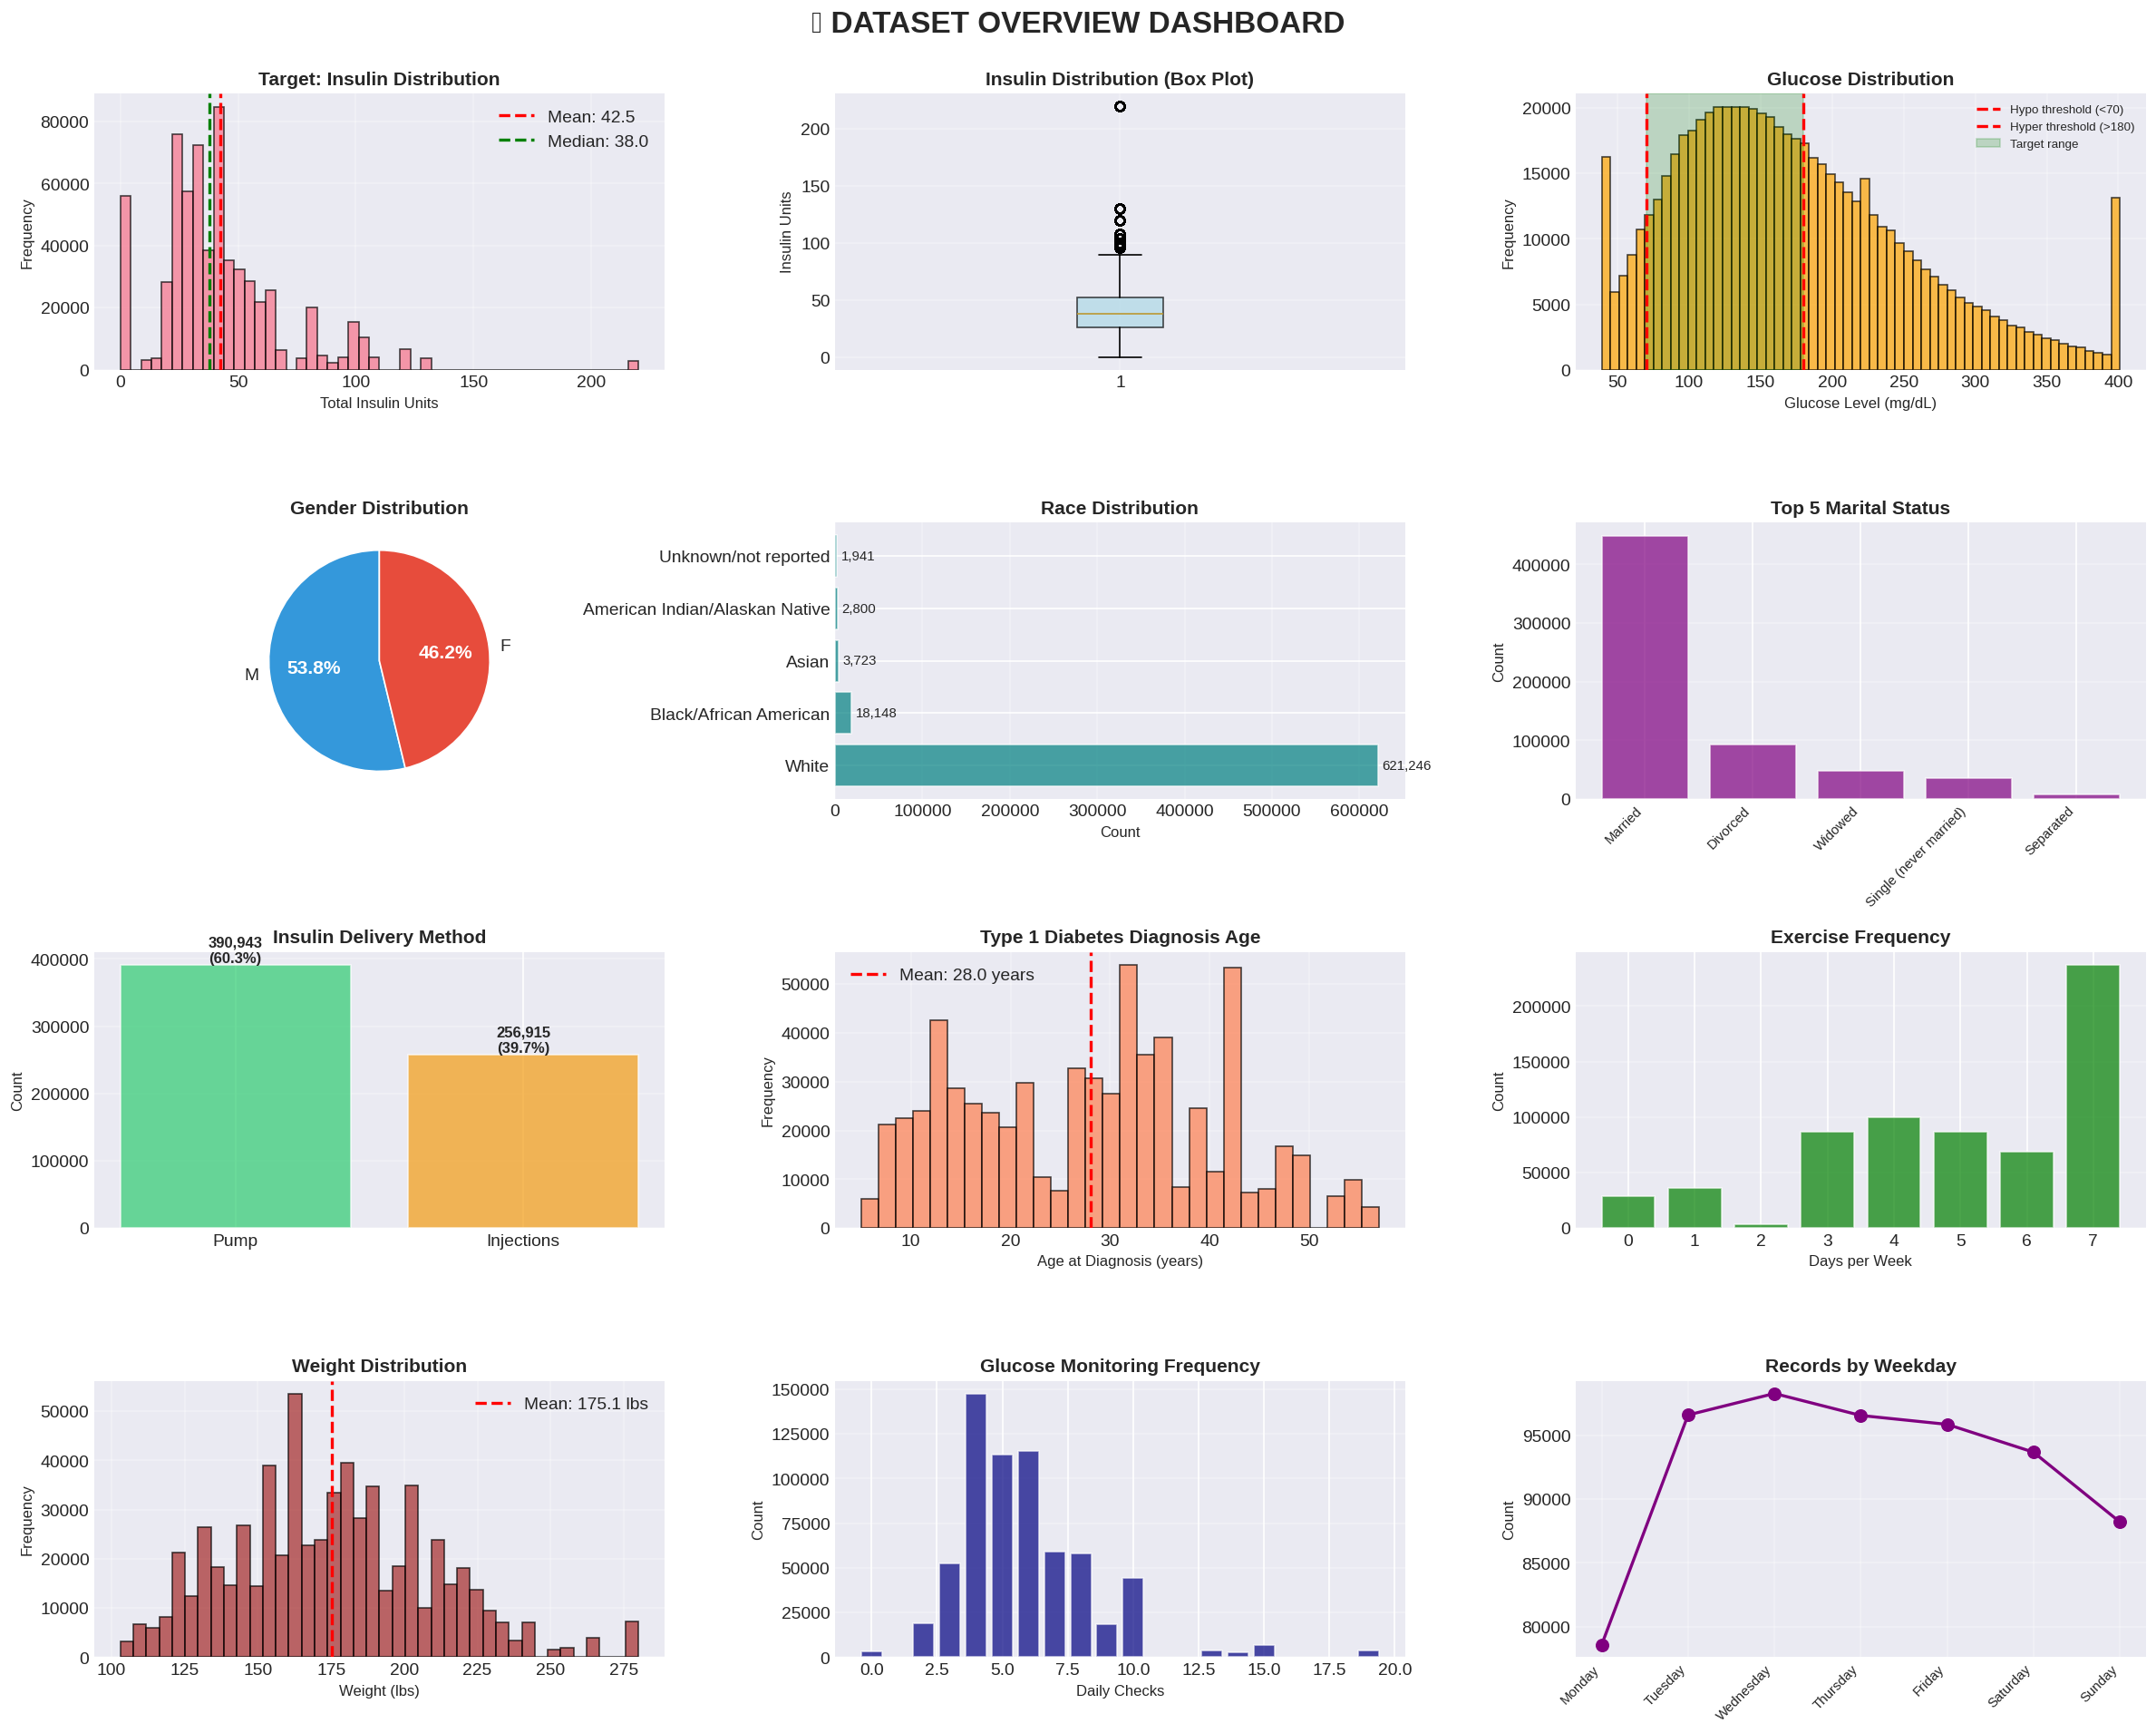

✓ Saved: 06_lifestyle_factors.png


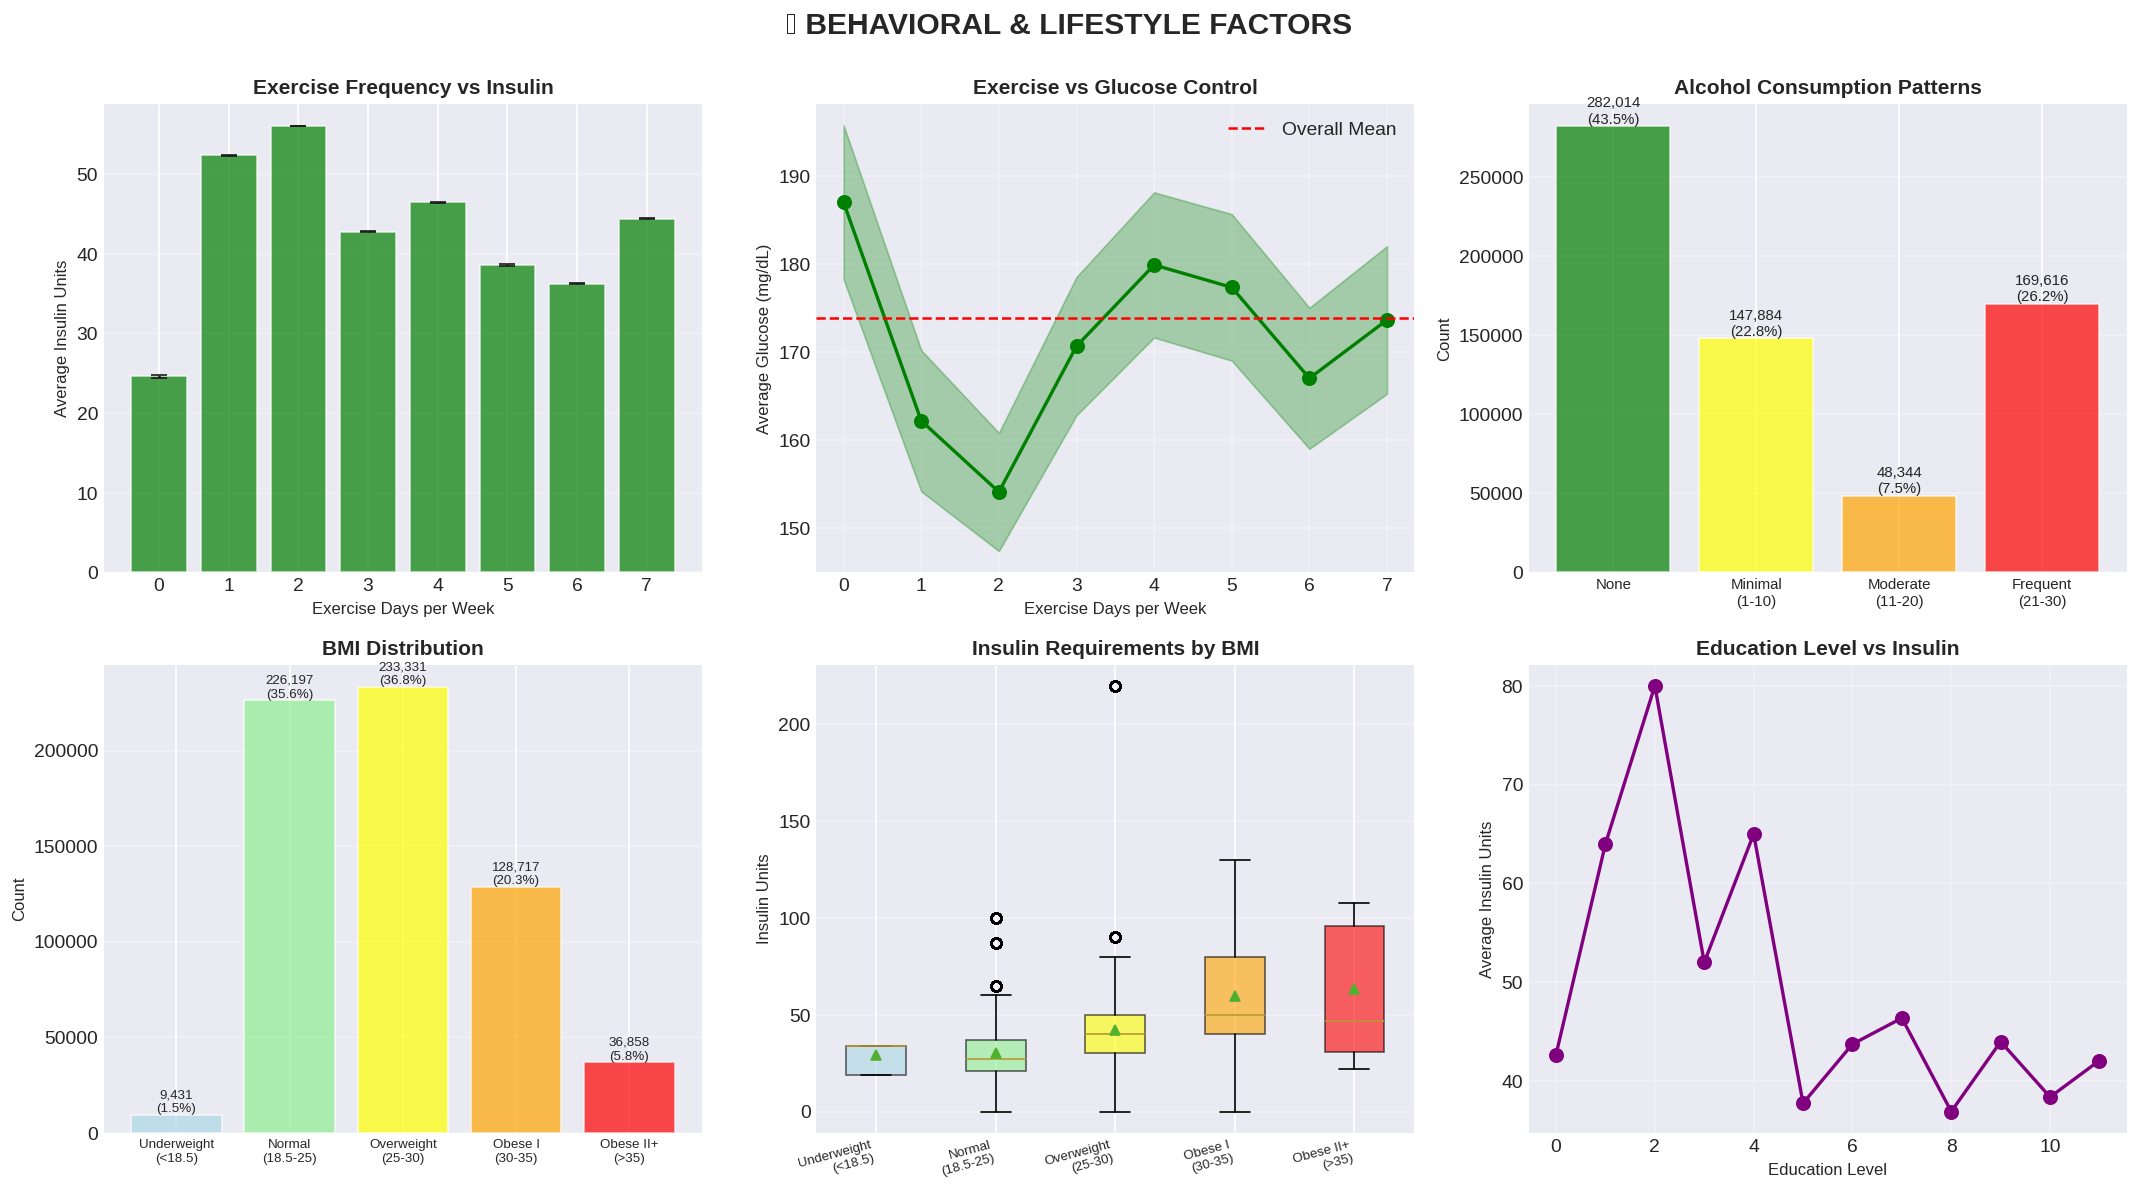

✓ Saved: 07_advanced_insights.png


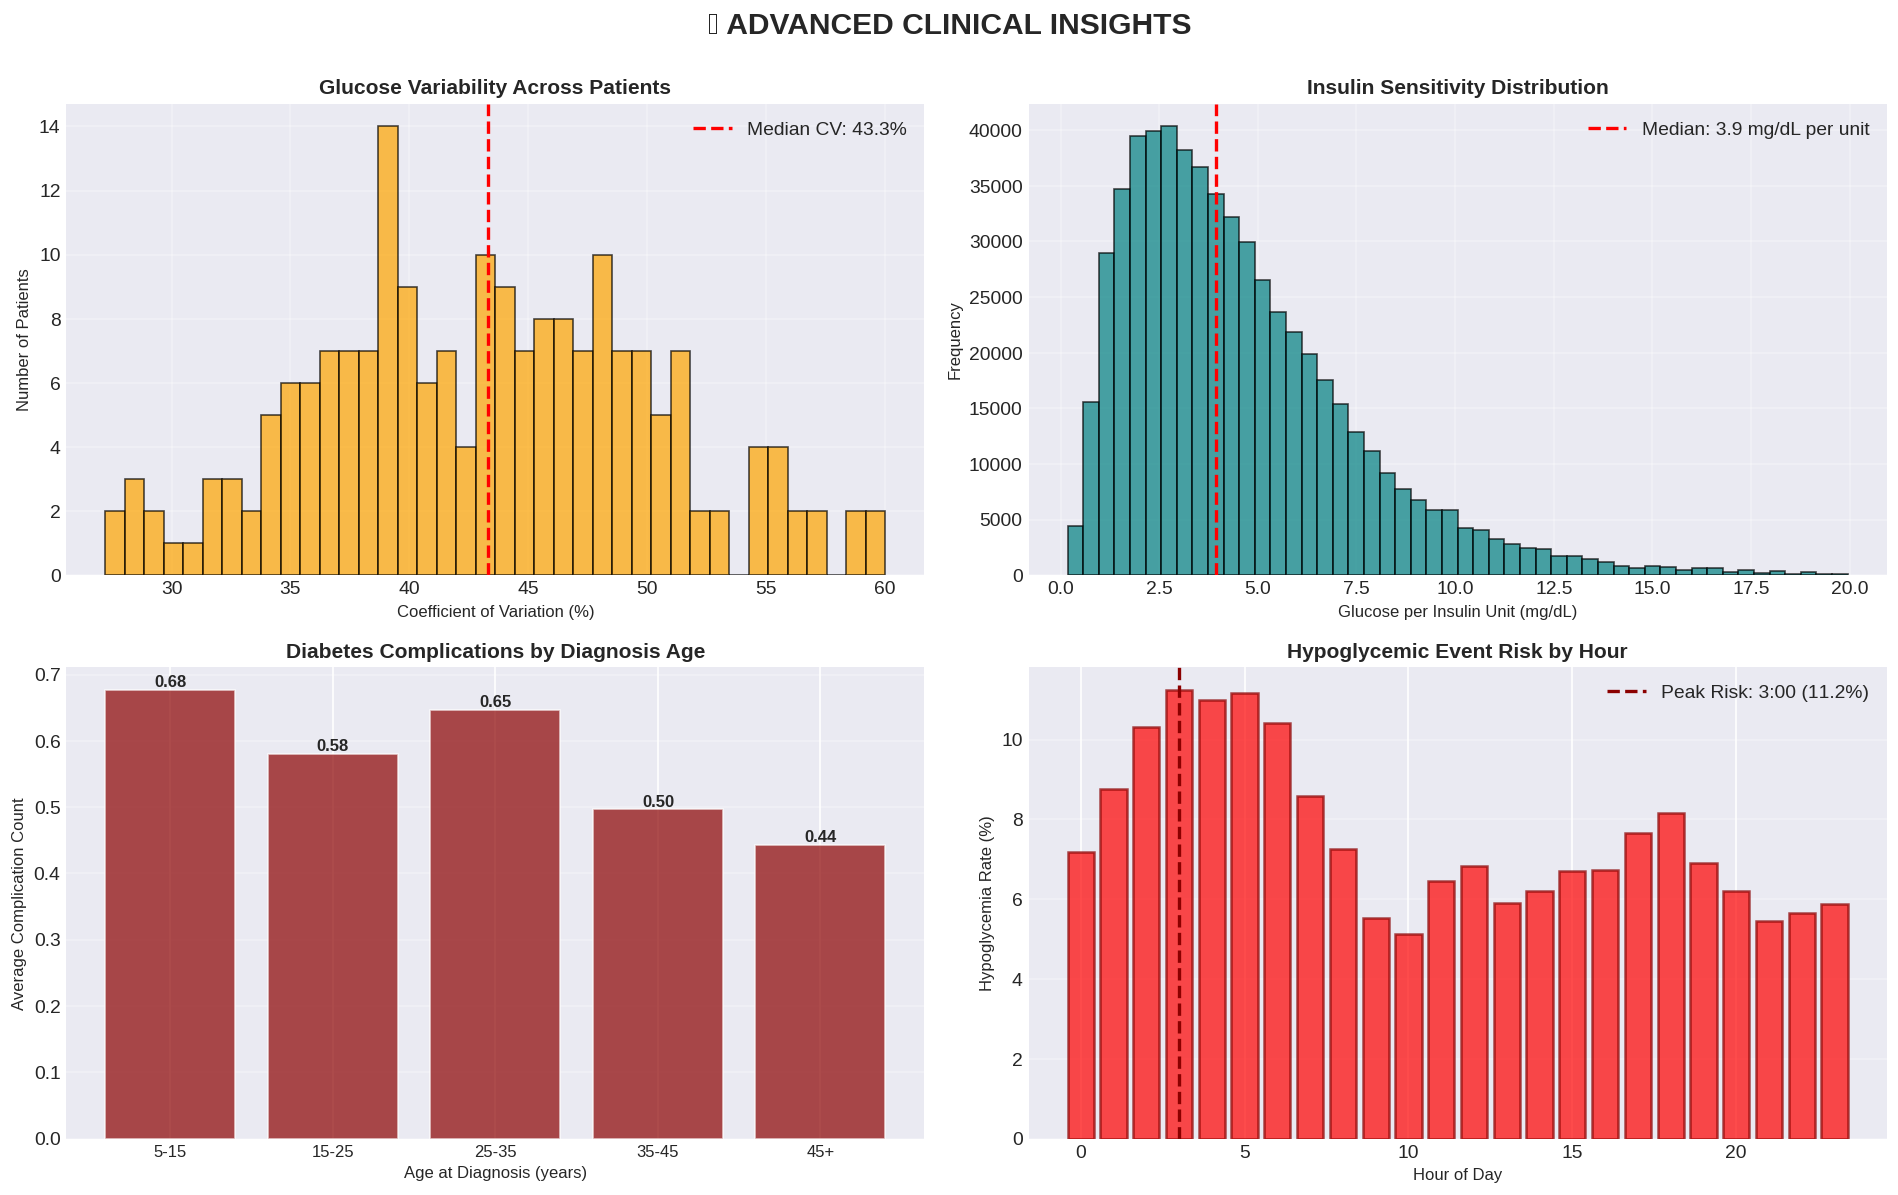

✓ Saved: 08_feature_importance.png


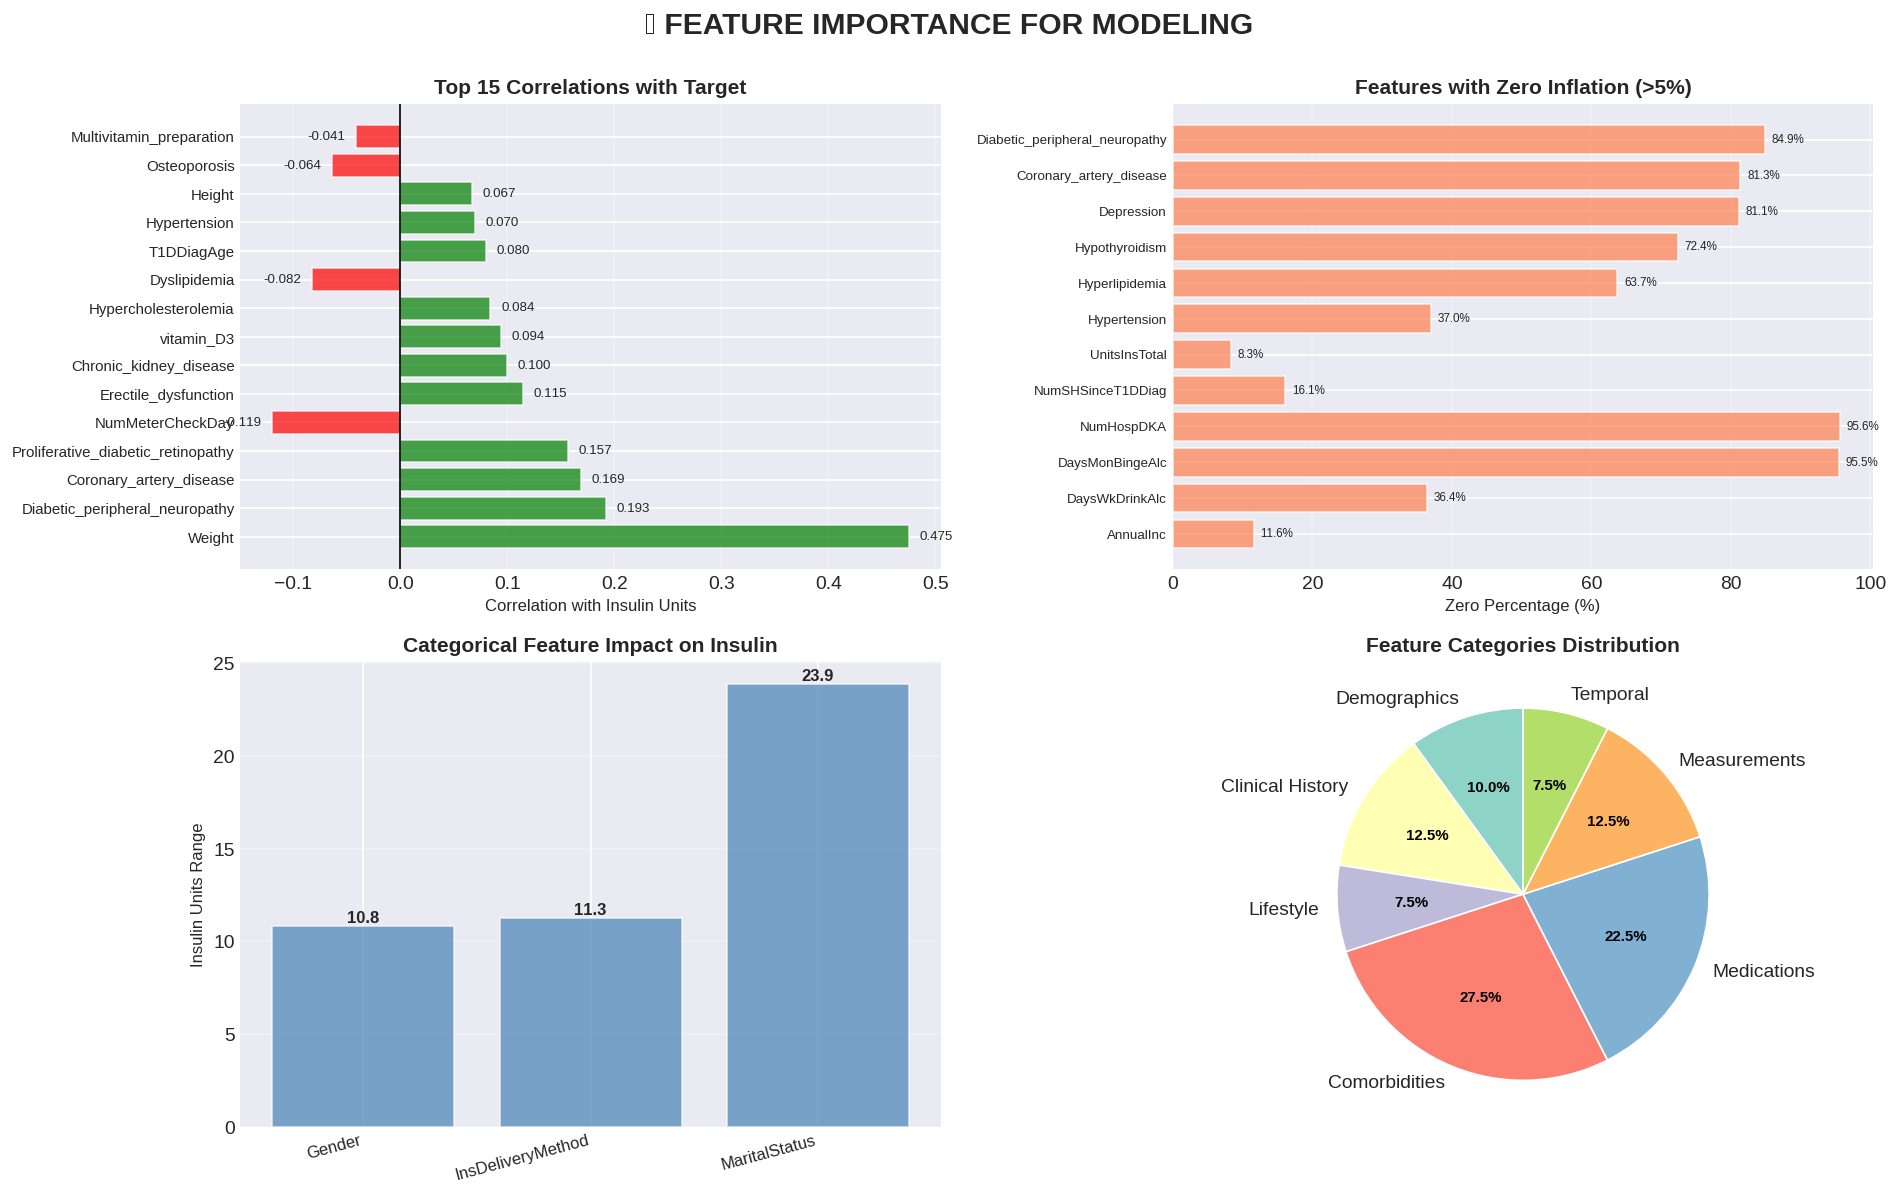


 📊 EDA SUMMARY STATISTICS

🎯 TARGET VARIABLE (UnitsInsTotal):
  • Mean: 42.49 units
  • Median: 38.00 units
  • Std Dev: 28.28 units
  • Range: [0, 220] units

📈 GLUCOSE METRICS:
  • Mean Glucose: 173.9 mg/dL
  • Time in Range (70-180): 51.4%
  • Hypoglycemia (<70): 7.5%
  • Hyperglycemia (>180): 41.1%

👥 PATIENT DEMOGRAPHICS:
  • Total Patients: 200
  • Male: 53.8%
  • Female: 46.2%
  • Using Pump: 60.3%

🏥 CLINICAL BURDEN:
  • Avg Comorbidities per Patient: 2.55
  • Patients with ≥3 Comorbidities: 47.2%

🏃 LIFESTYLE FACTORS:
  • Avg Exercise Days/Week: 5.0
  • No Alcohol Use: 36.4%
  • Daily Meter Checks (avg): 5.9

✅ EDA COMPLETE - All visualizations saved!

📁 Files Generated:
  1. 01_dataset_overview.png
  2. 02_target_relationships.png
  3. 03_glucose_patterns.png
  4. 04_comorbidity_medications.png
  5. 05_correlation_matrix.png
  6. 06_lifestyle_factors.png
  7. 07_advanced_insights.png
  8. 08_feature_importance.png

💡 Next Steps: Feature Engineering → Model Building → Evaluat

<Figure size 768x576 with 0 Axes>

✓ Saved: 02_target_relationships.png


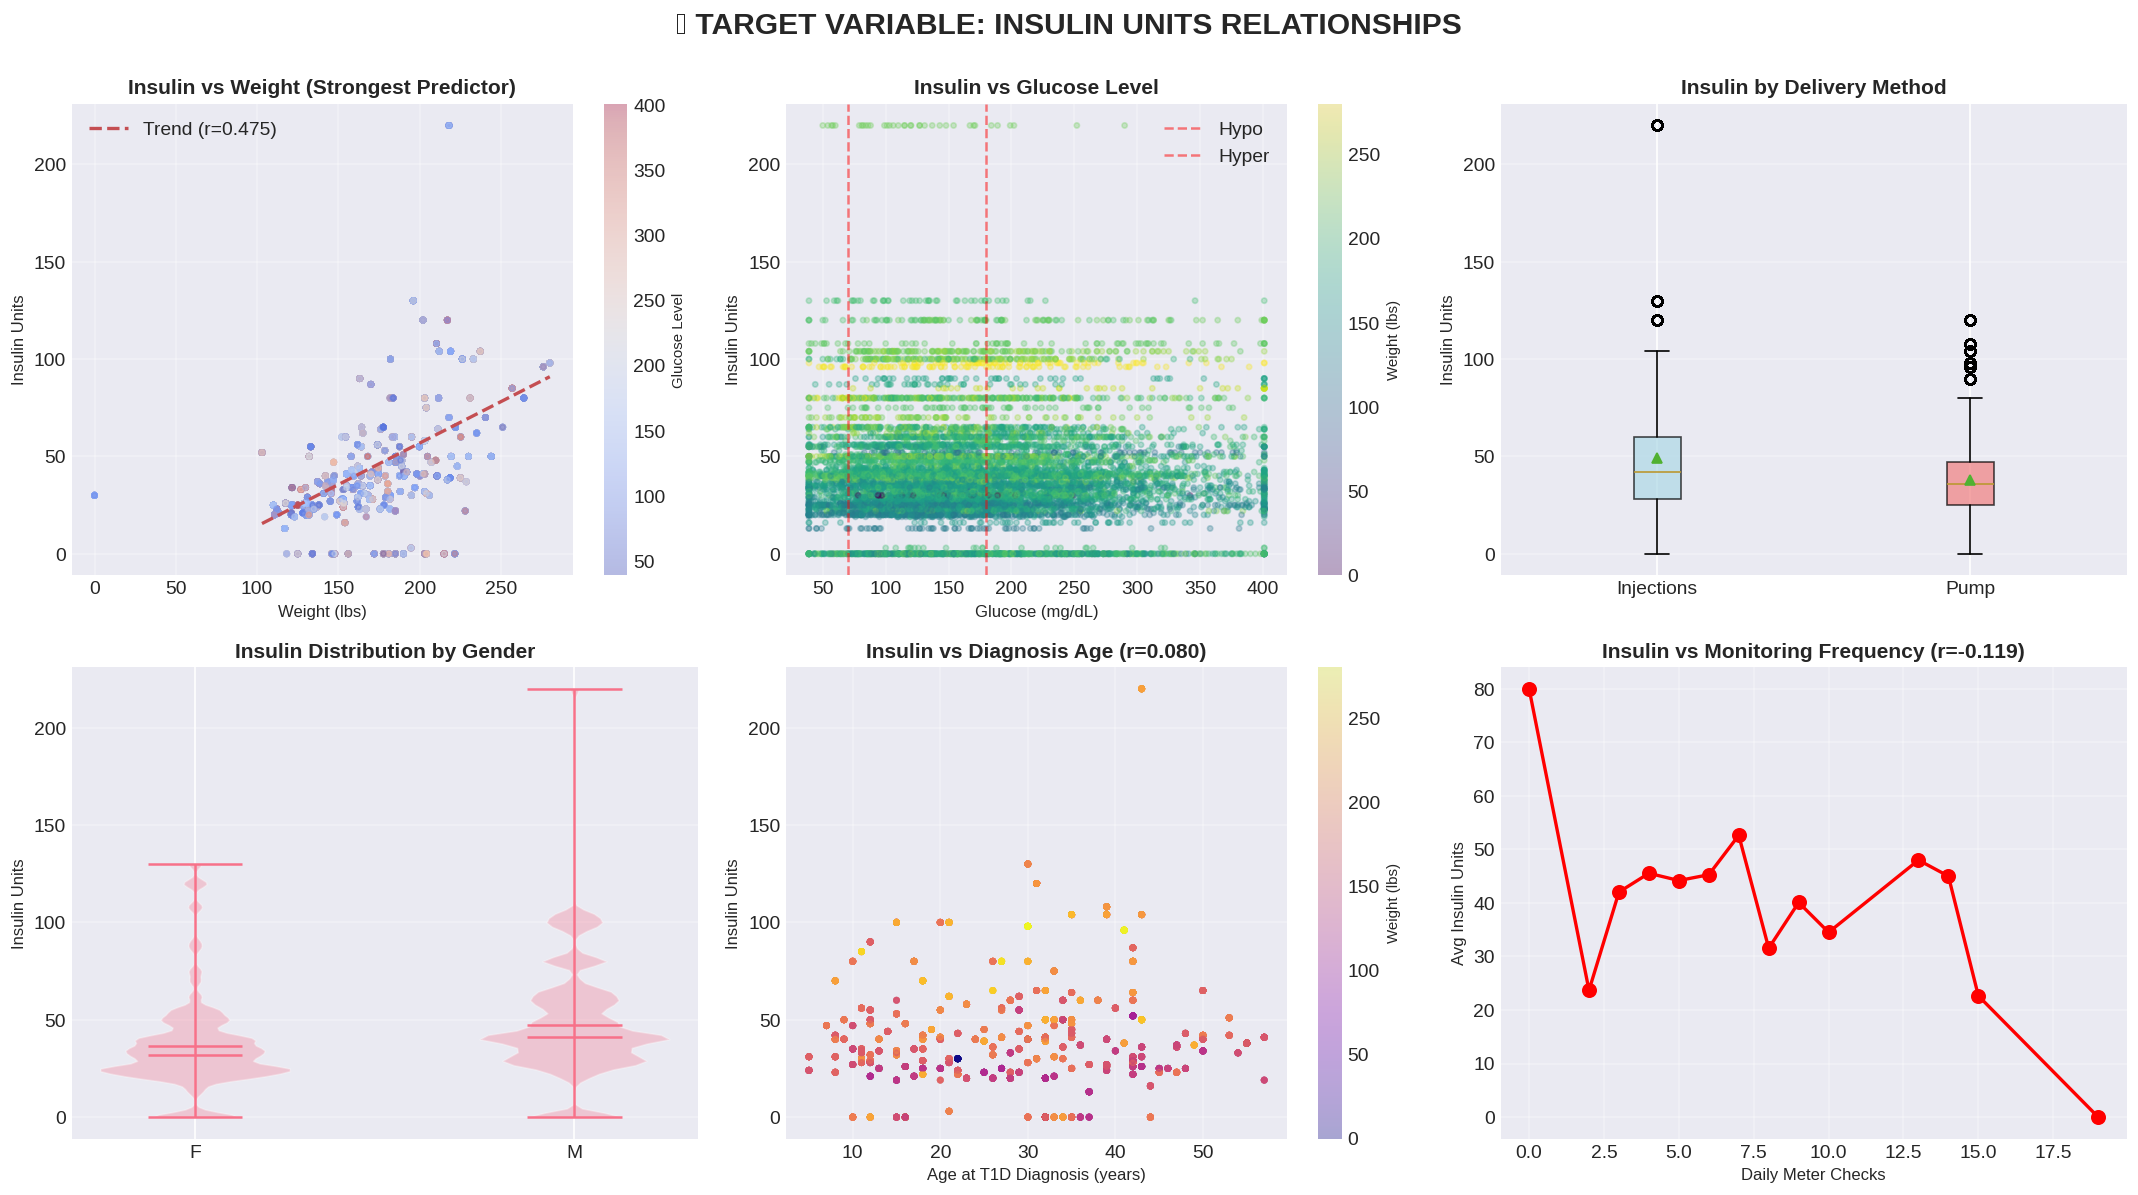

✓ Saved: 03_glucose_patterns.png


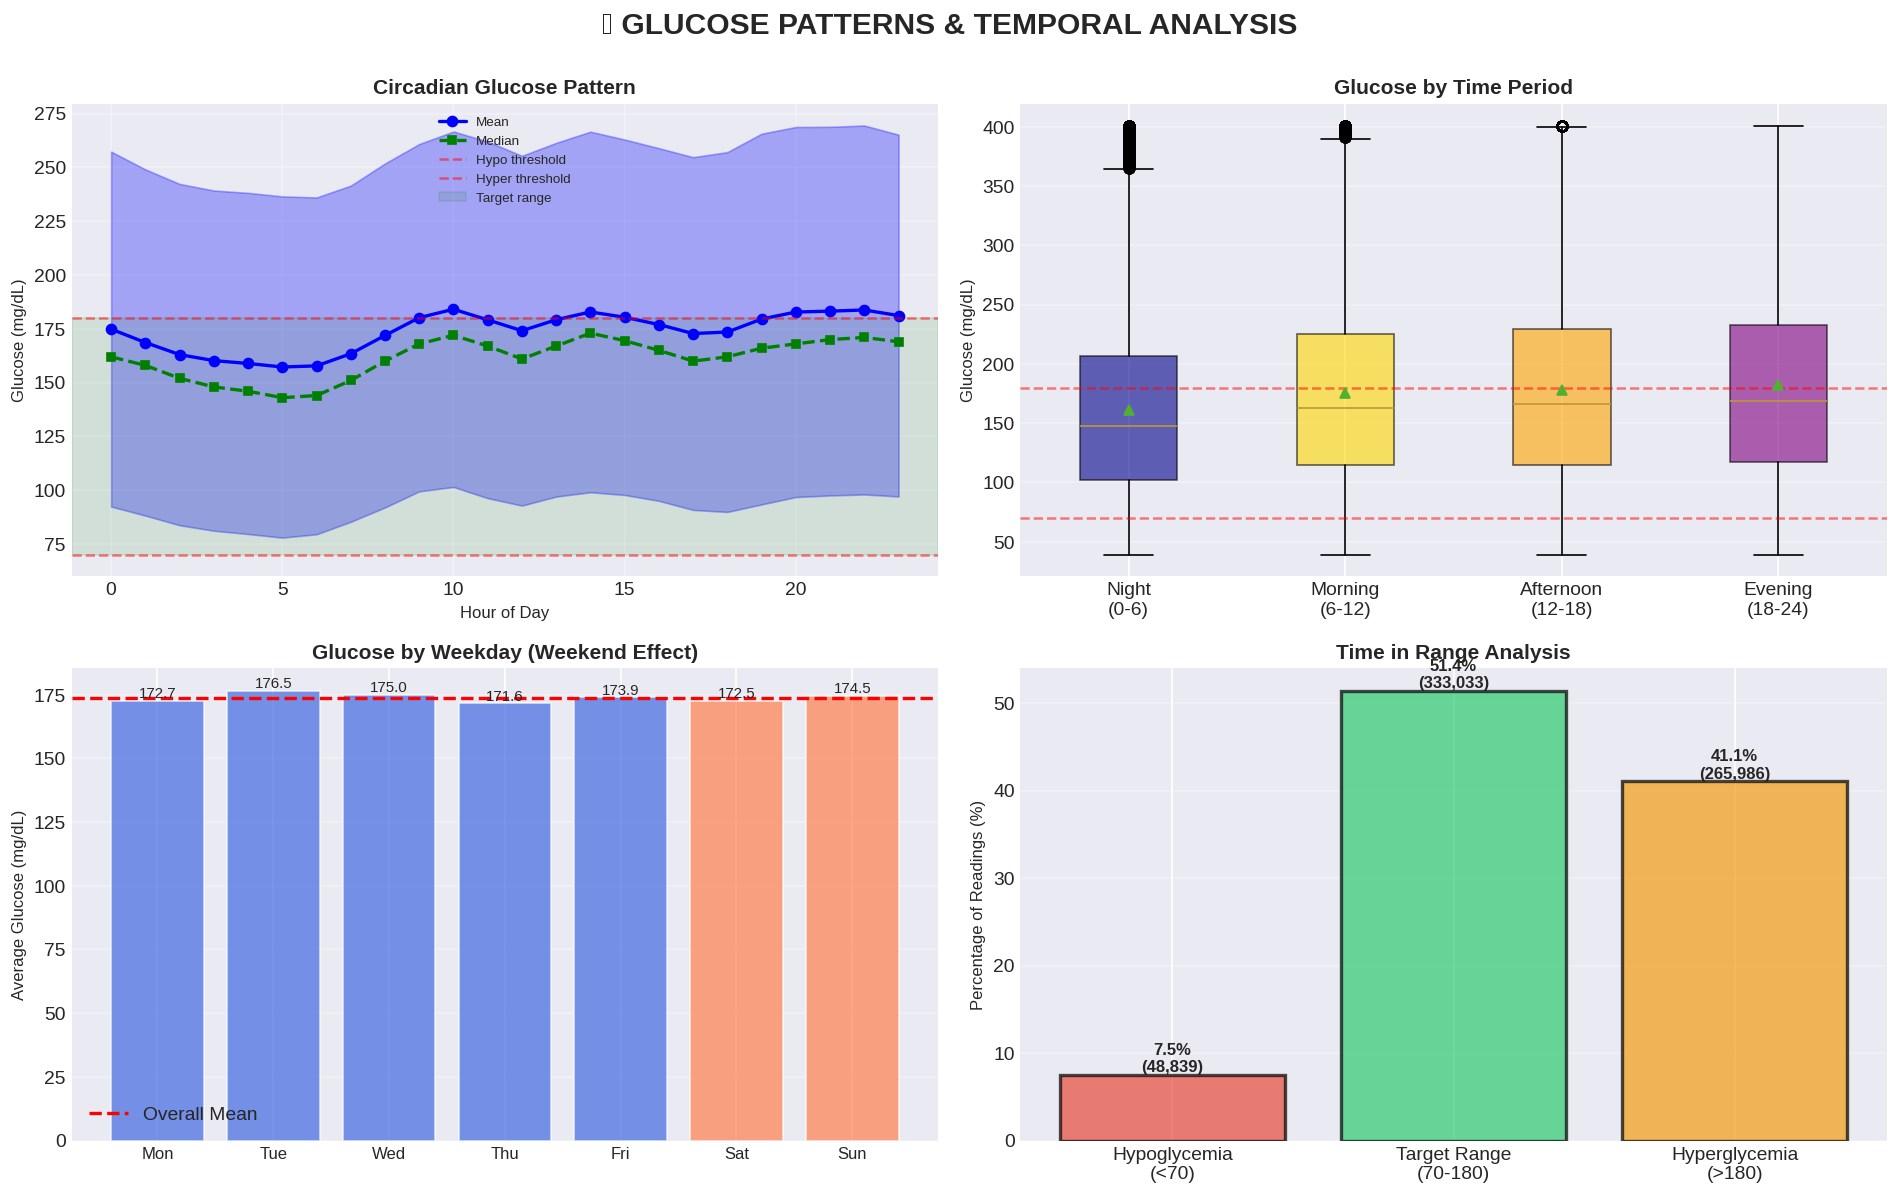

✓ Saved: 04_comorbidity_medications.png


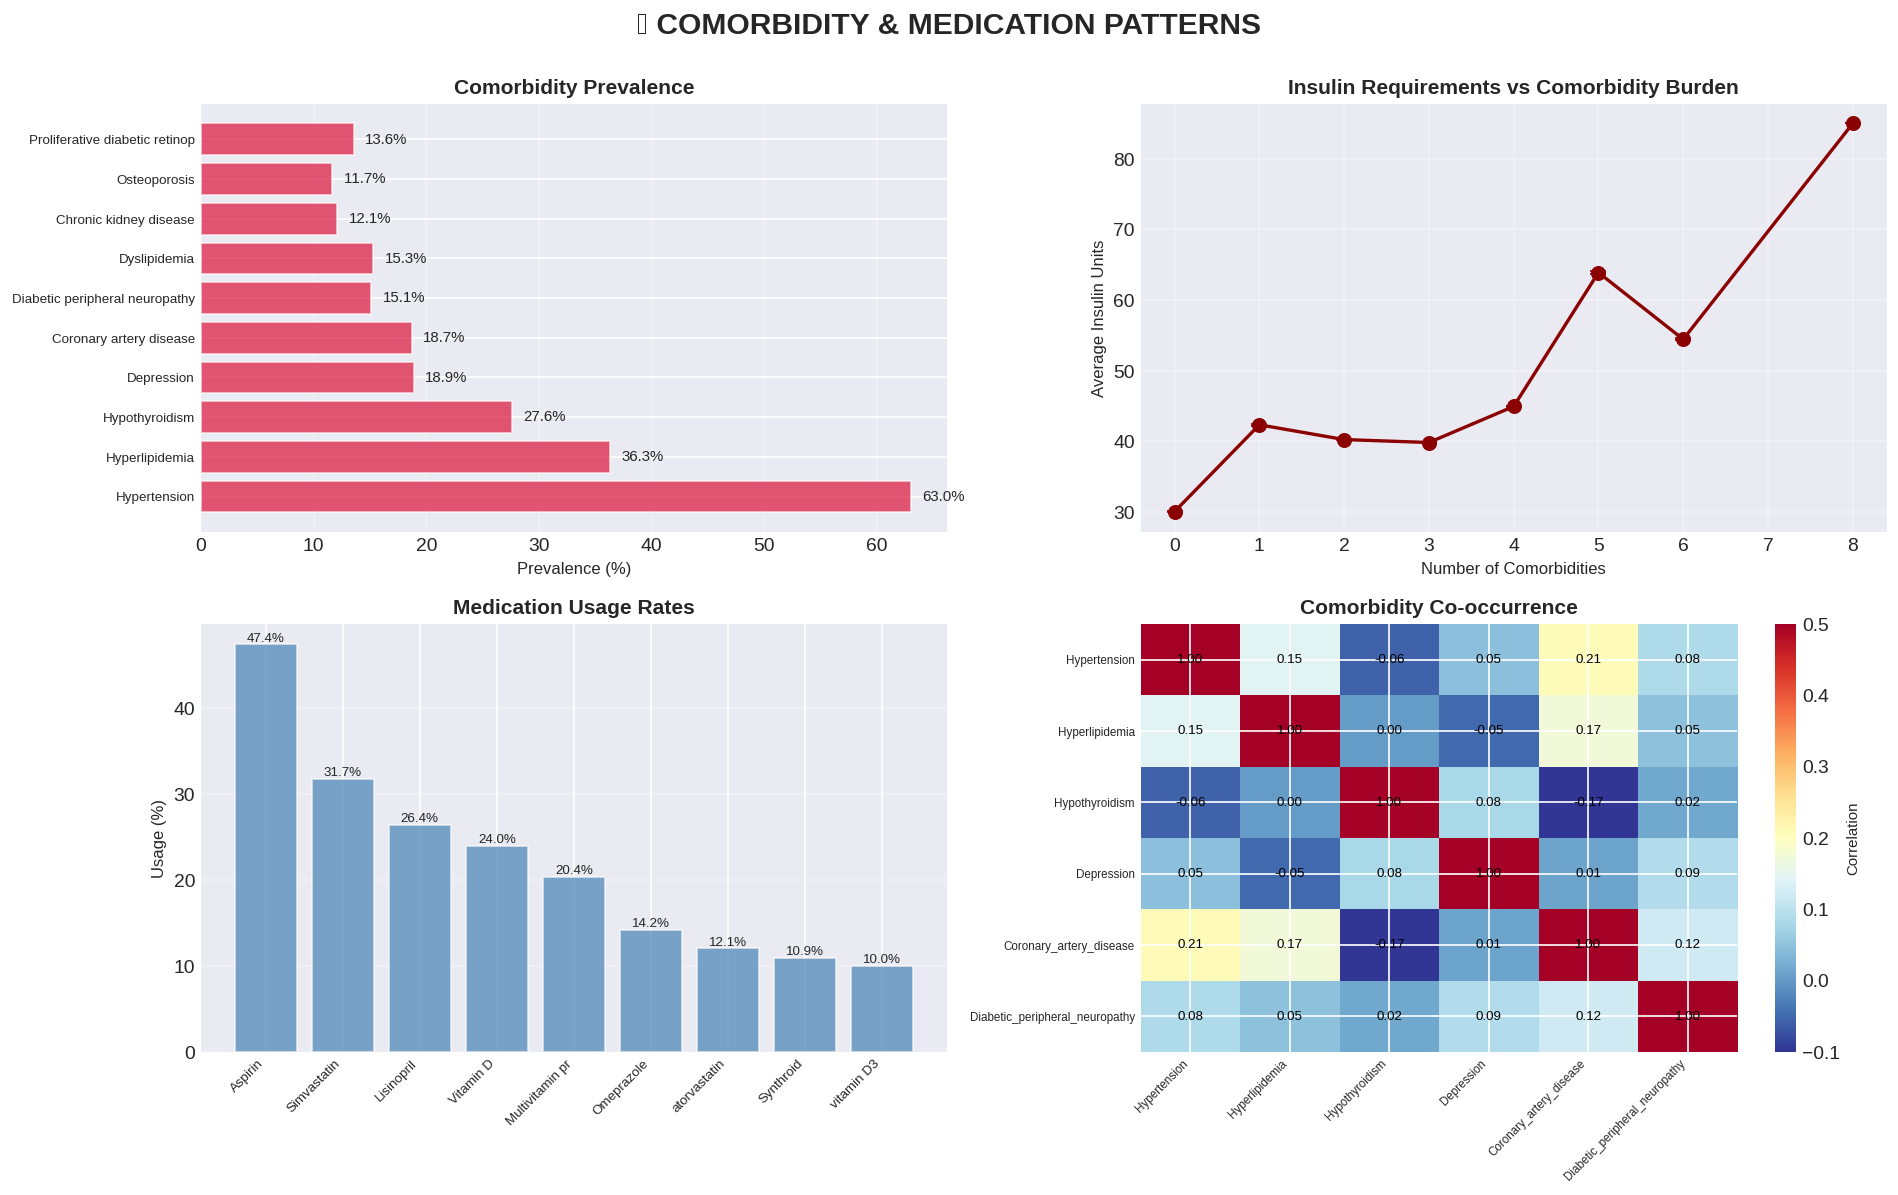

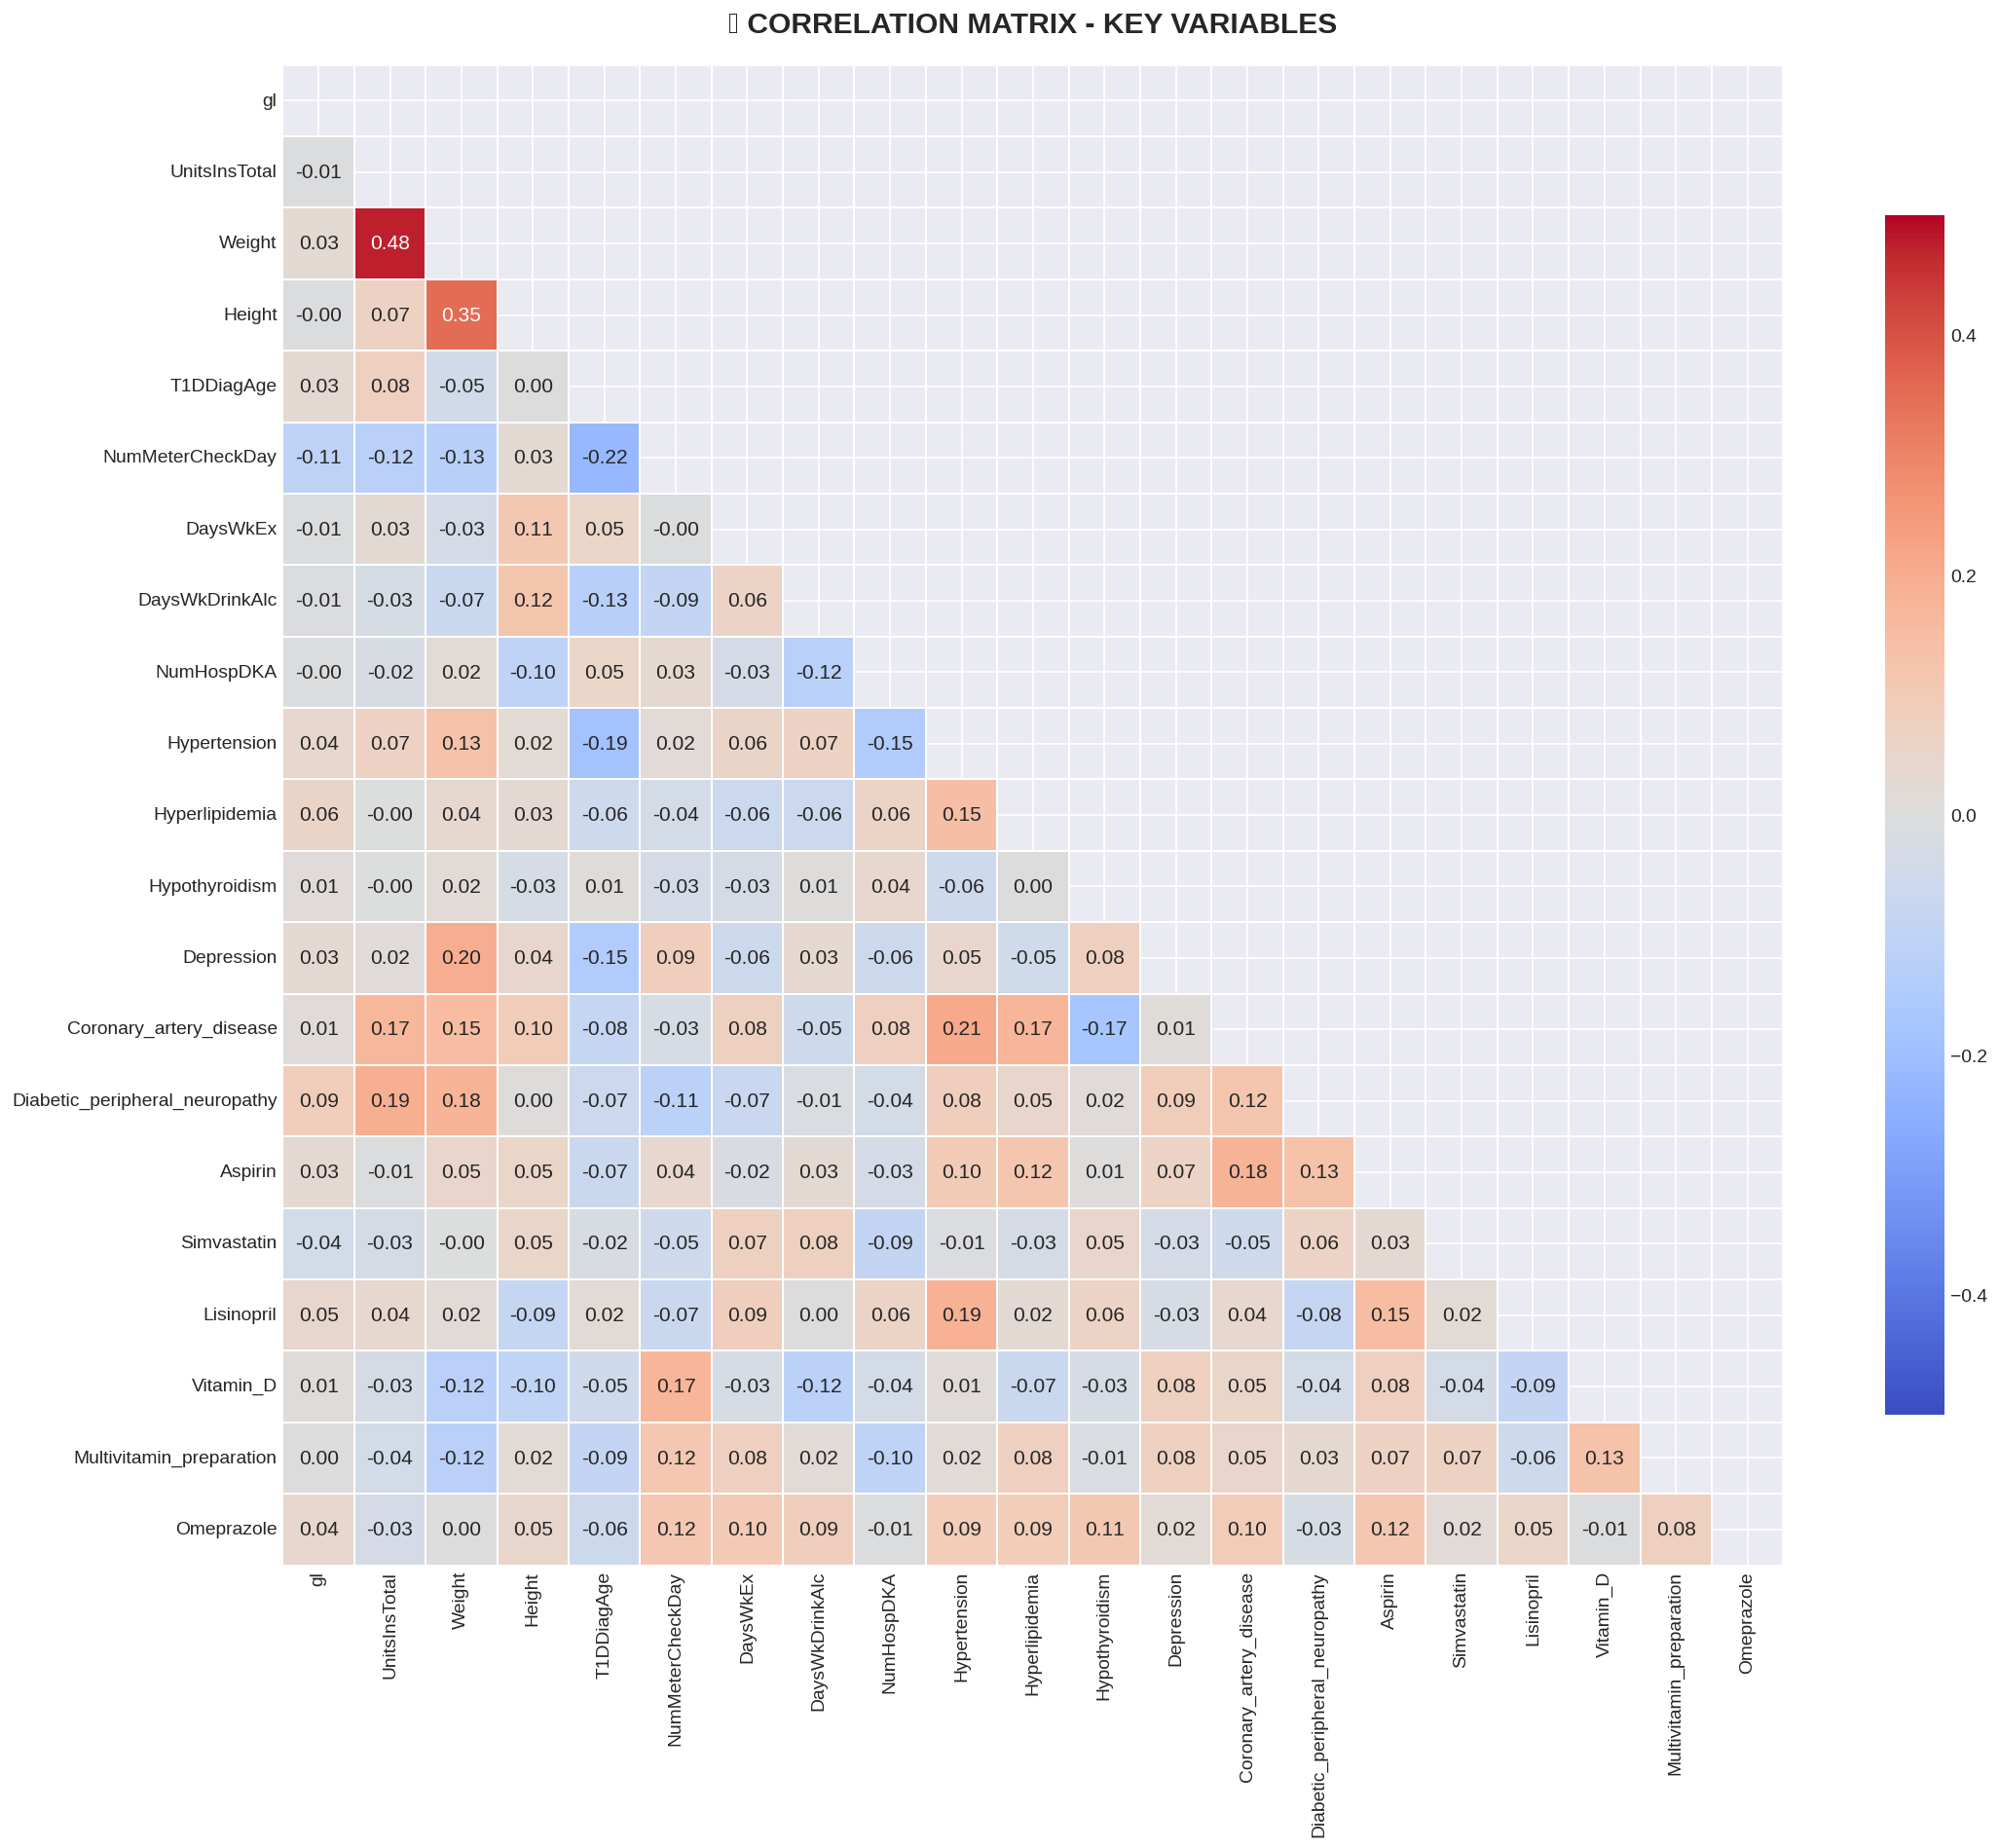

In [ ]:
# Run the complete EDA
comprehensive_eda_plots(df, target_col='UnitsInsTotal')


In [ ]:
df = df.reset_index(drop=True)


📊 GENERATING BIVARIATE ANALYSIS PLOTS
✓ Saved: /content/01_categorical_bivariate.png


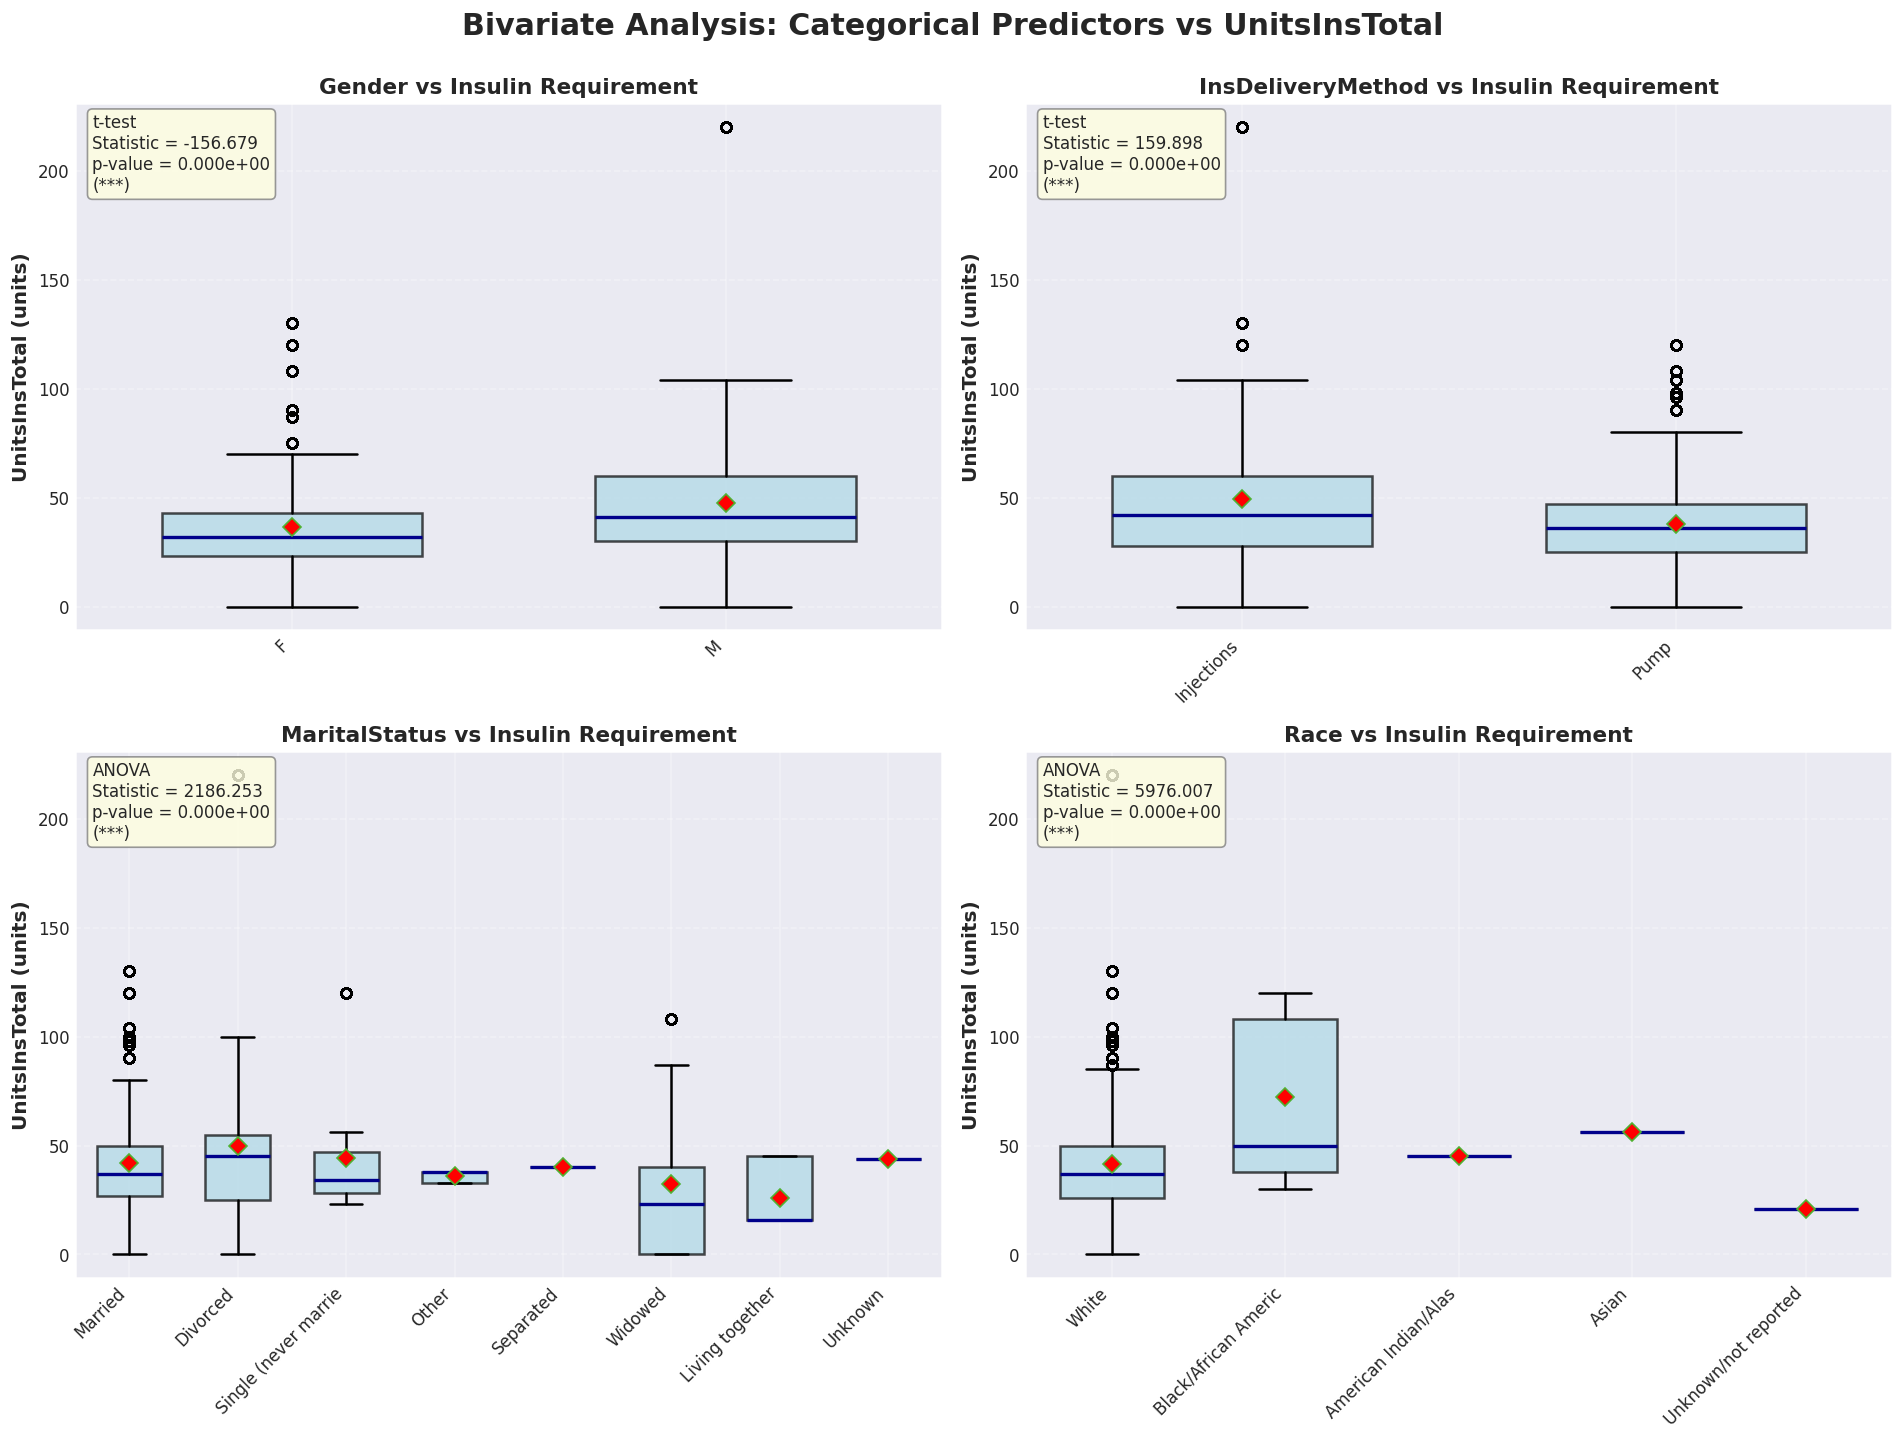

✓ Saved: /content/02_glucose_insulin_bivariate.png


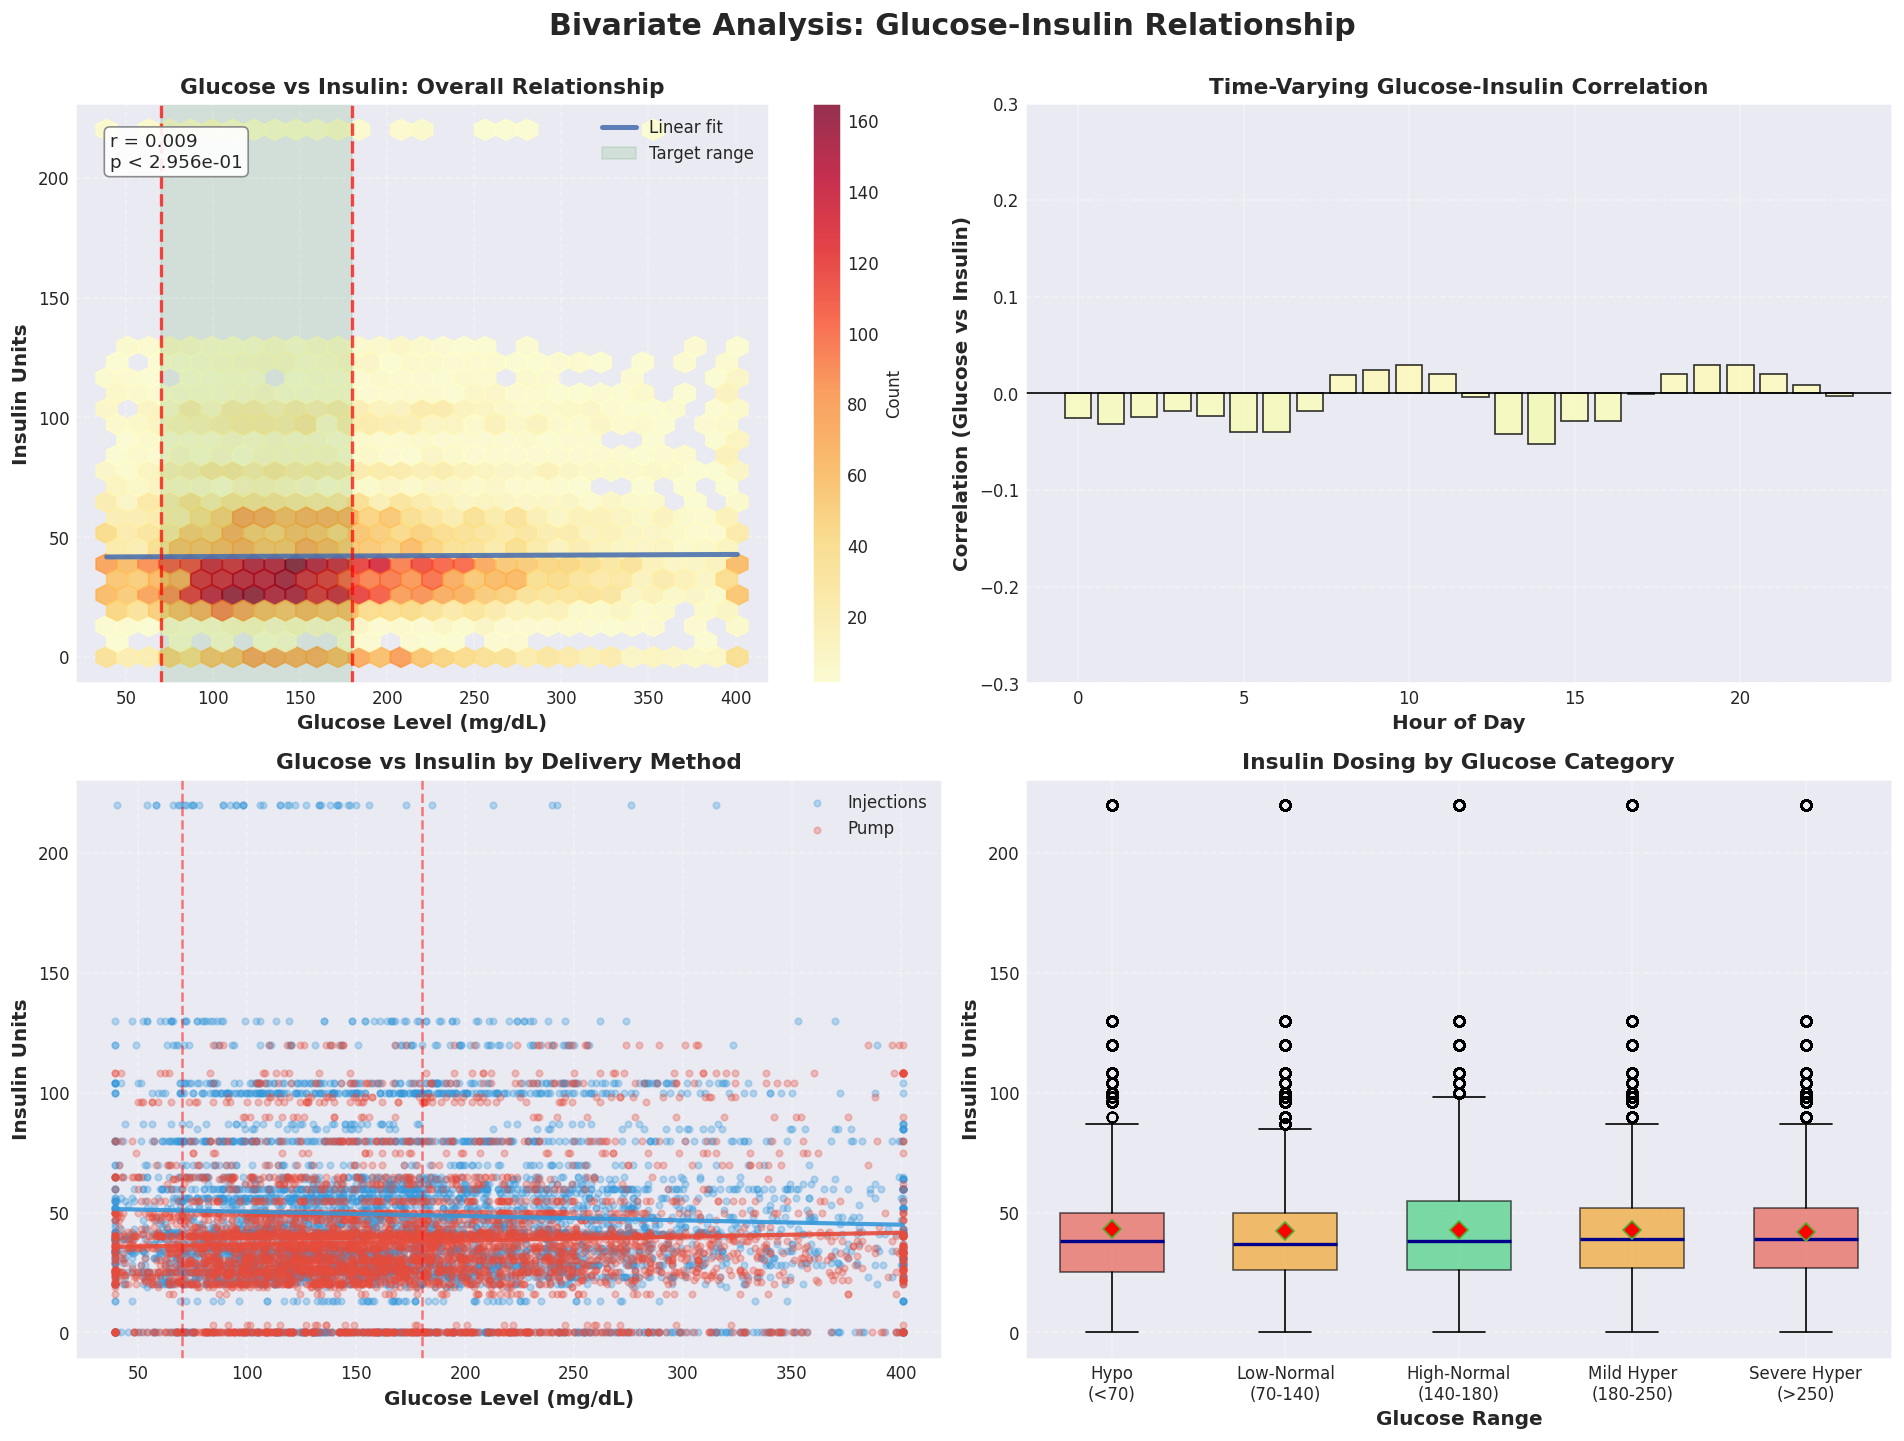

✓ Saved: /content/03_clinical_factors_bivariate.png


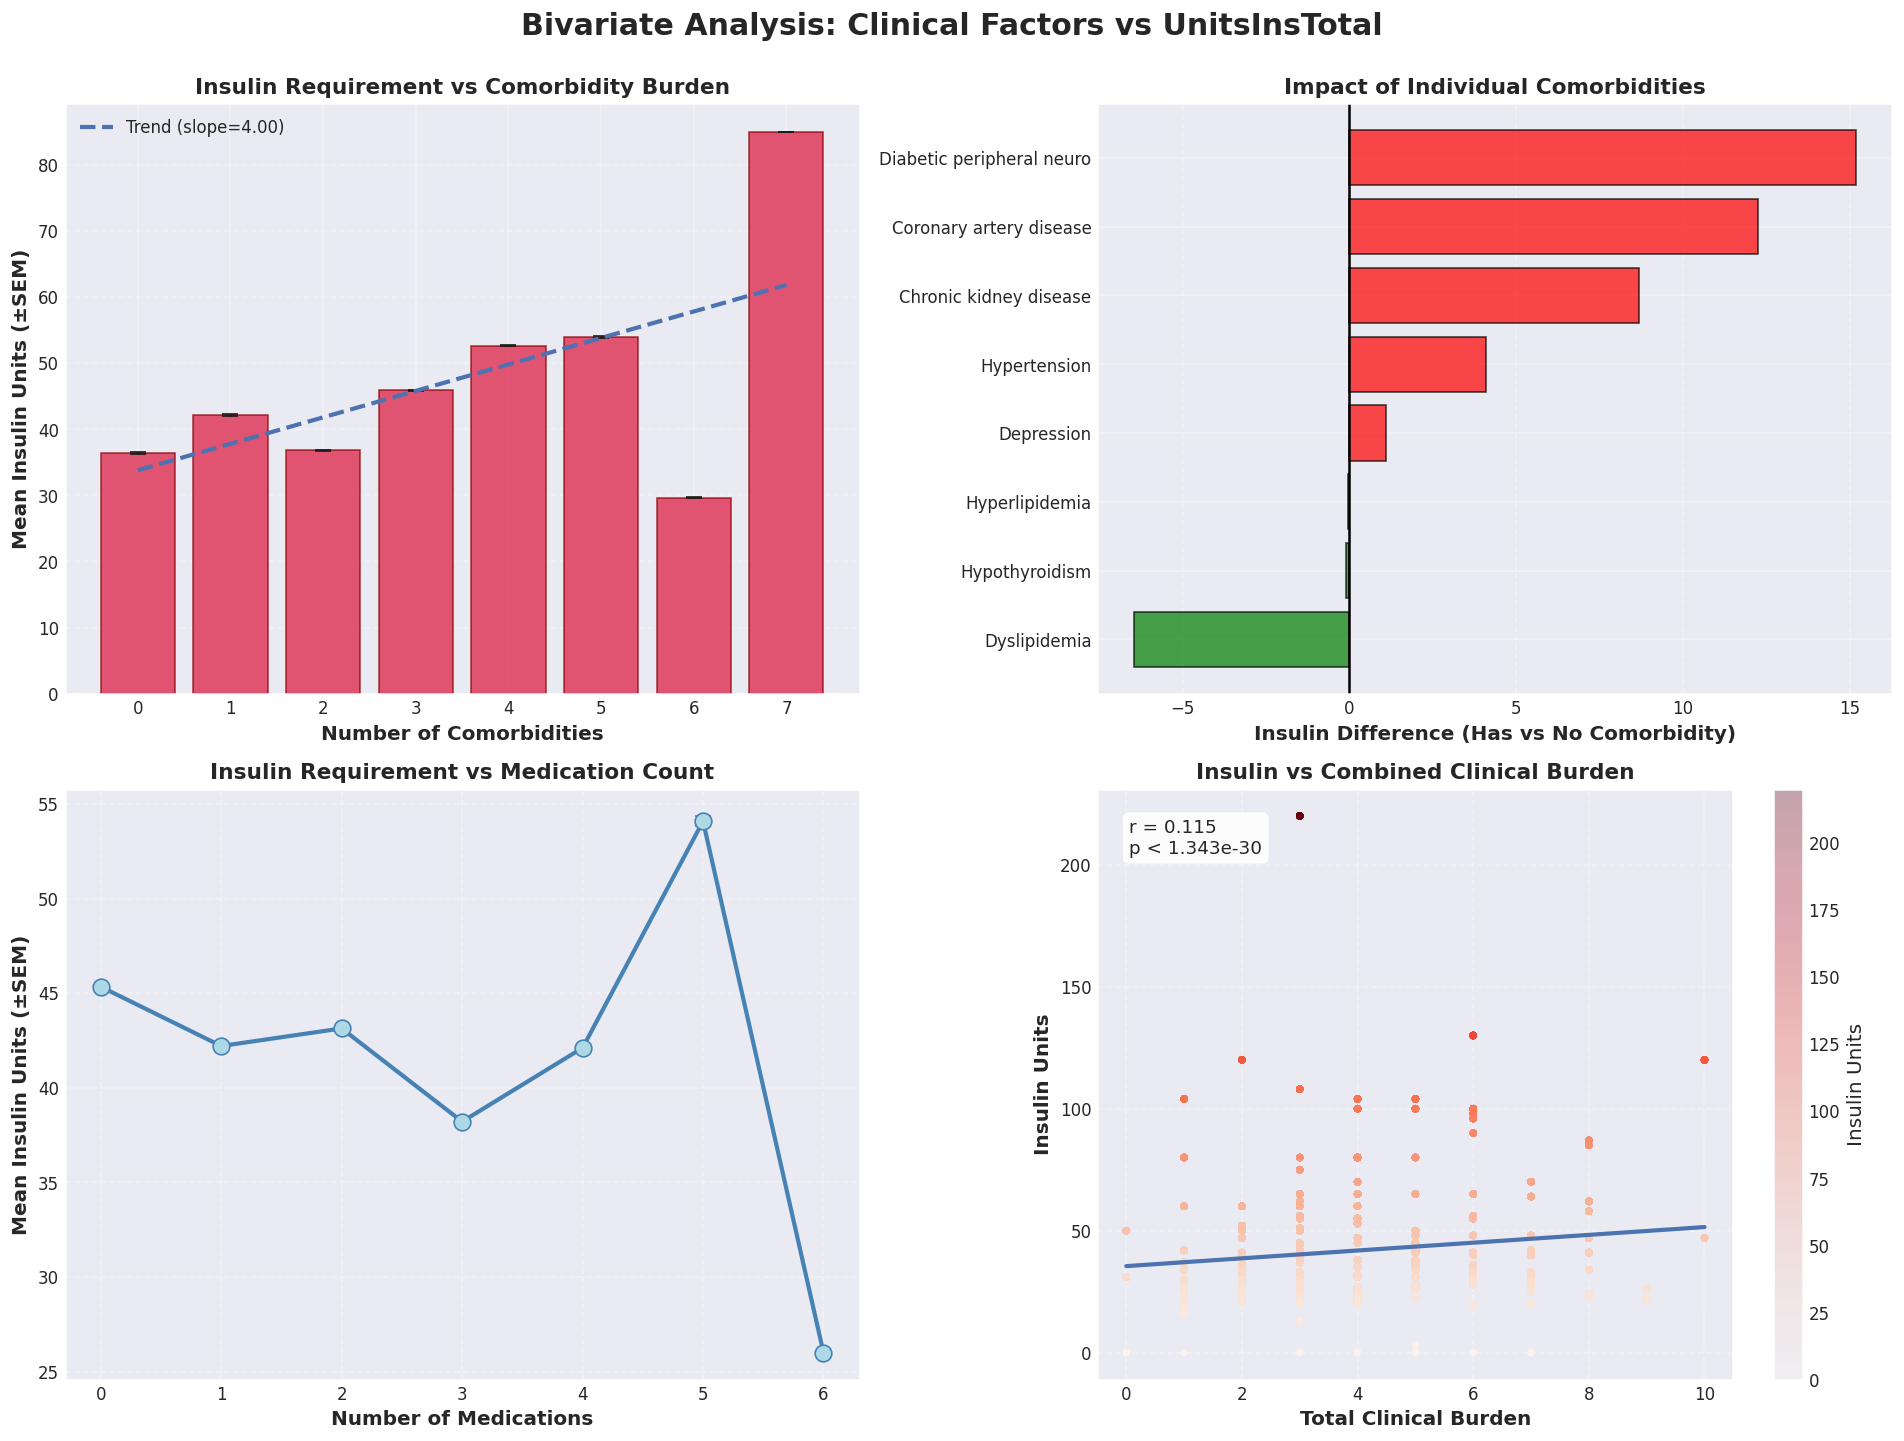

✓ Saved: /content/04_weight_bmi_bivariate.png


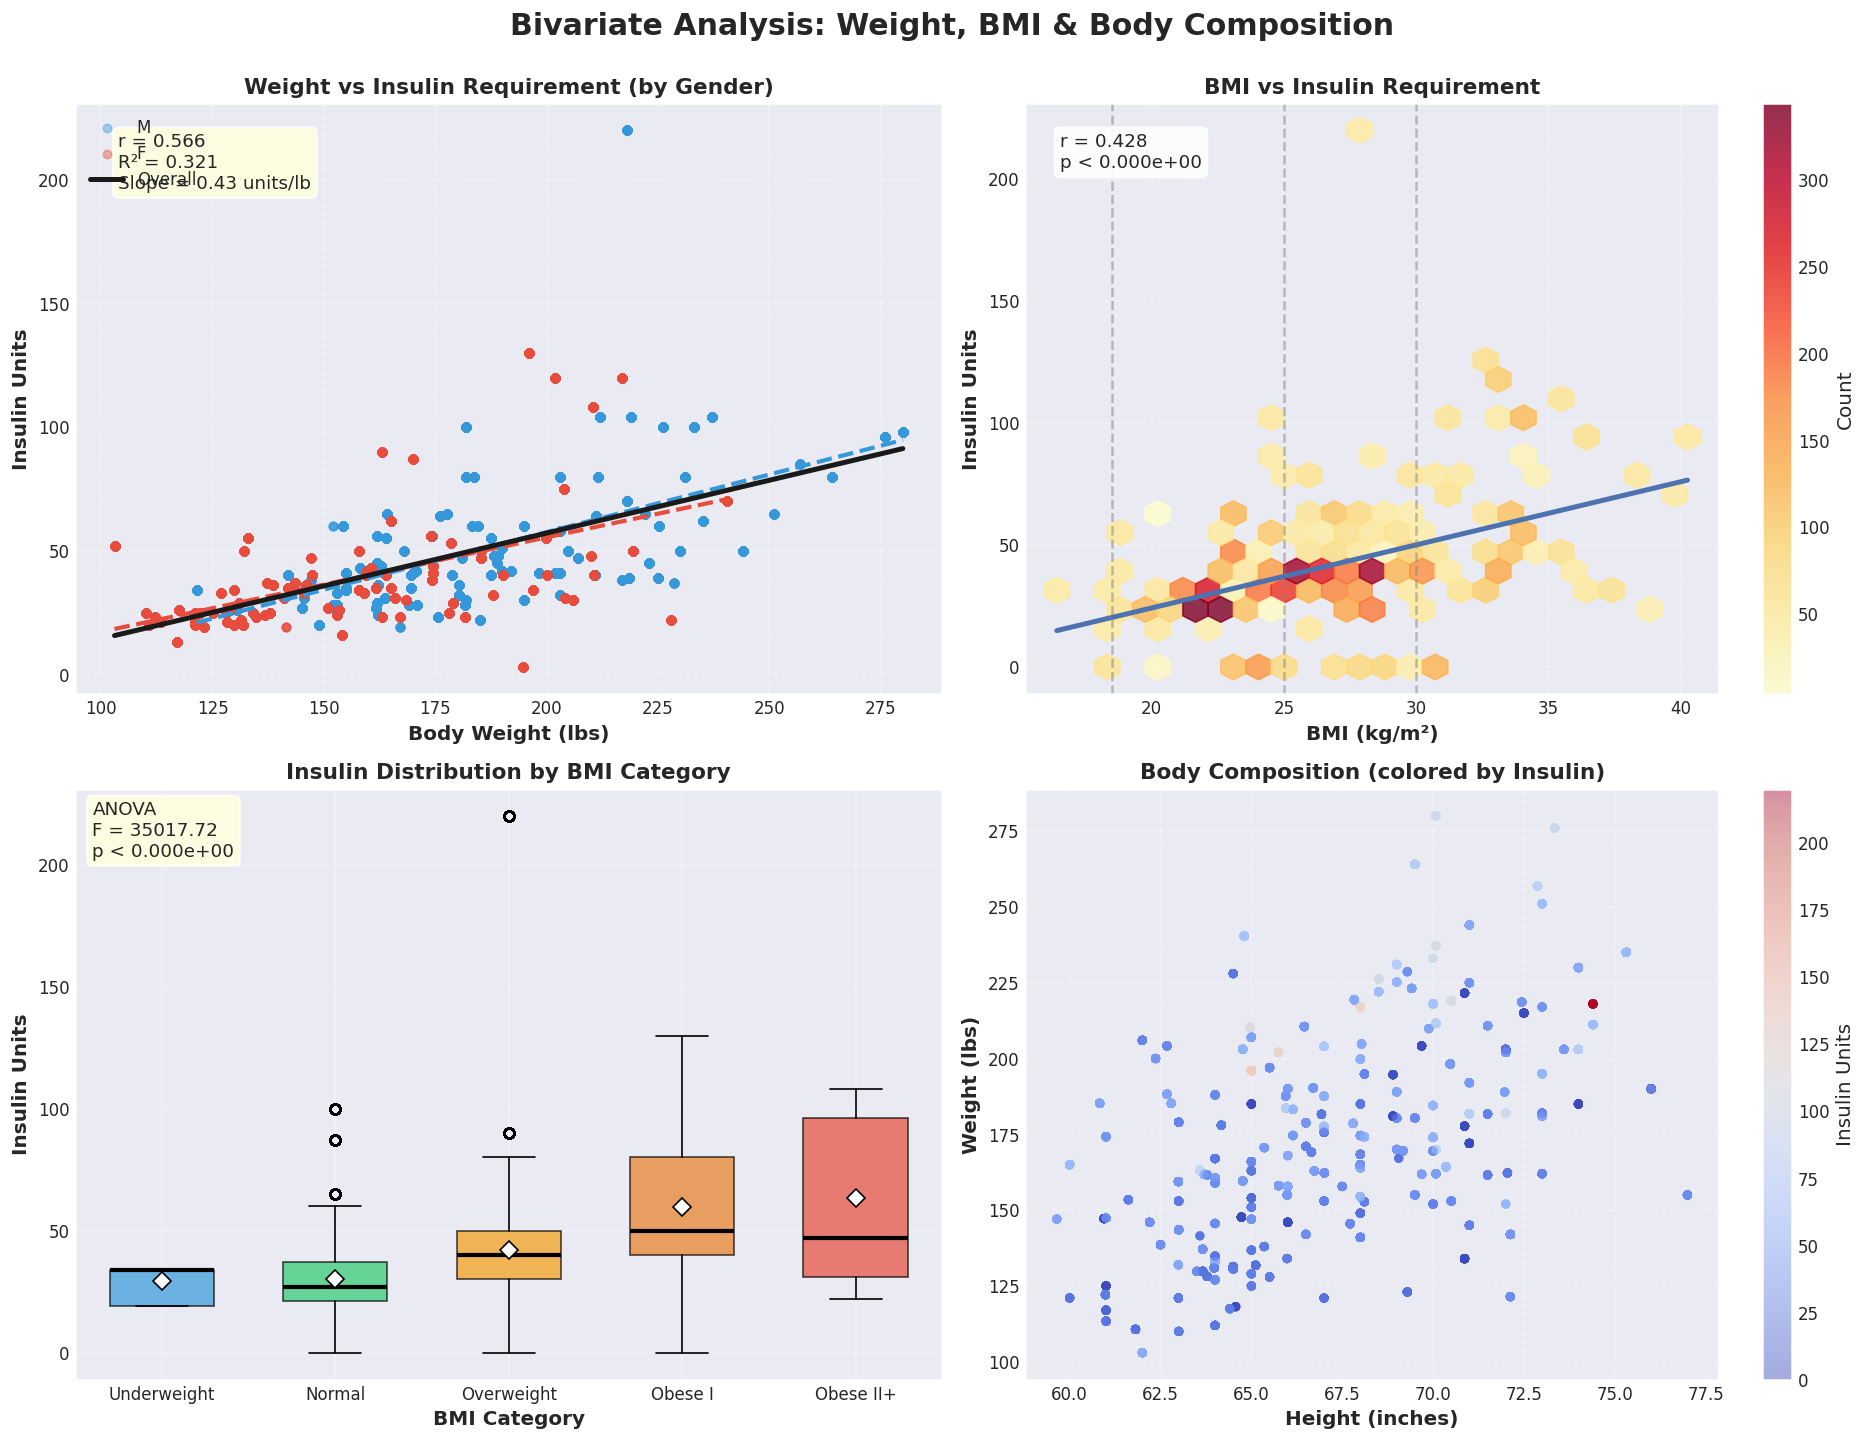

✓ Saved: /content/05_correlation_matrix.png


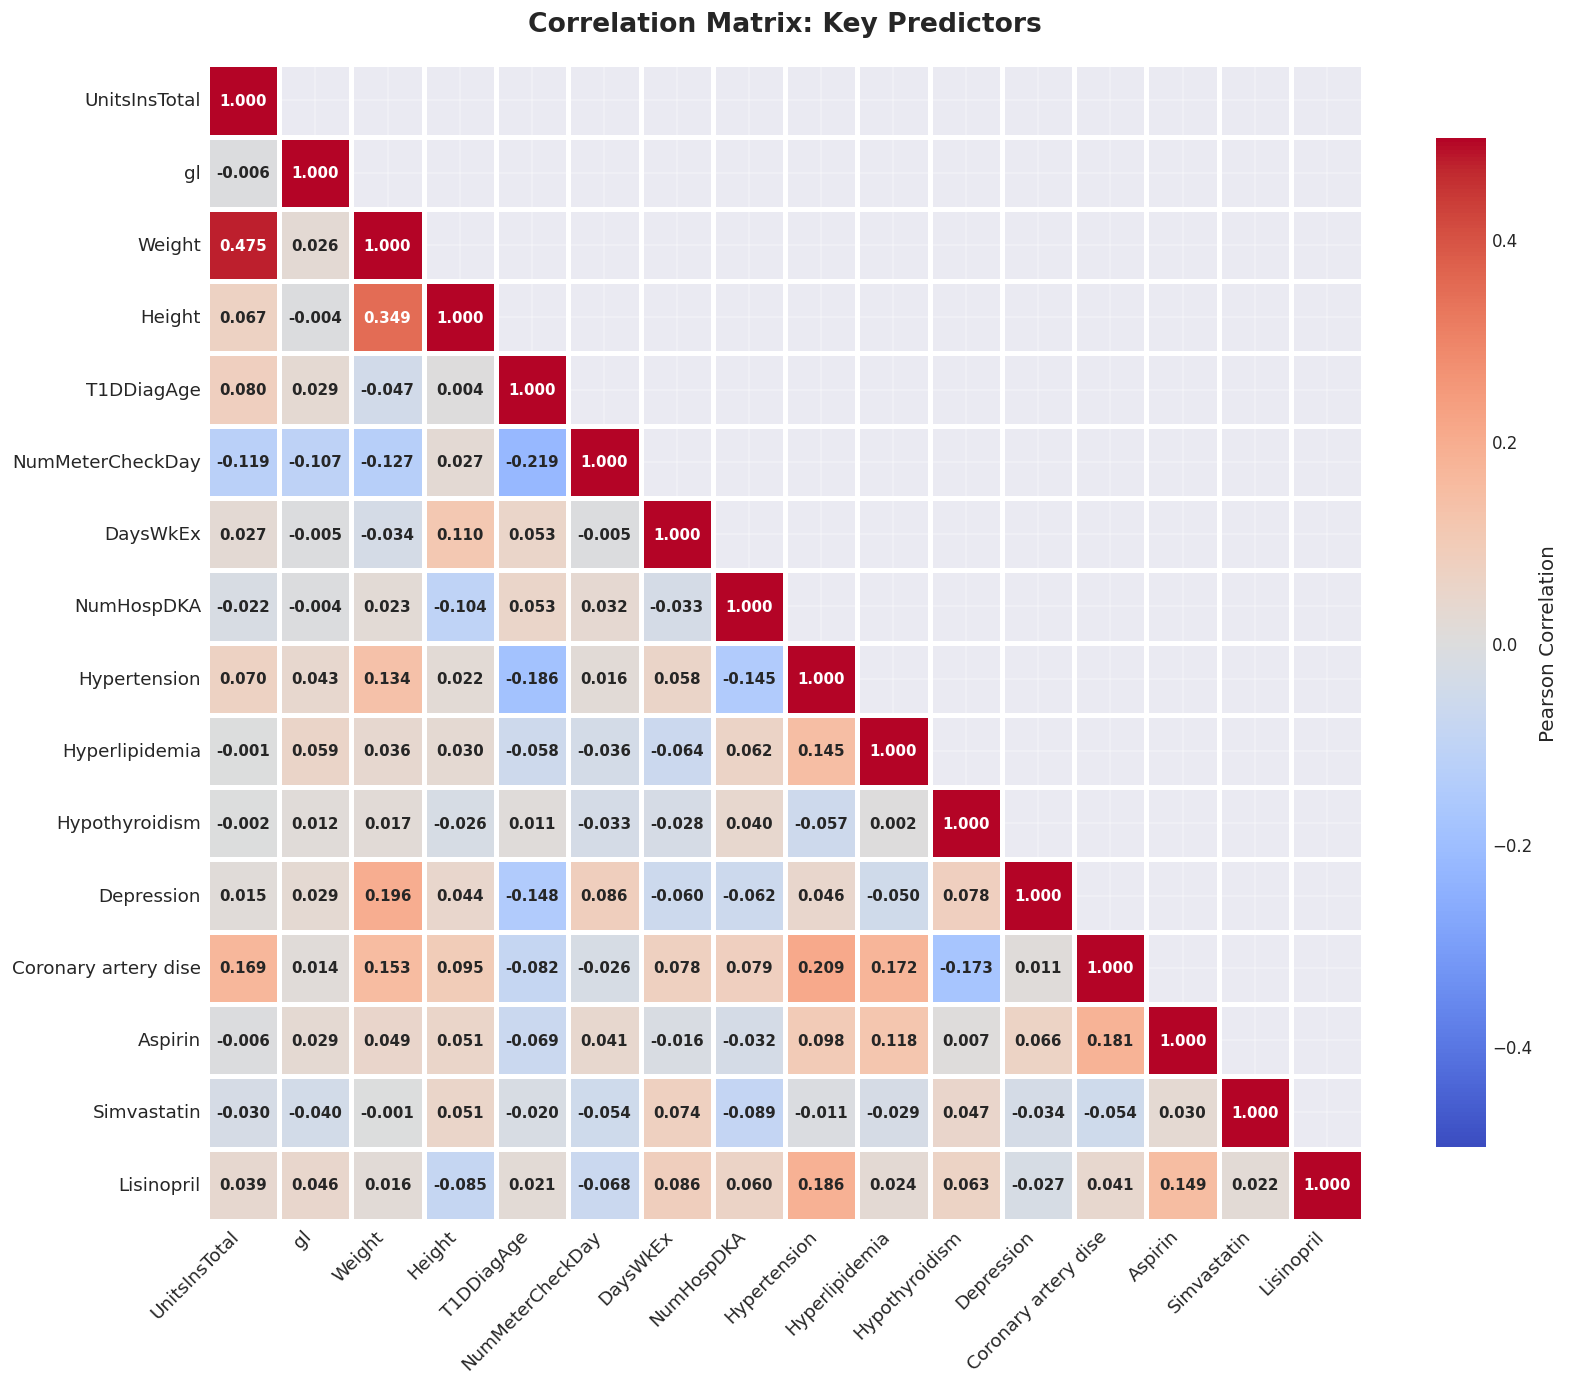

✓ Saved: /content/06_temporal_bivariate.png


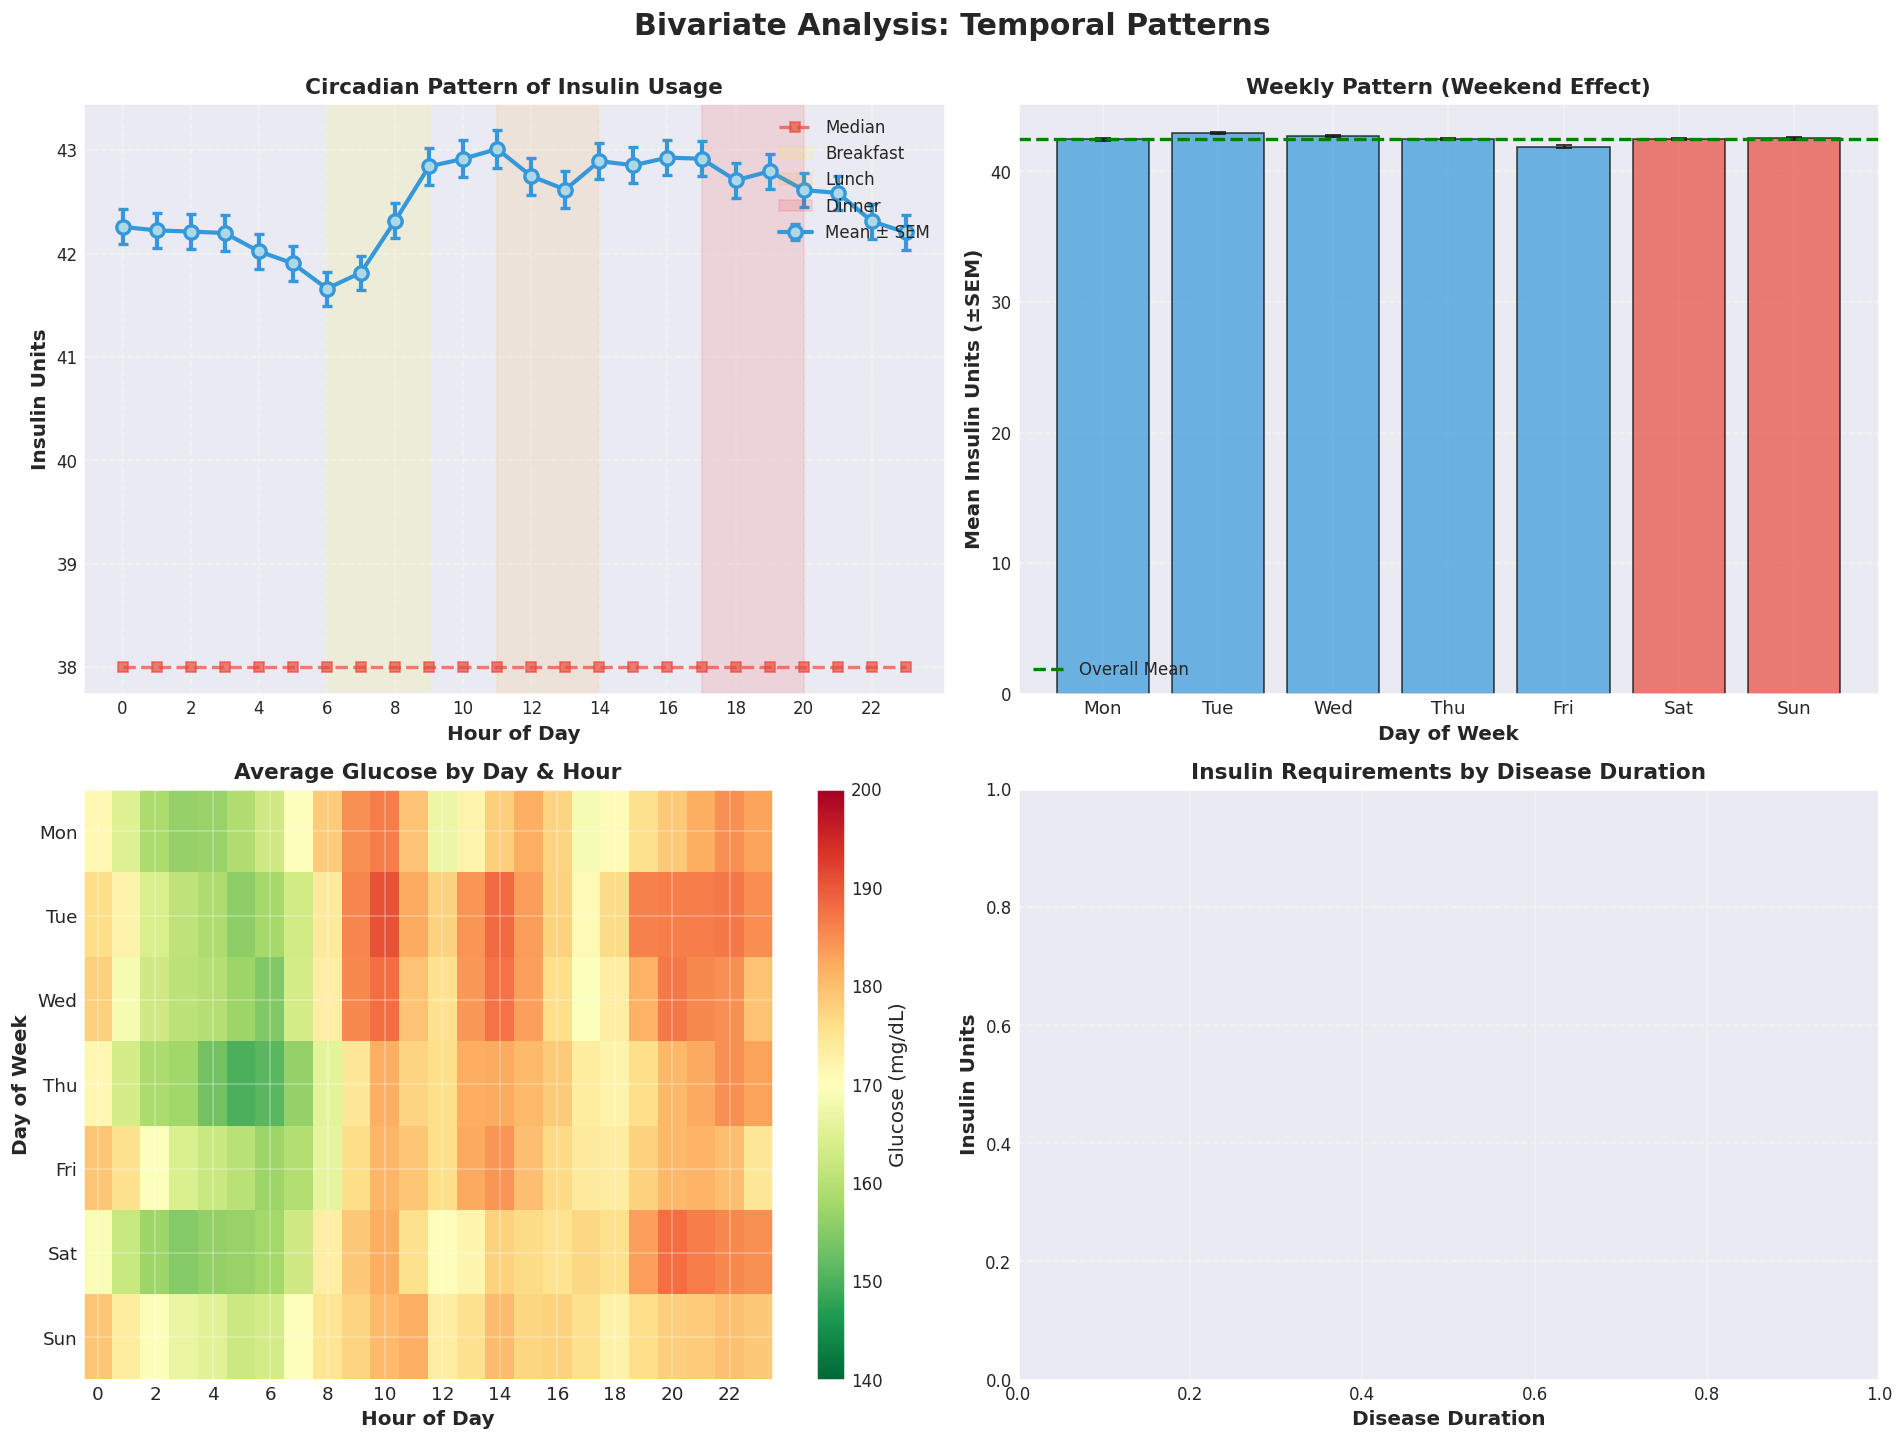


📊 BIVARIATE ANALYSIS SUMMARY

🔝 TOP CORRELATIONS WITH TARGET:
   1. Weight....................................... r =   0.475 (Moderate)
   2. Diabetic_peripheral_neuropathy............... r =   0.193 (Weak)
   3. Coronary_artery_disease...................... r =   0.169 (Weak)
   4. Proliferative_diabetic_retinopathy........... r =   0.157 (Weak)
   5. NumMeterCheckDay............................. r =  -0.119 (Weak)
   6. Erectile_dysfunction......................... r =   0.115 (Weak)
   7. Chronic_kidney_disease....................... r =   0.100 (Weak)
   8. vitamin_D3................................... r =   0.094 (Weak)
   9. Hypercholesterolemia......................... r =   0.084 (Weak)
  10. Dyslipidemia................................. r =  -0.082 (Weak)

✅ BIVARIATE ANALYSIS COMPLETE!



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['grid.alpha'] = 0.3

def create_bivariate_analysis(df, target_col='UnitsInsTotal', output_dir='./plots/', dpi=300):
    import os
    os.makedirs(output_dir, exist_ok=True)

    results = {}
    # Reset index at the very beginning to fix duplicate label issues
    df = df.copy()
    df = df.reset_index(drop=True)

    all_cols = df.columns.tolist()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    comorbidities = [col for col in all_cols
                     if any(kw in col.lower().replace('_', ' ')
                           for kw in ['hypertension', 'hyperlipidemia', 'hypothyroidism',
                                     'depression', 'coronary', 'neuropathy', 'dyslipidemia',
                                     'kidney', 'osteoporosis', 'retinopathy'])]

    medications = [col for col in all_cols
                   if any(kw in col.lower().replace('_', ' ')
                         for kw in ['aspirin', 'simvastatin', 'lisinopril', 'vitamin',
                                   'atorvastatin', 'synthroid', 'omeprazole'])]

    print("\n" + "="*80)
    print("📊 GENERATING BIVARIATE ANALYSIS PLOTS")
    print("="*80)

    # ============================================================================
    # 1. CATEGORICAL vs TARGET
    # ============================================================================
    key_categorical = ['Gender', 'InsDeliveryMethod', 'MaritalStatus', 'Race']
    key_categorical = [col for col in key_categorical if col in df.columns]

    if len(key_categorical) > 0:
        fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig2.suptitle(f'Bivariate Analysis: Categorical Predictors vs {target_col}',
                      fontsize=18, fontweight='bold', y=0.998)
        axes = axes.flatten()

        for idx, predictor in enumerate(key_categorical[:4]):
            ax = axes[idx]
            plot_df = df[[predictor, target_col]].dropna().copy()
            plot_df = plot_df.reset_index(drop=True)
            categories = plot_df[predictor].unique()

            if len(categories) > 10:
                top_cats = plot_df[predictor].value_counts().head(10).index
                plot_df = plot_df[plot_df[predictor].isin(top_cats)].reset_index(drop=True)
                categories = top_cats

            positions = range(len(categories))
            bp = ax.boxplot([plot_df[plot_df[predictor]==cat][target_col].values for cat in categories],
                            positions=positions, widths=0.6, patch_artist=True, showmeans=True,
                            meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                            medianprops=dict(color='darkblue', linewidth=2),
                            boxprops=dict(facecolor='lightblue', alpha=0.7, linewidth=1.5),
                            whiskerprops=dict(linewidth=1.5), capprops=dict(linewidth=1.5))

            if len(categories) == 2:
                group1 = plot_df[plot_df[predictor]==categories[0]][target_col]
                group2 = plot_df[plot_df[predictor]==categories[1]][target_col]
                t_stat, p_value = stats.ttest_ind(group1, group2)
                test_name = 't-test'
            else:
                groups = [plot_df[plot_df[predictor]==cat][target_col].values for cat in categories]
                f_stat, p_value = stats.f_oneway(*groups)
                test_name, t_stat = 'ANOVA', f_stat

            stats_text = f'{test_name}\nStatistic = {t_stat:.3f}\np-value = {p_value:.3e}'
            significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
            stats_text += f'\n({significance})'

            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, edgecolor='gray'))

            ax.set_xticks(positions)
            ax.set_xticklabels([str(cat).replace('_', ' ')[:20] for cat in categories], rotation=45, ha='right')
            ax.set_ylabel(target_col.replace('_', ' ') + ' (units)', fontsize=12, fontweight='bold')
            ax.set_title(f'{predictor.replace("_", " ")} vs Insulin Requirement', fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y', linestyle='--')

        plt.tight_layout()
        plt.savefig(f'{output_dir}01_categorical_bivariate.png', dpi=dpi, bbox_inches='tight')
        print(f"✓ Saved: {output_dir}01_categorical_bivariate.png")
        plt.show()
        plt.close()

    # ============================================================================
    # 2. GLUCOSE vs INSULIN
    # ============================================================================
    fig3, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig3.suptitle('Bivariate Analysis: Glucose-Insulin Relationship', fontsize=18, fontweight='bold', y=0.998)

    ax1 = axes[0, 0]
    sample_idx = np.random.choice(len(df), size=min(15000, len(df)), replace=False)
    sample_df = df.iloc[sample_idx][['gl', target_col]].copy().reset_index(drop=True)

    hexbin = ax1.hexbin(sample_df['gl'], sample_df[target_col], gridsize=30, cmap='YlOrRd', mincnt=1, alpha=0.8)
    z = np.polyfit(sample_df['gl'].values, sample_df[target_col].values, 1)
    x_line = np.linspace(sample_df['gl'].min(), sample_df['gl'].max(), 100)
    ax1.plot(x_line, np.poly1d(z)(x_line), "b-", linewidth=3, label='Linear fit', alpha=0.9)
    ax1.axvline(70, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.axvline(180, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.axvspan(70, 180, alpha=0.1, color='green', label='Target range')

    corr, p_val = pearsonr(sample_df['gl'].values, sample_df[target_col].values)
    ax1.text(0.05, 0.95, f'r = {corr:.3f}\np < {p_val:.3e}', transform=ax1.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    ax1.set_xlabel('Glucose Level (mg/dL)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
    ax1.set_title('Glucose vs Insulin: Overall Relationship', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    plt.colorbar(hexbin, ax=ax1).set_label('Count', fontsize=10)

    ax2 = axes[0, 1]
    hourly_corr = []
    for hour in sorted(df['hour'].unique()):
        hour_df = df[df['hour']==hour][['gl', target_col]].dropna()
        if len(hour_df) > 30:
            corr, _ = pearsonr(hour_df['gl'].values, hour_df[target_col].values)
            hourly_corr.append({'hour': hour, 'correlation': corr})
    hourly_df = pd.DataFrame(hourly_corr)
    colors = plt.cm.RdYlGn_r((hourly_df['correlation'] + 1) / 2)
    ax2.bar(hourly_df['hour'], hourly_df['correlation'], color=colors, alpha=0.8, edgecolor='black')
    ax2.axhline(0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Correlation (Glucose vs Insulin)', fontsize=12, fontweight='bold')
    ax2.set_title('Time-Varying Glucose-Insulin Correlation', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax2.set_ylim([-0.3, 0.3])

    ax3 = axes[1, 0]
    if 'InsDeliveryMethod' in df.columns:
        methods = df['InsDeliveryMethod'].unique()
        colors_method = ['#3498db', '#e74c3c']
        for i, method in enumerate(methods):
            method_data = df[df['InsDeliveryMethod']==method][['gl', target_col]].dropna()
            sample_idx = np.random.choice(len(method_data), size=min(5000, len(method_data)), replace=False)
            method_df = method_data.iloc[sample_idx].copy().reset_index(drop=True)
            ax3.scatter(method_df['gl'], method_df[target_col], alpha=0.3, s=15, label=method, color=colors_method[i])
            z = np.polyfit(method_df['gl'].values, method_df[target_col].values, 1)
            x_line = np.linspace(method_df['gl'].min(), method_df['gl'].max(), 100)
            ax3.plot(x_line, np.poly1d(z)(x_line), color=colors_method[i], linewidth=2.5, alpha=0.9)
        ax3.axvline(70, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
        ax3.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
        ax3.set_xlabel('Glucose Level (mg/dL)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
        ax3.set_title('Glucose vs Insulin by Delivery Method', fontsize=13, fontweight='bold')
        ax3.legend(loc='upper right', framealpha=0.9)
        ax3.grid(True, alpha=0.3, linestyle='--')

    ax4 = axes[1, 1]
    df_temp = df.copy()
    df_temp['glucose_category'] = pd.cut(df_temp['gl'], bins=[0, 70, 140, 180, 250, 500],
        labels=['Hypo\n(<70)', 'Low-Normal\n(70-140)', 'High-Normal\n(140-180)',
                'Mild Hyper\n(180-250)', 'Severe Hyper\n(>250)'])
    glucose_ranges = ['Hypo\n(<70)', 'Low-Normal\n(70-140)', 'High-Normal\n(140-180)',
                     'Mild Hyper\n(180-250)', 'Severe Hyper\n(>250)']
    range_colors = ['#e74c3c', '#f39c12', '#2ecc71', '#f39c12', '#e74c3c']
    available_ranges = [cat for cat in glucose_ranges if cat in df_temp['glucose_category'].values]
    bp = ax4.boxplot([df_temp[df_temp['glucose_category']==cat][target_col].dropna().values for cat in available_ranges],
                     labels=available_ranges, patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                     medianprops=dict(color='darkblue', linewidth=2), widths=0.6)
    for patch, color in zip(bp['boxes'], range_colors[:len(available_ranges)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax4.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Glucose Range', fontsize=12, fontweight='bold')
    ax4.set_title('Insulin Dosing by Glucose Category', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')

    plt.tight_layout()
    plt.savefig(f'{output_dir}02_glucose_insulin_bivariate.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}02_glucose_insulin_bivariate.png")
    plt.show()
    plt.close()

    # ============================================================================
    # 3. COMORBIDITIES & MEDICATIONS
    # ============================================================================
    if comorbidities or medications:
        fig4, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig4.suptitle(f'Bivariate Analysis: Clinical Factors vs {target_col}', fontsize=18, fontweight='bold', y=0.998)

        ax1 = axes[0, 0]
        if comorbidities:
            df_temp = df.copy()
            df_temp['comorbidity_count'] = df[comorbidities].sum(axis=1)
            comorb_stats = df_temp.groupby('comorbidity_count')[target_col].agg(['mean', 'std', 'count']).reset_index()
            x_pos, means = comorb_stats['comorbidity_count'].values, comorb_stats['mean'].values
            sems = comorb_stats['std'].values / np.sqrt(comorb_stats['count'].values)
            ax1.bar(x_pos, means, yerr=sems, capsize=5, alpha=0.7, color='crimson', edgecolor='darkred')
            z = np.polyfit(x_pos, means, 1)
            ax1.plot(x_pos, np.poly1d(z)(x_pos), "b--", linewidth=2.5, label=f'Trend (slope={z[0]:.2f})')
            ax1.set_xlabel('Number of Comorbidities', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
            ax1.set_title('Insulin Requirement vs Comorbidity Burden', fontsize=13, fontweight='bold')
            ax1.legend()
            ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

        ax2 = axes[0, 1]
        if comorbidities:
            top_comorb = comorbidities[:8]
            comorb_means, comorb_names = [], []
            for comorb in top_comorb:
                diff = df[df[comorb]==1][target_col].mean() - df[df[comorb]==0][target_col].mean()
                comorb_means.append(diff)
                comorb_names.append(comorb.replace('_', ' ')[:25])
            sorted_idx = np.argsort(comorb_means)
            comorb_means = [comorb_means[i] for i in sorted_idx]
            comorb_names = [comorb_names[i] for i in sorted_idx]
            colors_diff = ['green' if x < 0 else 'red' for x in comorb_means]
            ax2.barh(range(len(comorb_names)), comorb_means, color=colors_diff, alpha=0.7, edgecolor='black')
            ax2.set_yticks(range(len(comorb_names)))
            ax2.set_yticklabels(comorb_names)
            ax2.set_xlabel('Insulin Difference (Has vs No Comorbidity)', fontsize=12, fontweight='bold')
            ax2.set_title('Impact of Individual Comorbidities', fontsize=13, fontweight='bold')
            ax2.axvline(0, color='black', linestyle='-', linewidth=1.5)
            ax2.grid(True, alpha=0.3, axis='x', linestyle='--')

        ax3 = axes[1, 0]
        if medications:
            df_temp = df.copy()
            df_temp['medication_count'] = df[medications].sum(axis=1)
            med_stats = df_temp.groupby('medication_count')[target_col].agg(['mean', 'std', 'count']).reset_index()
            x_pos, means = med_stats['medication_count'].values, med_stats['mean'].values
            sems = med_stats['std'].values / np.sqrt(med_stats['count'].values)
            ax3.errorbar(x_pos, means, yerr=sems, marker='o', linewidth=2.5, markersize=10,
                        color='steelblue', markerfacecolor='lightblue', capsize=5)
            ax3.set_xlabel('Number of Medications', fontsize=12, fontweight='bold')
            ax3.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
            ax3.set_title('Insulin Requirement vs Medication Count', fontsize=13, fontweight='bold')
            ax3.grid(True, alpha=0.3, linestyle='--')

        ax4 = axes[1, 1]
        if comorbidities and medications:
            df_temp = df.copy()
            df_temp['clinical_burden'] = df[comorbidities].sum(axis=1) + df[medications].sum(axis=1)
            sample_idx = np.random.choice(len(df_temp), size=min(10000, len(df_temp)), replace=False)
            burden_sample = df_temp.iloc[sample_idx][['clinical_burden', target_col]].copy().reset_index(drop=True)
            scatter = ax4.scatter(burden_sample['clinical_burden'], burden_sample[target_col],
                                 alpha=0.3, s=20, c=burden_sample[target_col], cmap='Reds', edgecolors='none')
            z = np.polyfit(burden_sample['clinical_burden'].values, burden_sample[target_col].values, 1)
            x_line = np.linspace(0, burden_sample['clinical_burden'].max(), 100)
            ax4.plot(x_line, np.poly1d(z)(x_line), "b-", linewidth=2.5)
            corr, p_val = pearsonr(burden_sample['clinical_burden'].values, burden_sample[target_col].values)
            ax4.text(0.05, 0.95, f'r = {corr:.3f}\np < {p_val:.3e}', transform=ax4.transAxes, fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
            ax4.set_xlabel('Total Clinical Burden', fontsize=12, fontweight='bold')
            ax4.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
            ax4.set_title('Insulin vs Combined Clinical Burden', fontsize=13, fontweight='bold')
            ax4.grid(True, alpha=0.3, linestyle='--')
            plt.colorbar(scatter, ax=ax4).set_label('Insulin Units')

        plt.tight_layout()
        plt.savefig(f'{output_dir}03_clinical_factors_bivariate.png', dpi=dpi, bbox_inches='tight')
        print(f"✓ Saved: {output_dir}03_clinical_factors_bivariate.png")
        plt.show()
        plt.close()

    # ============================================================================
    # 4. WEIGHT & BMI ANALYSIS
    # ============================================================================
    fig5, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig5.suptitle('Bivariate Analysis: Weight, BMI & Body Composition', fontsize=18, fontweight='bold', y=0.998)

    ax1 = axes[0, 0]
    weight_data = df[(df['Weight'] > 0) & (df[target_col] > 0)][['Weight', target_col, 'Gender']].dropna()
    sample_idx = np.random.choice(len(weight_data), size=min(10000, len(weight_data)), replace=False)
    weight_sample = weight_data.iloc[sample_idx].copy().reset_index(drop=True)

    for gender, color in [('M', '#3498db'), ('F', '#e74c3c')]:
        if gender in weight_sample['Gender'].values:
            gdf = weight_sample[weight_sample['Gender'] == gender]
            ax1.scatter(gdf['Weight'], gdf[target_col], alpha=0.4, s=25, color=color, label=gender)
            z = np.polyfit(gdf['Weight'].values, gdf[target_col].values, 1)
            x_line = np.linspace(gdf['Weight'].min(), gdf['Weight'].max(), 100)
            ax1.plot(x_line, np.poly1d(z)(x_line), color=color, linewidth=2.5, linestyle='--')

    z = np.polyfit(weight_sample['Weight'].values, weight_sample[target_col].values, 1)
    x_line = np.linspace(weight_sample['Weight'].min(), weight_sample['Weight'].max(), 100)
    ax1.plot(x_line, np.poly1d(z)(x_line), "k-", linewidth=3, label='Overall')
    corr, p_val = pearsonr(weight_sample['Weight'].values, weight_sample[target_col].values)
    ax1.text(0.05, 0.95, f'r = {corr:.3f}\nR² = {corr**2:.3f}\nSlope = {z[0]:.2f} units/lb',
            transform=ax1.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    ax1.set_xlabel('Body Weight (lbs)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
    ax1.set_title('Weight vs Insulin Requirement (by Gender)', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3, linestyle='--')

    ax2 = axes[0, 1]
    df_bmi = df[(df['Weight'] > 0) & (df['Height'] > 0)].copy()
    df_bmi['BMI'] = (df_bmi['Weight'] / (df_bmi['Height'] ** 2)) * 703
    df_bmi = df_bmi[(df_bmi['BMI'] > 15) & (df_bmi['BMI'] < 60)]
    sample_idx = np.random.choice(len(df_bmi), size=min(10000, len(df_bmi)), replace=False)
    bmi_sample = df_bmi.iloc[sample_idx][['BMI', target_col]].copy().reset_index(drop=True)

    hexbin = ax2.hexbin(bmi_sample['BMI'], bmi_sample[target_col], gridsize=25, cmap='YlOrRd', mincnt=1, alpha=0.8)
    z = np.polyfit(bmi_sample['BMI'].values, bmi_sample[target_col].values, 1)
    x_line = np.linspace(bmi_sample['BMI'].min(), bmi_sample['BMI'].max(), 100)
    ax2.plot(x_line, np.poly1d(z)(x_line), "b-", linewidth=3)
    ax2.axvline(18.5, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(25, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(30, color='gray', linestyle='--', alpha=0.5)
    corr, p_val = pearsonr(bmi_sample['BMI'].values, bmi_sample[target_col].values)
    ax2.text(0.05, 0.95, f'r = {corr:.3f}\np < {p_val:.3e}', transform=ax2.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    ax2.set_xlabel('BMI (kg/m²)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
    ax2.set_title('BMI vs Insulin Requirement', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    plt.colorbar(hexbin, ax=ax2).set_label('Count')

    ax3 = axes[1, 0]
    df_bmi['BMI_category'] = pd.cut(df_bmi['BMI'], bins=[0, 18.5, 25, 30, 35, 100],
                                    labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+'])
    bmi_cats = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+']
    colors_bmi = ['#3498db', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
    available_cats = [cat for cat in bmi_cats if cat in df_bmi['BMI_category'].values]
    bp = ax3.boxplot([df_bmi[df_bmi['BMI_category']==cat][target_col].dropna().values for cat in available_cats],
                     labels=available_cats, patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='white', markersize=8, markeredgecolor='black'),
                     medianprops=dict(color='black', linewidth=2.5), widths=0.6)
    for patch, color in zip(bp['boxes'], colors_bmi[:len(available_cats)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    groups = [df_bmi[df_bmi['BMI_category']==cat][target_col].dropna().values for cat in available_cats]
    f_stat, p_val = stats.f_oneway(*groups)
    ax3.text(0.02, 0.98, f'ANOVA\nF = {f_stat:.2f}\np < {p_val:.3e}', transform=ax3.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    ax3.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
    ax3.set_xlabel('BMI Category', fontsize=12, fontweight='bold')
    ax3.set_title('Insulin Distribution by BMI Category', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

    ax4 = axes[1, 1]
    hw_data = df[(df['Weight'] > 0) & (df['Height'] > 0)][['Height', 'Weight', target_col]].dropna()
    sample_idx = np.random.choice(len(hw_data), size=min(10000, len(hw_data)), replace=False)
    hw_sample = hw_data.iloc[sample_idx].copy().reset_index(drop=True)
    scatter = ax4.scatter(hw_sample['Height'], hw_sample['Weight'], alpha=0.4, s=30,
                         c=hw_sample[target_col], cmap='coolwarm', edgecolors='none')
    ax4.set_xlabel('Height (inches)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Weight (lbs)', fontsize=12, fontweight='bold')
    ax4.set_title('Body Composition (colored by Insulin)', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--')
    plt.colorbar(scatter, ax=ax4).set_label('Insulin Units')

    plt.tight_layout()
    plt.savefig(f'{output_dir}04_weight_bmi_bivariate.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}04_weight_bmi_bivariate.png")
    plt.show()
    plt.close()

    # ============================================================================
    # 5. CORRELATION MATRIX
    # ============================================================================
    fig6, ax = plt.subplots(figsize=(14, 12))
    key_features = [target_col, 'gl', 'Weight', 'Height', 'T1DDiagAge', 'NumMeterCheckDay', 'DaysWkEx', 'NumHospDKA']
    if comorbidities: key_features.extend(comorbidities[:5])
    if medications: key_features.extend(medications[:3])
    key_features = [col for col in key_features if col in df.columns]
    corr_matrix = df[key_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True,
                linewidths=2, cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"}, vmin=-0.5, vmax=0.5, ax=ax,
                annot_kws={'size': 9, 'weight': 'bold'})
    labels = [col.replace('_', ' ')[:20] for col in key_features]
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=11)
    ax.set_yticklabels(labels, rotation=0, fontsize=11)
    ax.set_title('Correlation Matrix: Key Predictors', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'{output_dir}05_correlation_matrix.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}05_correlation_matrix.png")
    plt.show()
    plt.close()

    # ============================================================================
    # 6. TEMPORAL PATTERNS
    # ============================================================================
    fig7, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig7.suptitle('Bivariate Analysis: Temporal Patterns', fontsize=18, fontweight='bold', y=0.998)

    ax1 = axes[0, 0]
    hourly_stats = df.groupby('hour')[target_col].agg(['mean', 'std', 'count', 'median']).reset_index()
    x, means = hourly_stats['hour'].values, hourly_stats['mean'].values
    sems = hourly_stats['std'].values / np.sqrt(hourly_stats['count'].values)
    medians = hourly_stats['median'].values
    ax1.errorbar(x, means, yerr=sems, fmt='o-', linewidth=2.5, markersize=8, color='#3498db',
                markerfacecolor='lightblue', markeredgewidth=2, capsize=3, label='Mean ± SEM')
    ax1.plot(x, medians, 's--', linewidth=2, markersize=6, color='#e74c3c', label='Median', alpha=0.7)
    ax1.axvspan(6, 9, alpha=0.1, color='yellow', label='Breakfast')
    ax1.axvspan(11, 14, alpha=0.1, color='orange', label='Lunch')
    ax1.axvspan(17, 20, alpha=0.1, color='red', label='Dinner')
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
    ax1.set_title('Circadian Pattern of Insulin Usage', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(0, 24, 2))
    ax1.legend(loc='upper right', framealpha=0.9, fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')

    ax2 = axes[0, 1]
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = df.groupby('weekday')[target_col].agg(['mean', 'std', 'count']).reset_index()
    weekday_stats['order'] = weekday_stats['weekday'].map({day: i for i, day in enumerate(weekday_order)})
    weekday_stats = weekday_stats.sort_values('order')
    x_pos, means = np.arange(len(weekday_stats)), weekday_stats['mean'].values
    sems = weekday_stats['std'].values / np.sqrt(weekday_stats['count'].values)
    weekdays = weekday_stats['weekday'].values
    colors_week = ['#3498db' if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else '#e74c3c' for day in weekdays]
    bars = ax2.bar(x_pos, means, yerr=sems, capsize=5, alpha=0.7, color=colors_week, edgecolor='black')
    ax2.axhline(df[target_col].mean(), color='green', linestyle='--', linewidth=2, label='Overall Mean')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([day[:3] for day in weekdays], fontsize=11)
    ax2.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    ax2.set_title('Weekly Pattern (Weekend Effect)', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

    ax3 = axes[1, 0]
    pivot_data = df.groupby(['hour', 'weekday'])['gl'].mean().unstack(fill_value=np.nan)
    available_days = [day for day in weekday_order if day in pivot_data.columns]
    pivot_data = pivot_data[available_days]
    im = ax3.imshow(pivot_data.T.values, cmap='RdYlGn_r', aspect='auto', vmin=140, vmax=200)
    ax3.set_yticks(range(len(available_days)))
    ax3.set_yticklabels([day[:3] for day in available_days], fontsize=11)
    ax3.set_xticks(range(0, 24, 2))
    ax3.set_xticklabels(range(0, 24, 2), fontsize=11)
    ax3.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Day of Week', fontsize=12, fontweight='bold')
    ax3.set_title('Average Glucose by Day & Hour', fontsize=13, fontweight='bold')
    plt.colorbar(im, ax=ax3).set_label('Glucose (mg/dL)')

    ax4 = axes[1, 1]
    df_temp = df.copy()
    df_temp['disease_duration'] = 2024 - df_temp['T1DDiagAge']
    duration_bins = [0, 10, 20, 30, 40, 50, 100]
    duration_labels = ['<10yr', '10-20yr', '20-30yr', '30-40yr', '40-50yr', '>50yr']
    df_temp['duration_category'] = pd.cut(df_temp['disease_duration'], bins=duration_bins, labels=duration_labels)

    # Get data and labels that actually have values
    box_data = []
    box_labels = []
    for cat in duration_labels:
        cat_data = df_temp[df_temp['duration_category']==cat][target_col].dropna().values
        if len(cat_data) > 0:
            box_data.append(cat_data)
            box_labels.append(cat)

    if len(box_data) > 0:
        bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True, showmeans=True,
                         meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                         medianprops=dict(color='darkblue', linewidth=2), widths=0.6)
        colors_duration = plt.cm.Reds(np.linspace(0.3, 0.9, len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors_duration):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    ax4.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Disease Duration', fontsize=12, fontweight='bold')
    ax4.set_title('Insulin Requirements by Disease Duration', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')

    plt.tight_layout()
    plt.savefig(f'{output_dir}06_temporal_bivariate.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}06_temporal_bivariate.png")
    plt.show()
    plt.close()

    # ============================================================================
    # SUMMARY
    # ============================================================================
    print("\n" + "="*80)
    print("📊 BIVARIATE ANALYSIS SUMMARY")
    print("="*80)
    print("\n🔝 TOP CORRELATIONS WITH TARGET:")
    numeric_corrs = df[numeric_cols].corr()[target_col].drop(target_col).sort_values(key=abs, ascending=False)
    for i, (feature, corr) in enumerate(numeric_corrs.head(10).items(), 1):
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        print(f"  {i:2d}. {feature:.<45} r = {corr:>7.3f} ({strength})")
    print("\n" + "="*80)
    print("✅ BIVARIATE ANALYSIS COMPLETE!")
    print("="*80 + "\n")

    return results

results = create_bivariate_analysis(df, target_col='UnitsInsTotal', output_dir='/content/', dpi=300)


📊 GENERATING ADVANCED EDA PLOTS
📈 Working with 634,534 records
✓ Saved: advanced_01_glucose_bmi_interaction.png


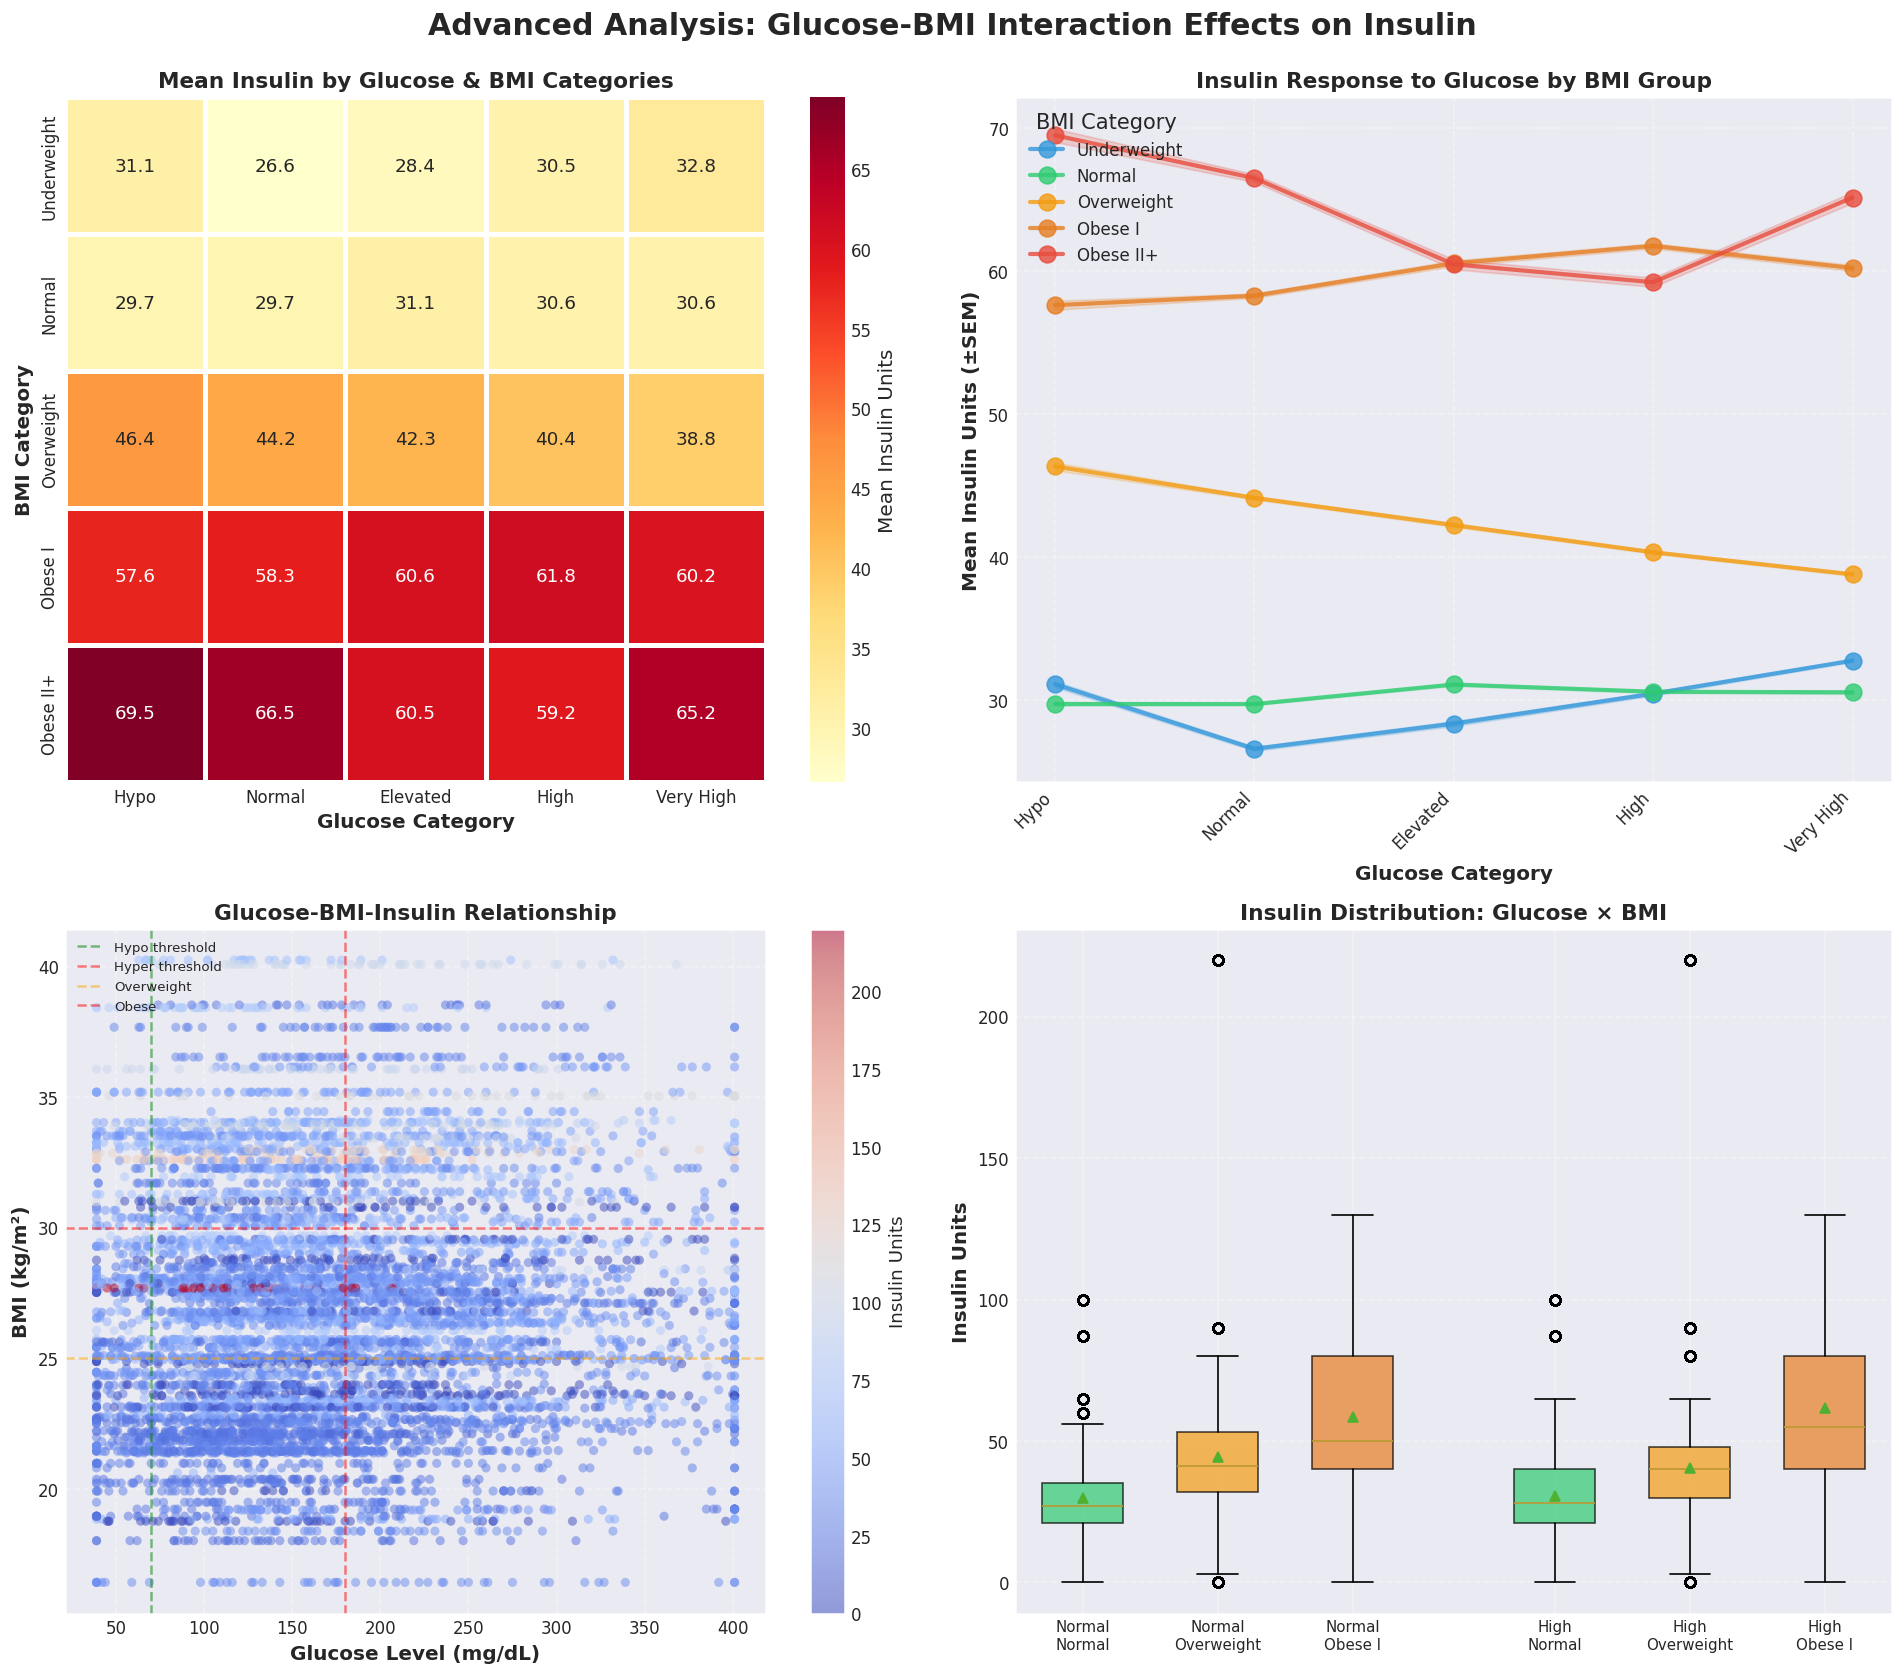

✓ Saved: advanced_02_temporal_patterns.png


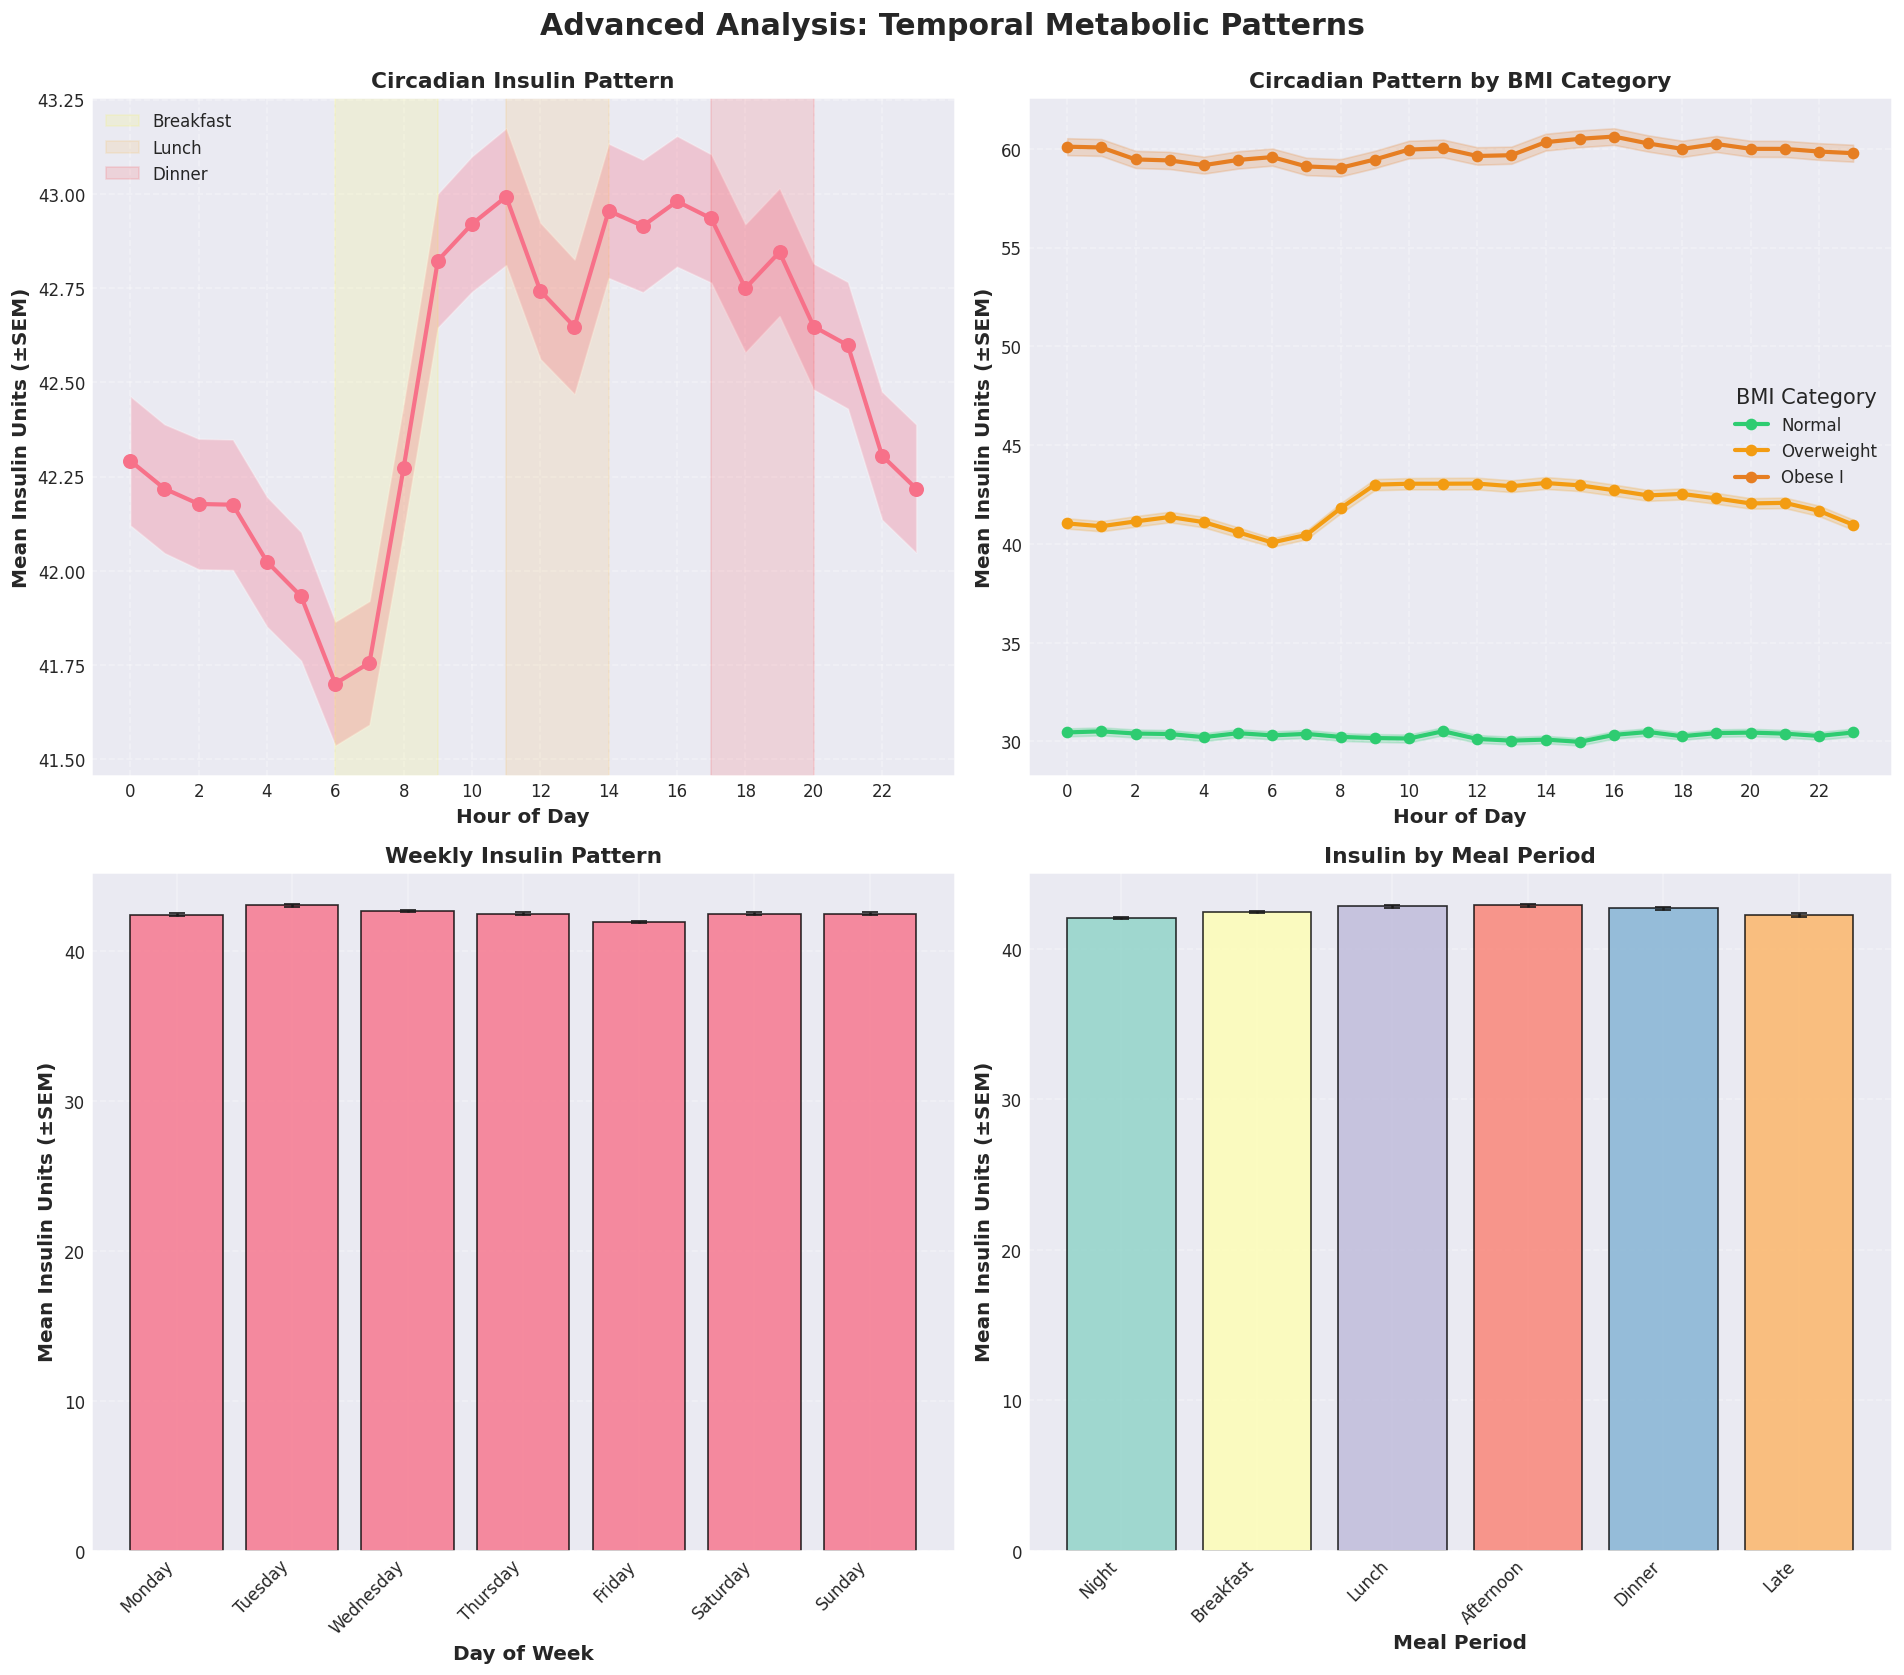

✓ Saved: advanced_03_additional_insights.png


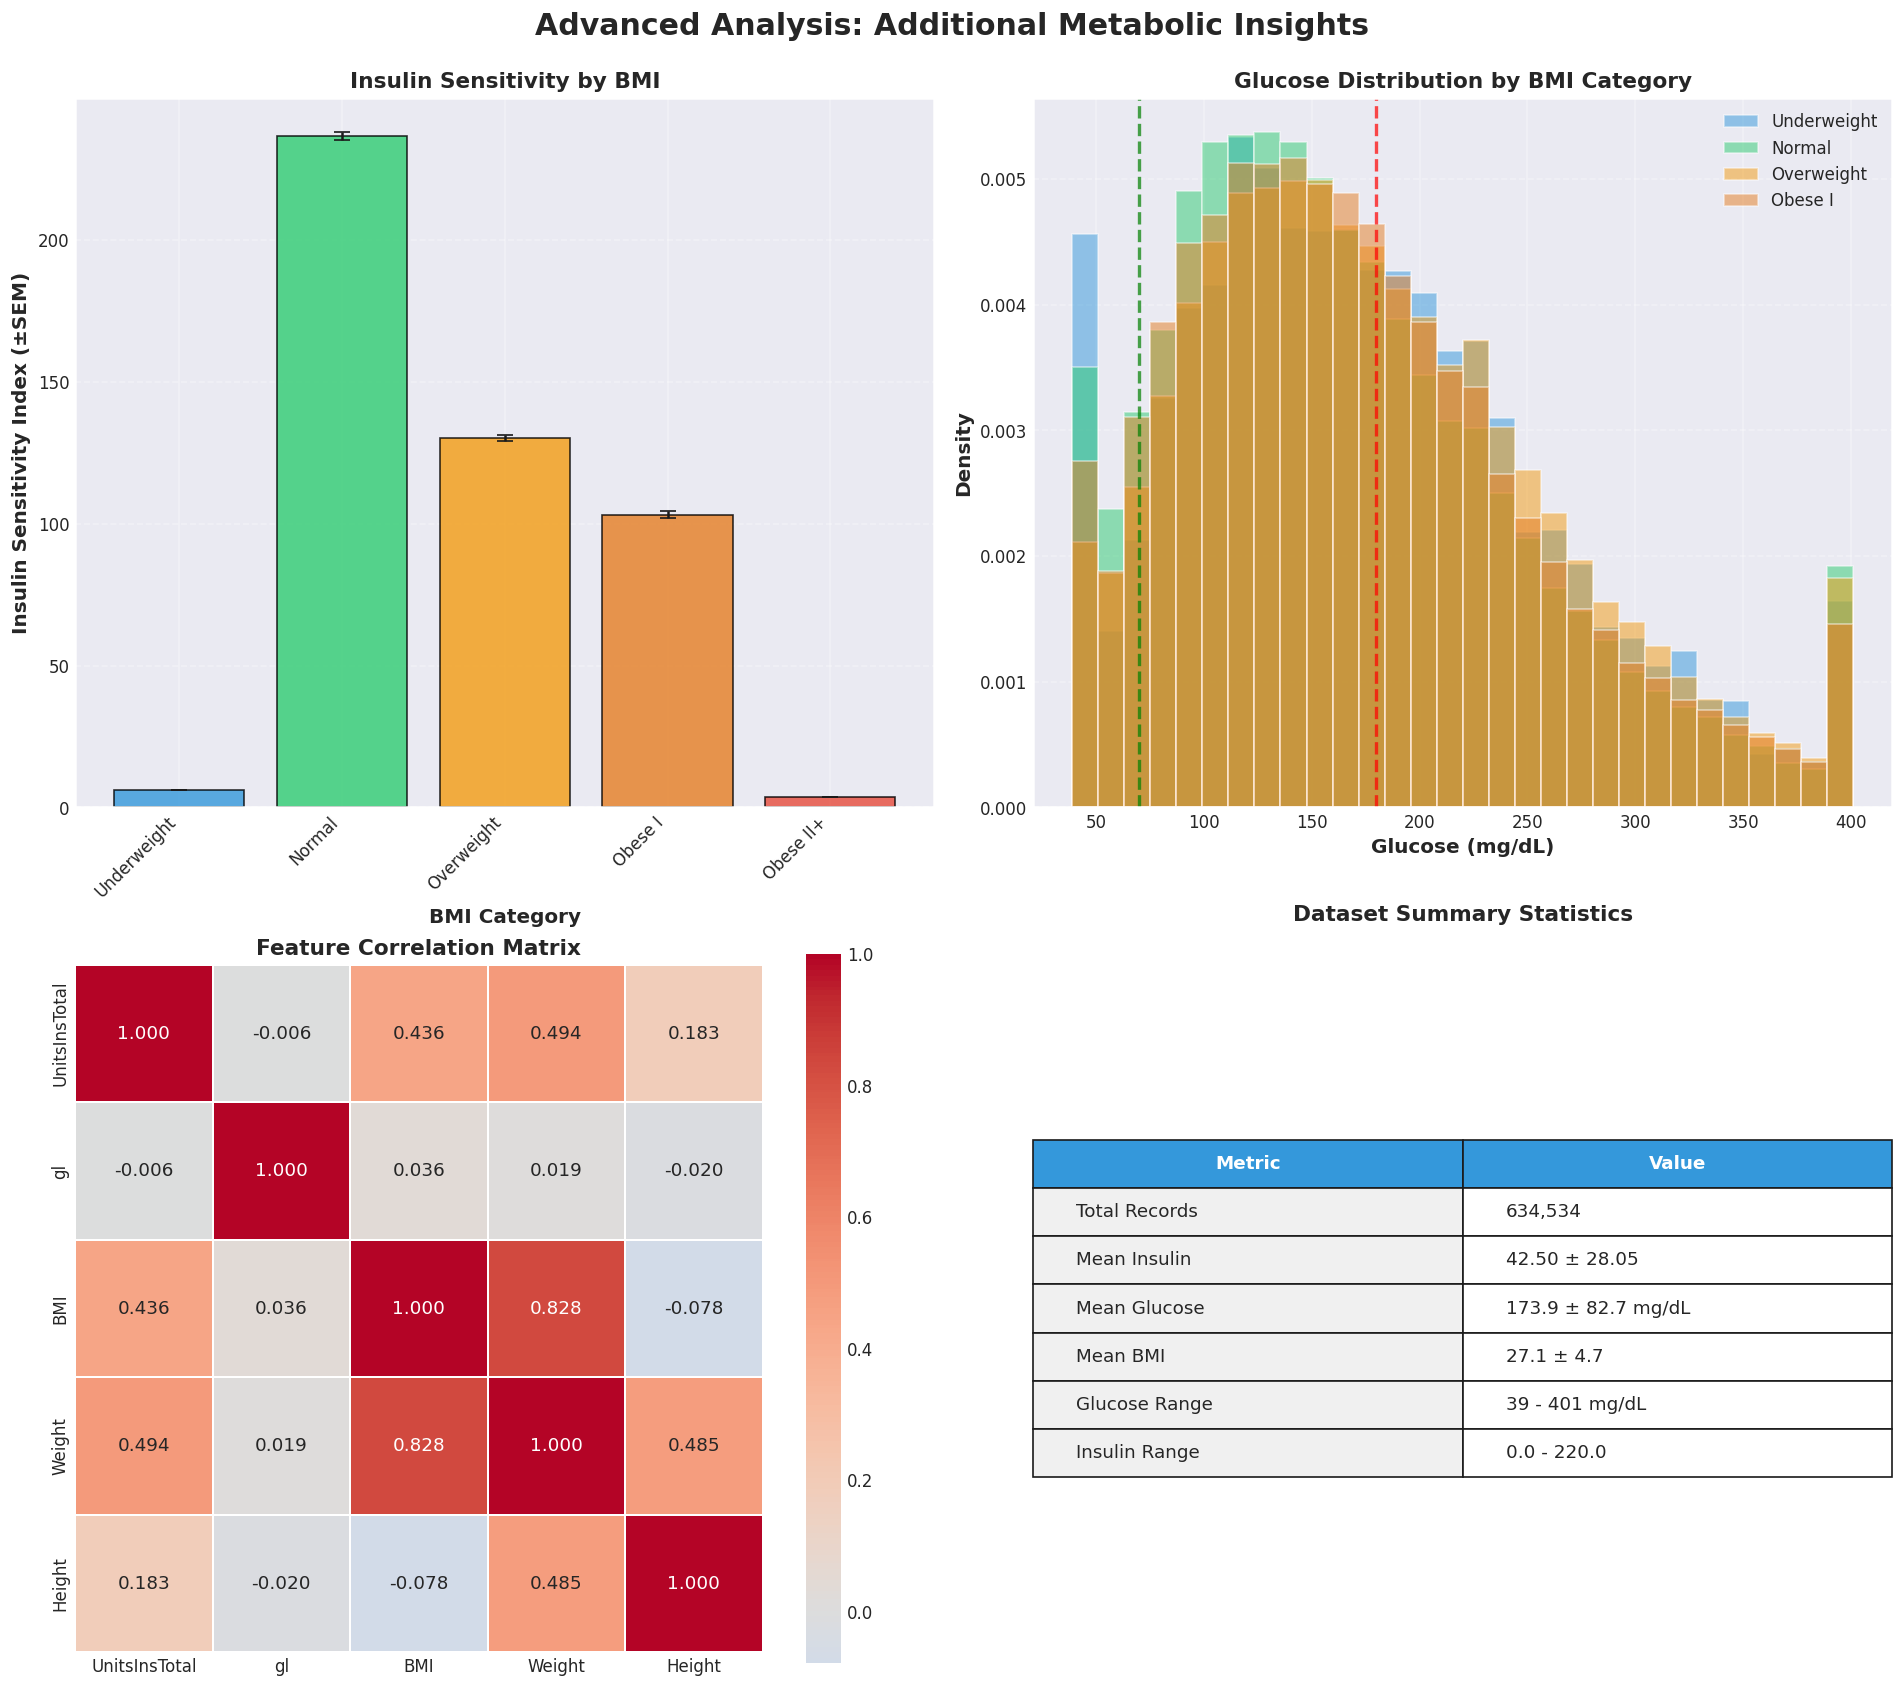


✅ ADVANCED EDA COMPLETE!



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.linewidth'] = 1.5

def create_advanced_eda(df, target_col='UnitsInsTotal', output_dir='/content/', dpi=300):
    import os
    os.makedirs(output_dir, exist_ok=True)

    df = df.copy().reset_index(drop=True)

    # Validate target column exists
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")

    # Calculate BMI with validation
    if 'Weight' in df.columns and 'Height' in df.columns:
        df['BMI'] = (df['Weight'] / (df['Height'] ** 2)) * 703
        df = df[(df['BMI'] > 15) & (df['BMI'] < 60) & df['BMI'].notna()]
    else:
        print("⚠️ Warning: Weight or Height columns missing, skipping BMI calculation")
        return

    # Create glucose categories
    if 'gl' in df.columns:
        df['Glucose_Category'] = pd.cut(df['gl'], bins=[0, 70, 140, 180, 250, 600],
                                         labels=['Hypo', 'Normal', 'Elevated', 'High', 'Very High'])
    else:
        print("⚠️ Warning: 'gl' column missing")
        return

    # Create BMI categories
    df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 35, 100],
                                 labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+'])

    # Remove rows with missing critical data
    df = df.dropna(subset=[target_col, 'gl', 'BMI'])

    if len(df) < 100:
        print(f"⚠️ Warning: Only {len(df)} rows after filtering. Need more data for analysis.")
        return

    print("\n" + "="*80)
    print("📊 GENERATING ADVANCED EDA PLOTS")
    print(f"📈 Working with {len(df):,} records")
    print("="*80)

    # ============================================================================
    # 1. GLUCOSE vs BMI INTERACTION EFFECT ON INSULIN
    # ============================================================================
    try:
        fig1, axes = plt.subplots(2, 2, figsize=(16, 14))
        fig1.suptitle('Advanced Analysis: Glucose-BMI Interaction Effects on Insulin',
                      fontsize=18, fontweight='bold', y=0.995)

        # 1.1 Heatmap: Mean Insulin by Glucose & BMI Categories
        ax1 = axes[0, 0]
        pivot_insulin = df.pivot_table(values=target_col, index='BMI_Category',
                                        columns='Glucose_Category', aggfunc='mean')

        bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+']
        gl_order = ['Hypo', 'Normal', 'Elevated', 'High', 'Very High']

        # Reorder with available categories only
        available_bmi = [x for x in bmi_order if x in pivot_insulin.index]
        available_gl = [x for x in gl_order if x in pivot_insulin.columns]

        if len(available_bmi) > 0 and len(available_gl) > 0:
            pivot_insulin = pivot_insulin.reindex(index=available_bmi, columns=available_gl)

            sns.heatmap(pivot_insulin, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1,
                        cbar_kws={'label': 'Mean Insulin Units'}, linewidths=2, linecolor='white')
            ax1.set_xlabel('Glucose Category', fontsize=12, fontweight='bold')
            ax1.set_ylabel('BMI Category', fontsize=12, fontweight='bold')
            ax1.set_title('Mean Insulin by Glucose & BMI Categories', fontsize=13, fontweight='bold')

        # 1.2 Line Plot: Glucose Effect Across BMI Groups
        ax2 = axes[0, 1]
        colors_bmi = {'Underweight': '#3498db', 'Normal': '#2ecc71', 'Overweight': '#f39c12',
                      'Obese I': '#e67e22', 'Obese II+': '#e74c3c'}

        for bmi_cat in available_bmi:
            bmi_data = df[df['BMI_Category'] == bmi_cat]
            if len(bmi_data) > 10:
                gl_means = bmi_data.groupby('Glucose_Category')[target_col].agg(['mean', 'std', 'count'])
                gl_means = gl_means.reindex([x for x in gl_order if x in gl_means.index])
                gl_means = gl_means.dropna()

                if len(gl_means) > 0:
                    x_pos = range(len(gl_means))
                    ax2.plot(x_pos, gl_means['mean'], 'o-', label=bmi_cat,
                            color=colors_bmi.get(bmi_cat, 'gray'),
                            linewidth=2.5, markersize=10, alpha=0.8)

                    # Add error bars
                    sem = gl_means['std'] / np.sqrt(gl_means['count'])
                    ax2.fill_between(x_pos,
                                    gl_means['mean'] - sem,
                                    gl_means['mean'] + sem,
                                    alpha=0.2, color=colors_bmi.get(bmi_cat, 'gray'))

        ax2.set_xticks(range(len(available_gl)))
        ax2.set_xticklabels(available_gl, rotation=45, ha='right')
        ax2.set_xlabel('Glucose Category', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
        ax2.set_title('Insulin Response to Glucose by BMI Group', fontsize=13, fontweight='bold')
        ax2.legend(title='BMI Category', loc='upper left', framealpha=0.9)
        ax2.grid(True, alpha=0.3, linestyle='--')

        # 1.3 Scatter: Glucose vs BMI vs Insulin
        ax3 = axes[1, 0]
        sample_size = min(8000, len(df))
        sample = df.sample(n=sample_size, random_state=42)

        scatter = ax3.scatter(sample['gl'], sample['BMI'], c=sample[target_col],
                             cmap='coolwarm', alpha=0.5, s=30, edgecolors='none')

        # Add reference lines
        ax3.axvline(70, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Hypo threshold')
        ax3.axvline(180, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Hyper threshold')
        ax3.axhline(25, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, label='Overweight')
        ax3.axhline(30, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Obese')

        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('Insulin Units', fontsize=11)
        ax3.set_xlabel('Glucose Level (mg/dL)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('BMI (kg/m²)', fontsize=12, fontweight='bold')
        ax3.set_title('Glucose-BMI-Insulin Relationship', fontsize=13, fontweight='bold')
        ax3.grid(True, alpha=0.3, linestyle='--')
        ax3.legend(loc='upper left', fontsize=8)

        # 1.4 Box Plot: Insulin Distribution by BMI and Glucose
        ax4 = axes[1, 1]
        df_plot = df[df['Glucose_Category'].isin(['Normal', 'High'])].copy()

        if len(df_plot) > 0:
            plot_data = []
            plot_positions = []
            plot_labels = []
            pos = 0

            for gl_cat in ['Normal', 'High']:
                for bmi_cat in ['Normal', 'Overweight', 'Obese I']:
                    subset = df_plot[(df_plot['Glucose_Category']==gl_cat) &
                                    (df_plot['BMI_Category']==bmi_cat)]
                    if len(subset) > 10:
                        plot_data.append(subset[target_col].values)
                        plot_positions.append(pos)
                        plot_labels.append(f'{gl_cat}\n{bmi_cat}')
                        pos += 1
                pos += 0.5

            if plot_data:
                bp = ax4.boxplot(plot_data, positions=plot_positions, widths=0.6,
                                patch_artist=True, showmeans=True)
                for patch, label in zip(bp['boxes'], plot_labels):
                    bmi_cat = label.split('\n')[1]
                    patch.set_facecolor(colors_bmi.get(bmi_cat, 'gray'))
                    patch.set_alpha(0.7)

                ax4.set_xticks(plot_positions)
                ax4.set_xticklabels(plot_labels, fontsize=9)

        ax4.set_ylabel('Insulin Units', fontsize=12, fontweight='bold')
        ax4.set_title('Insulin Distribution: Glucose × BMI', fontsize=13, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y', linestyle='--')

        plt.tight_layout()
        plt.savefig(f'{output_dir}advanced_01_glucose_bmi_interaction.png', dpi=dpi, bbox_inches='tight')
        print(f"✓ Saved: advanced_01_glucose_bmi_interaction.png")
        plt.show()
        plt.close()

    except Exception as e:
        print(f"⚠️ Error in plot 1: {str(e)}")
        plt.close()

    # ============================================================================
    # 2. TIME-BASED METABOLIC PATTERNS
    # ============================================================================
    if 'hour' in df.columns:
        try:
            fig2, axes = plt.subplots(2, 2, figsize=(16, 14))
            fig2.suptitle('Advanced Analysis: Temporal Metabolic Patterns',
                          fontsize=18, fontweight='bold', y=0.995)

            # 2.1 Hourly Patterns
            ax1 = axes[0, 0]
            hourly_stats = df.groupby('hour')[target_col].agg(['mean', 'std', 'count'])
            hourly_stats['sem'] = hourly_stats['std'] / np.sqrt(hourly_stats['count'])

            ax1.plot(hourly_stats.index, hourly_stats['mean'], 'o-', linewidth=2.5, markersize=8)
            ax1.fill_between(hourly_stats.index,
                            hourly_stats['mean'] - hourly_stats['sem'],
                            hourly_stats['mean'] + hourly_stats['sem'],
                            alpha=0.3)

            ax1.axvspan(6, 9, alpha=0.1, color='yellow', label='Breakfast')
            ax1.axvspan(11, 14, alpha=0.1, color='orange', label='Lunch')
            ax1.axvspan(17, 20, alpha=0.1, color='red', label='Dinner')
            ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
            ax1.set_title('Circadian Insulin Pattern', fontsize=13, fontweight='bold')
            ax1.legend()
            ax1.set_xticks(range(0, 24, 2))
            ax1.grid(True, alpha=0.3, linestyle='--')

            # 2.2 Hourly by BMI
            ax2 = axes[0, 1]
            for bmi_cat in ['Normal', 'Overweight', 'Obese I']:
                bmi_data = df[df['BMI_Category'] == bmi_cat]
                if len(bmi_data) > 50:
                    hourly = bmi_data.groupby('hour')[target_col].agg(['mean', 'std', 'count'])
                    hourly['sem'] = hourly['std'] / np.sqrt(hourly['count'])

                    ax2.plot(hourly.index, hourly['mean'], 'o-', label=bmi_cat,
                            color=colors_bmi.get(bmi_cat, 'gray'), linewidth=2.5, markersize=6)
                    ax2.fill_between(hourly.index,
                                    hourly['mean'] - hourly['sem'],
                                    hourly['mean'] + hourly['sem'],
                                    alpha=0.2, color=colors_bmi.get(bmi_cat, 'gray'))

            ax2.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
            ax2.set_title('Circadian Pattern by BMI Category', fontsize=13, fontweight='bold')
            ax2.legend(title='BMI Category')
            ax2.set_xticks(range(0, 24, 2))
            ax2.grid(True, alpha=0.3, linestyle='--')

            # 2.3 Weekday patterns if available
            if 'weekday' in df.columns:
                ax3 = axes[1, 0]
                weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                available_days = [d for d in weekday_order if d in df['weekday'].values]

                weekday_stats = df.groupby('weekday')[target_col].agg(['mean', 'std', 'count'])
                weekday_stats = weekday_stats.reindex(available_days)
                weekday_stats['sem'] = weekday_stats['std'] / np.sqrt(weekday_stats['count'])

                x_pos = range(len(weekday_stats))
                ax3.bar(x_pos, weekday_stats['mean'], yerr=weekday_stats['sem'],
                       capsize=5, alpha=0.8, edgecolor='black')
                ax3.set_xticks(x_pos)
                ax3.set_xticklabels(weekday_stats.index, rotation=45, ha='right')
                ax3.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
                ax3.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
                ax3.set_title('Weekly Insulin Pattern', fontsize=13, fontweight='bold')
                ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

            # 2.4 Meal periods
            ax4 = axes[1, 1]
            df['meal_period'] = pd.cut(df['hour'], bins=[-1, 6, 10, 14, 18, 21, 24],
                                        labels=['Night', 'Breakfast', 'Lunch', 'Afternoon', 'Dinner', 'Late'])

            meal_stats = df.groupby('meal_period')[target_col].agg(['mean', 'std', 'count'])
            meal_stats['sem'] = meal_stats['std'] / np.sqrt(meal_stats['count'])

            colors_meal = plt.cm.Set3(range(len(meal_stats)))
            x_pos = range(len(meal_stats))

            ax4.bar(x_pos, meal_stats['mean'], yerr=meal_stats['sem'],
                   color=colors_meal, capsize=5, alpha=0.8, edgecolor='black')
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels(meal_stats.index, rotation=45, ha='right')
            ax4.set_xlabel('Meal Period', fontsize=12, fontweight='bold')
            ax4.set_ylabel('Mean Insulin Units (±SEM)', fontsize=12, fontweight='bold')
            ax4.set_title('Insulin by Meal Period', fontsize=13, fontweight='bold')
            ax4.grid(True, alpha=0.3, axis='y', linestyle='--')

            plt.tight_layout()
            plt.savefig(f'{output_dir}advanced_02_temporal_patterns.png', dpi=dpi, bbox_inches='tight')
            print(f"✓ Saved: advanced_02_temporal_patterns.png")
            plt.show()
            plt.close()

        except Exception as e:
            print(f"⚠️ Error in plot 2: {str(e)}")
            plt.close()

    # ============================================================================
    # 3. ADDITIONAL INSIGHTS
    # ============================================================================
    try:
        fig3, axes = plt.subplots(2, 2, figsize=(16, 14))
        fig3.suptitle('Advanced Analysis: Additional Metabolic Insights',
                      fontsize=18, fontweight='bold', y=0.995)

        # 3.1 Insulin sensitivity proxy
        ax1 = axes[0, 0]
        df['insulin_sensitivity'] = df['gl'] / (df[target_col] + 0.1)

        sens_by_bmi = df.groupby('BMI_Category')['insulin_sensitivity'].agg(['mean', 'std', 'count'])
        sens_by_bmi = sens_by_bmi.reindex(available_bmi)
        sens_by_bmi['sem'] = sens_by_bmi['std'] / np.sqrt(sens_by_bmi['count'])

        x_pos = range(len(sens_by_bmi))
        bars = ax1.bar(x_pos, sens_by_bmi['mean'], yerr=sens_by_bmi['sem'],
                      color=[colors_bmi.get(x, 'gray') for x in sens_by_bmi.index],
                      alpha=0.8, capsize=5, edgecolor='black')

        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(sens_by_bmi.index, rotation=45, ha='right')
        ax1.set_xlabel('BMI Category', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Insulin Sensitivity Index (±SEM)', fontsize=12, fontweight='bold')
        ax1.set_title('Insulin Sensitivity by BMI', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

        # 3.2 Glucose distribution by BMI
        ax2 = axes[0, 1]
        for bmi_cat in available_bmi[:4]:  # Limit to 4 categories for clarity
            bmi_data = df[df['BMI_Category'] == bmi_cat]
            if len(bmi_data) > 20:
                ax2.hist(bmi_data['gl'], bins=30, alpha=0.5, label=bmi_cat,
                        color=colors_bmi.get(bmi_cat, 'gray'), density=True)

        ax2.axvline(70, color='green', linestyle='--', linewidth=2, alpha=0.7)
        ax2.axvline(180, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax2.set_xlabel('Glucose (mg/dL)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
        ax2.set_title('Glucose Distribution by BMI Category', fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

        # 3.3 Correlation heatmap
        ax3 = axes[1, 0]
        corr_cols = [target_col, 'gl', 'BMI', 'Weight', 'Height']
        corr_cols = [c for c in corr_cols if c in df.columns]

        if len(corr_cols) >= 3:
            corr_matrix = df[corr_cols].corr()
            sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                       center=0, ax=ax3, square=True, linewidths=1)
            ax3.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')

        # 3.4 Summary statistics table
        ax4 = axes[1, 1]
        ax4.axis('off')

        summary_data = []
        summary_data.append(['Total Records', f'{len(df):,}'])
        summary_data.append(['Mean Insulin', f'{df[target_col].mean():.2f} ± {df[target_col].std():.2f}'])
        summary_data.append(['Mean Glucose', f'{df["gl"].mean():.1f} ± {df["gl"].std():.1f} mg/dL'])
        summary_data.append(['Mean BMI', f'{df["BMI"].mean():.1f} ± {df["BMI"].std():.1f}'])
        summary_data.append(['Glucose Range', f'{df["gl"].min():.0f} - {df["gl"].max():.0f} mg/dL'])
        summary_data.append(['Insulin Range', f'{df[target_col].min():.1f} - {df[target_col].max():.1f}'])

        table = ax4.table(cellText=summary_data,
                         colLabels=['Metric', 'Value'],
                         cellLoc='left',
                         loc='center',
                         colWidths=[0.5, 0.5])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)

        for i in range(len(summary_data) + 1):
            table[(i, 0)].set_facecolor('#f0f0f0')
            table[(i, 1)].set_facecolor('#ffffff')
        table[(0, 0)].set_facecolor('#3498db')
        table[(0, 1)].set_facecolor('#3498db')
        table[(0, 0)].set_text_props(weight='bold', color='white')
        table[(0, 1)].set_text_props(weight='bold', color='white')

        ax4.set_title('Dataset Summary Statistics', fontsize=13, fontweight='bold', pad=20)

        plt.tight_layout()
        plt.savefig(f'{output_dir}advanced_03_additional_insights.png', dpi=dpi, bbox_inches='tight')
        print(f"✓ Saved: advanced_03_additional_insights.png")
        plt.show()
        plt.close()

    except Exception as e:
        print(f"⚠️ Error in plot 3: {str(e)}")
        plt.close()

    print("\n" + "="*80)
    print("✅ ADVANCED EDA COMPLETE!")
    print("="*80 + "\n")

create_advanced_eda(df, target_col='UnitsInsTotal', output_dir='/content/', dpi=300)

## **Feature Engineering and Model Training**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             mean_absolute_percentage_error)
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def create_advanced_features(df):
    """
    Create advanced features for diabetes prediction model

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe

    Returns
    -------
    df_featured : pd.DataFrame
        Dataframe with engineered features
    feature_names : dict
        Dictionary mapping feature groups to column names
    """

    print("\n" + "="*80)
    print("🔧 FEATURE ENGINEERING")
    print("="*80)

    df_featured = df.copy()
    feature_groups = {}

    # ============================================================================
    # 1. BMI CALCULATION
    # ============================================================================
    print("\n📏 Creating BMI features...")
    df_featured['BMI'] = np.where(
        (df_featured['Height'] > 0) & (df_featured['Weight'] > 0),
        (df_featured['Weight'] / (df_featured['Height'] ** 2)) * 703,
        np.nan
    )

    # BMI categories
    df_featured['BMI_category'] = pd.cut(
        df_featured['BMI'],
        bins=[0, 18.5, 25, 30, 35, 100],
        labels=[0, 1, 2, 3, 4]  # Underweight, Normal, Overweight, Obese I, Obese II+
    )

    # Weight status
    df_featured['is_overweight'] = (df_featured['BMI'] >= 25).astype(int)
    df_featured['is_obese'] = (df_featured['BMI'] >= 30).astype(int)

    feature_groups['body_composition'] = ['BMI', 'BMI_category', 'Weight', 'Height',
                                          'is_overweight', 'is_obese']

    print(f"  ✓ Created {len(feature_groups['body_composition'])} body composition features")

    # ============================================================================
    # 2. GLUCOSE FEATURES
    # ============================================================================
    print("\n🩸 Creating glucose features...")

    # Glucose categories
    df_featured['glucose_category'] = pd.cut(
        df_featured['gl'],
        bins=[0, 70, 140, 180, 250, 500],
        labels=[0, 1, 2, 3, 4]  # Hypo, Low-Normal, High-Normal, Mild Hyper, Severe Hyper
    )

    # Binary flags
    df_featured['is_hypoglycemic'] = (df_featured['gl'] < 70).astype(int)
    df_featured['is_hyperglycemic'] = (df_featured['gl'] > 180).astype(int)
    df_featured['is_in_range'] = ((df_featured['gl'] >= 70) & (df_featured['gl'] <= 180)).astype(int)
    df_featured['is_severe_hyper'] = (df_featured['gl'] > 250).astype(int)

    # Glucose deviation from target (125 mg/dL midpoint)
    df_featured['glucose_deviation'] = df_featured['gl'] - 125
    df_featured['glucose_deviation_abs'] = np.abs(df_featured['glucose_deviation'])

    feature_groups['glucose'] = ['gl', 'glucose_category', 'is_hypoglycemic',
                                 'is_hyperglycemic', 'is_in_range', 'is_severe_hyper',
                                 'glucose_deviation', 'glucose_deviation_abs']

    print(f"  ✓ Created {len(feature_groups['glucose'])} glucose features")

    # ============================================================================
    # 3. TEMPORAL FEATURES
    # ============================================================================
    print("\n⏰ Creating temporal features...")

    # Meal periods
    df_featured['meal_period'] = pd.cut(
        df_featured['hour'],
        bins=[-1, 6, 9, 11, 14, 17, 20, 24],
        labels=[0, 1, 2, 3, 4, 5, 6]  # Night, Breakfast, Mid-morning, Lunch, Afternoon, Dinner, Evening
    )

    # Time of day categories
    df_featured['is_morning'] = df_featured['hour'].between(6, 12).astype(int)
    df_featured['is_afternoon'] = df_featured['hour'].between(12, 18).astype(int)
    df_featured['is_evening'] = df_featured['hour'].between(18, 24).astype(int)
    df_featured['is_night'] = df_featured['hour'].between(0, 6).astype(int)

    # Breakfast/lunch/dinner flags
    df_featured['is_breakfast_time'] = df_featured['hour'].between(6, 9).astype(int)
    df_featured['is_lunch_time'] = df_featured['hour'].between(11, 14).astype(int)
    df_featured['is_dinner_time'] = df_featured['hour'].between(17, 20).astype(int)

    # Weekend flag
    df_featured['is_weekend'] = df_featured['weekday'].isin(['Saturday', 'Sunday']).astype(int)

    # Trigonometric encoding for circular time
    df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured['hour'] / 24)
    df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured['hour'] / 24)

    feature_groups['temporal'] = ['hour', 'meal_period', 'is_morning', 'is_afternoon',
                                   'is_evening', 'is_night', 'is_breakfast_time',
                                   'is_lunch_time', 'is_dinner_time', 'is_weekend',
                                   'hour_sin', 'hour_cos']

    print(f"  ✓ Created {len(feature_groups['temporal'])} temporal features")

    # ============================================================================
    # 4. COMORBIDITY & MEDICATION FEATURES
    # ============================================================================
    print("\n🏥 Creating clinical burden features...")

    # Find comorbidity columns
    all_cols = df_featured.columns.tolist()
    comorbidities = [col for col in all_cols
                     if any(kw in col.lower().replace('_', ' ')
                           for kw in ['hypertension', 'hyperlipidemia', 'hypothyroidism',
                                     'depression', 'coronary', 'neuropathy', 'dyslipidemia',
                                     'kidney', 'osteoporosis', 'retinopathy', 'erectile'])]

    medications = [col for col in all_cols
                   if any(kw in col.lower().replace('_', ' ')
                         for kw in ['aspirin', 'simvastatin', 'lisinopril', 'vitamin',
                                   'atorvastatin', 'synthroid', 'omeprazole'])]

    # Aggregate counts
    if comorbidities:
        df_featured['comorbidity_count'] = df_featured[comorbidities].sum(axis=1)
        df_featured['has_cardiovascular'] = df_featured[[col for col in comorbidities
                                                         if 'coronary' in col.lower() or
                                                            'hypertension' in col.lower()]].max(axis=1)
        df_featured['has_metabolic'] = df_featured[[col for col in comorbidities
                                                    if 'lipid' in col.lower() or
                                                       'cholesterol' in col.lower()]].max(axis=1)
    else:
        df_featured['comorbidity_count'] = 0
        df_featured['has_cardiovascular'] = 0
        df_featured['has_metabolic'] = 0

    if medications:
        df_featured['medication_count'] = df_featured[medications].sum(axis=1)
    else:
        df_featured['medication_count'] = 0

    # Total clinical burden
    df_featured['total_clinical_burden'] = (df_featured['comorbidity_count'] +
                                            df_featured['medication_count'])

    # High burden flag
    df_featured['high_clinical_burden'] = (df_featured['total_clinical_burden'] >= 5).astype(int)

    feature_groups['clinical'] = comorbidities + medications + [
        'comorbidity_count', 'medication_count', 'total_clinical_burden',
        'high_clinical_burden', 'has_cardiovascular', 'has_metabolic'
    ]

    print(f"  ✓ Created {len(feature_groups['clinical'])} clinical features")

    # ============================================================================
    # 5. BEHAVIORAL FEATURES
    # ============================================================================
    print("\n🏃 Creating behavioral features...")

    # Exercise patterns
    df_featured['is_active'] = (df_featured['DaysWkEx'] >= 3).astype(int)
    df_featured['exercise_category'] = pd.cut(
        df_featured['DaysWkEx'],
        bins=[-1, 0, 2, 4, 7],
        labels=[0, 1, 2, 3]  # None, Low, Moderate, High
    )

    # Alcohol consumption
    df_featured['alcohol_category'] = pd.cut(
        df_featured['DaysWkDrinkAlc'],
        bins=[-1, 0, 10, 20, 30],
        labels=[0, 1, 2, 3]  # None, Minimal, Moderate, Frequent
    )
    df_featured['has_alcohol_use'] = (df_featured['DaysWkDrinkAlc'] > 0).astype(int)

    # Monitoring adherence
    df_featured['monitoring_adherence'] = pd.cut(
        df_featured['NumMeterCheckDay'],
        bins=[-1, 2, 4, 7, 20],
        labels=[0, 1, 2, 3]  # Low, Moderate, Good, Excellent
    )
    df_featured['good_monitoring'] = (df_featured['NumMeterCheckDay'] >= 4).astype(int)

    feature_groups['behavioral'] = ['DaysWkEx', 'DaysWkDrinkAlc', 'NumMeterCheckDay',
                                     'is_active', 'exercise_category', 'alcohol_category',
                                     'has_alcohol_use', 'monitoring_adherence', 'good_monitoring']

    print(f"  ✓ Created {len(feature_groups['behavioral'])} behavioral features")

    # ============================================================================
    # 6. DISEASE HISTORY FEATURES
    # ============================================================================
    print("\n📅 Creating disease history features...")

    # Age at diagnosis categories
    df_featured['diagnosis_age_category'] = pd.cut(
        df_featured['T1DDiagAge'],
        bins=[0, 10, 18, 30, 45, 100],
        labels=[0, 1, 2, 3, 4]  # Childhood, Adolescent, Young adult, Middle age, Senior
    )

    # Early vs late onset
    df_featured['early_onset'] = (df_featured['T1DDiagAge'] < 18).astype(int)

    # DKA history
    df_featured['has_dka_history'] = (df_featured['NumHospDKA'] > 0).astype(int)

    # Severe hypoglycemia history
    df_featured['severe_hypo_category'] = pd.cut(
        df_featured['NumSHSinceT1DDiag'],
        bins=[-1, 0, 3, 7],
        labels=[0, 1, 2]  # None, Some, Frequent
    )

    feature_groups['disease_history'] = ['T1DDiagAge', 'NumHospDKA', 'NumSHSinceT1DDiag',
                                         'diagnosis_age_category', 'early_onset',
                                         'has_dka_history', 'severe_hypo_category']

    print(f"  ✓ Created {len(feature_groups['disease_history'])} disease history features")

    # ============================================================================
    # 7. INTERACTION FEATURES
    # ============================================================================
    print("\n🔗 Creating interaction features...")

    # BMI × Glucose interaction
    df_featured['bmi_glucose_interaction'] = df_featured['BMI'] * df_featured['gl'] / 1000

    # Weight × Activity interaction
    df_featured['weight_exercise_interaction'] = df_featured['Weight'] * df_featured['DaysWkEx'] / 100

    # Burden × Glucose interaction
    df_featured['burden_glucose_interaction'] = (df_featured['total_clinical_burden'] *
                                                  df_featured['glucose_deviation_abs'])

    # Age × Comorbidity interaction
    df_featured['age_comorbidity_interaction'] = (df_featured['T1DDiagAge'] *
                                                   df_featured['comorbidity_count'])

    feature_groups['interactions'] = ['bmi_glucose_interaction', 'weight_exercise_interaction',
                                      'burden_glucose_interaction', 'age_comorbidity_interaction']

    print(f"  ✓ Created {len(feature_groups['interactions'])} interaction features")

    # ============================================================================
    # 8. ENCODE CATEGORICAL VARIABLES
    # ============================================================================
    print("\n🔢 Encoding categorical variables...")

    # Gender encoding
    df_featured['Gender_encoded'] = (df_featured['Gender'] == 'M').astype(int)

    # Insulin delivery method
    df_featured['InsDeliveryMethod_encoded'] = (df_featured['InsDeliveryMethod'] == 'Pump').astype(int)

    # Race (one-hot encoding for top categories)
    if 'Race' in df_featured.columns:
        race_dummies = pd.get_dummies(df_featured['Race'], prefix='Race', drop_first=True)
        df_featured = pd.concat([df_featured, race_dummies], axis=1)
        race_cols = race_dummies.columns.tolist()
    else:
        race_cols = []

    # Marital status (simplified)
    if 'MaritalStatus' in df_featured.columns:
        df_featured['is_married'] = (df_featured['MaritalStatus'] == 'Married').astype(int)
        marital_cols = ['is_married']
    else:
        marital_cols = []

    # Education level (already numeric)
    feature_groups['demographics'] = ['Gender_encoded', 'InsDeliveryMethod_encoded',
                                      'EduLevel', 'AnnualInc'] + race_cols + marital_cols

    print(f"  ✓ Created {len(feature_groups['demographics'])} demographic features")

    # ============================================================================
    # SUMMARY
    # ============================================================================
    total_features = sum(len(features) for features in feature_groups.values())

    print("\n" + "="*80)
    print("✅ FEATURE ENGINEERING COMPLETE")
    print("="*80)
    print(f"\n📊 Feature Summary:")
    for group, features in feature_groups.items():
        print(f"  • {group.replace('_', ' ').title():.<40} {len(features):>3} features")
    print(f"\n  {'TOTAL':.<40} {total_features:>3} features")
    print("="*80)

    return df_featured, feature_groups


def train_xgboost_model(df, target_col='UnitsInsTotal', test_size=0.2,
                       random_state=42, tune_hyperparameters=True,
                       output_dir='./model_results/'):
    """
    Train and evaluate XGBoost model for insulin prediction

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with features
    target_col : str
        Target variable name
    test_size : float
        Proportion of data for testing
    random_state : int
        Random seed for reproducibility
    tune_hyperparameters : bool
        Whether to perform hyperparameter tuning
    output_dir : str
        Directory to save results

    Returns
    -------
    results : dict
        Dictionary containing model, predictions, and metrics
    """

    import os
    os.makedirs(output_dir, exist_ok=True)

    print("\n" + "="*80)
    print("🚀 XGBOOST MODEL TRAINING")
    print("="*80)

    # ============================================================================
    # 1. FEATURE ENGINEERING
    # ============================================================================
    df_featured, feature_groups = create_advanced_features(df)

    # ============================================================================
    # 2. PREPARE DATA
    # ============================================================================
    print("\n📊 Preparing training data...")

    # Select features (exclude target, ID, time, original categoricals)
    exclude_cols = [target_col, 'id', 'time', 'Gender', 'Race', 'MaritalStatus',
                    'InsDeliveryMethod', 'weekday']

    # Get all numeric features
    numeric_features = df_featured.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_features if col not in exclude_cols]

    # Remove features with too many missing values
    missing_pct = df_featured[feature_cols].isnull().sum() / len(df_featured) * 100
    valid_features = missing_pct[missing_pct < 50].index.tolist()

    print(f"  • Total potential features: {len(feature_cols)}")
    print(f"  • Features after filtering: {len(valid_features)}")

    # Prepare X and y
    X = df_featured[valid_features].copy()
    y = df_featured[target_col].copy()

    # Handle missing values (fill with median)
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)

    # Remove rows where target is missing or zero
    valid_idx = (y.notna()) & (y > 0)
    X = X[valid_idx]
    y = y[valid_idx]

    print(f"  • Final dataset size: {len(X):,} samples")
    print(f"  • Number of features: {X.shape[1]}")
    print(f"  • Target range: [{y.min():.1f}, {y.max():.1f}]")

    # ============================================================================
    # 3. TRAIN-TEST SPLIT
    # ============================================================================
    print(f"\n🔀 Splitting data (test size: {test_size*100:.0f}%)...")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )

    print(f"  • Training set: {len(X_train):,} samples")
    print(f"  • Test set: {len(X_test):,} samples")

    # ============================================================================
    # 4. BASELINE MODEL
    # ============================================================================
    print("\n🏗️  Training baseline XGBoost model...")

    baseline_params = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': random_state,
        'n_jobs': -1
    }

    baseline_model = xgb.XGBRegressor(**baseline_params)
    baseline_model.fit(X_train, y_train)

    # Predictions
    y_train_pred_baseline = baseline_model.predict(X_train)
    y_test_pred_baseline = baseline_model.predict(X_test)

    # Metrics
    train_rmse_baseline = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
    test_rmse_baseline = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))
    train_r2_baseline = r2_score(y_train, y_train_pred_baseline)
    test_r2_baseline = r2_score(y_test, y_test_pred_baseline)

    print(f"\n  Baseline Model Performance:")
    print(f"  • Train RMSE: {train_rmse_baseline:.3f}")
    print(f"  • Test RMSE:  {test_rmse_baseline:.3f}")
    print(f"  • Train R²:   {train_r2_baseline:.3f}")
    print(f"  • Test R²:    {test_r2_baseline:.3f}")

    # ============================================================================
    # 5. HYPERPARAMETER TUNING
    # ============================================================================
    if tune_hyperparameters:
        print("\n🔧 Tuning hyperparameters (this may take a few minutes)...")

        param_grid = {
            'max_depth': [4, 6, 8],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 300],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2]
        }

        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=random_state,
            n_jobs=-1
        )

        # Use RandomizedSearchCV for faster tuning
        from sklearn.model_selection import RandomizedSearchCV

        random_search = RandomizedSearchCV(
            xgb_model,
            param_distributions=param_grid,
            n_iter=20,  # Try 20 random combinations
            cv=3,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            random_state=random_state,
            verbose=1
        )

        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        print(f"\n  ✓ Best parameters found:")
        for param, value in best_params.items():
            print(f"    • {param}: {value}")
    else:
        best_model = baseline_model
        best_params = baseline_params

    # ============================================================================
    # 6. FINAL MODEL EVALUATION
    # ============================================================================
    print("\n📈 Evaluating final model...")

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate comprehensive metrics
    metrics = {
        'train': {
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'mae': mean_absolute_error(y_train, y_train_pred),
            'r2': r2_score(y_train, y_train_pred),
            'mape': mean_absolute_percentage_error(y_train, y_train_pred) * 100
        },
        'test': {
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'mae': mean_absolute_error(y_test, y_test_pred),
            'r2': r2_score(y_test, y_test_pred),
            'mape': mean_absolute_percentage_error(y_test, y_test_pred) * 100
        }
    }

    # Clinical accuracy: within ±10% of actual
    train_within_10pct = np.mean(np.abs(y_train - y_train_pred) / y_train <= 0.1) * 100
    test_within_10pct = np.mean(np.abs(y_test - y_test_pred) / y_test <= 0.1) * 100

    metrics['train']['within_10pct'] = train_within_10pct
    metrics['test']['within_10pct'] = test_within_10pct

    print("\n" + "="*80)
    print("📊 FINAL MODEL PERFORMANCE")
    print("="*80)
    print(f"\n{'Metric':<20} {'Training':<15} {'Testing':<15} {'Difference':<15}")
    print("-" * 80)
    print(f"{'RMSE':<20} {metrics['train']['rmse']:<15.3f} {metrics['test']['rmse']:<15.3f} "
          f"{metrics['test']['rmse'] - metrics['train']['rmse']:<15.3f}")
    print(f"{'MAE':<20} {metrics['train']['mae']:<15.3f} {metrics['test']['mae']:<15.3f} "
          f"{metrics['test']['mae'] - metrics['train']['mae']:<15.3f}")
    print(f"{'R²':<20} {metrics['train']['r2']:<15.3f} {metrics['test']['r2']:<15.3f} "
          f"{metrics['test']['r2'] - metrics['train']['r2']:<15.3f}")
    print(f"{'MAPE (%)':<20} {metrics['train']['mape']:<15.2f} {metrics['test']['mape']:<15.2f} "
          f"{metrics['test']['mape'] - metrics['train']['mape']:<15.2f}")
    print(f"{'Within ±10% (%)':<20} {train_within_10pct:<15.2f} {test_within_10pct:<15.2f} "
          f"{test_within_10pct - train_within_10pct:<15.2f}")
    print("="*80)

    # ============================================================================
    # 7. FEATURE IMPORTANCE
    # ============================================================================
    print("\n🔍 Analyzing feature importance...")

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n  Top 15 Most Important Features:")
    for i, row in feature_importance.head(15).iterrows():
        print(f"    {row['feature']:.<50} {row['importance']:.4f}")

    # ============================================================================
    # 8. CROSS-VALIDATION
    # ============================================================================
    print("\n🔄 Performing cross-validation...")

    cv_scores = cross_val_score(
        best_model, X_train, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    cv_scores = -cv_scores  # Convert back to positive RMSE

    print(f"\n  Cross-Validation Results (5-fold):")
    print(f"    • Mean RMSE: {cv_scores.mean():.3f}")
    print(f"    • Std RMSE:  {cv_scores.std():.3f}")
    print(f"    • Min RMSE:  {cv_scores.min():.3f}")
    print(f"    • Max RMSE:  {cv_scores.max():.3f}")

    # ============================================================================
    # 9. STORE RESULTS
    # ============================================================================
    results = {
        'model': best_model,
        'best_params': best_params,
        'metrics': metrics,
        'feature_importance': feature_importance,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'feature_names': X.columns.tolist(),
        'cv_scores': cv_scores
    }

    print("\n" + "="*80)
    print("✅ MODEL TRAINING COMPLETE")
    print("="*80)

    return results



# ============================================================================
# Train the model
results = train_xgboost_model(df, target_col='UnitsInsTotal',
                              test_size=0.2, tune_hyperparameters=True)


🚀 XGBOOST MODEL TRAINING

🔧 FEATURE ENGINEERING

📏 Creating BMI features...
  ✓ Created 6 body composition features

🩸 Creating glucose features...
  ✓ Created 8 glucose features

⏰ Creating temporal features...
  ✓ Created 12 temporal features

🏥 Creating clinical burden features...
  ✓ Created 26 clinical features

🏃 Creating behavioral features...
  ✓ Created 9 behavioral features

📅 Creating disease history features...
  ✓ Created 7 disease history features

🔗 Creating interaction features...
  ✓ Created 4 interaction features

🔢 Encoding categorical variables...
  ✓ Created 9 demographic features

✅ FEATURE ENGINEERING COMPLETE

📊 Feature Summary:
  • Body Composition........................   6 features
  • Glucose.................................   8 features
  • Temporal................................  12 features
  • Clinical................................  26 features
  • Behavioral..............................   9 features
  • Disease History.........................   7

## **Evaluation results**


📊 GENERATING MODEL VISUALIZATIONS
✓ Saved: ./model_results/01_model_performance.png


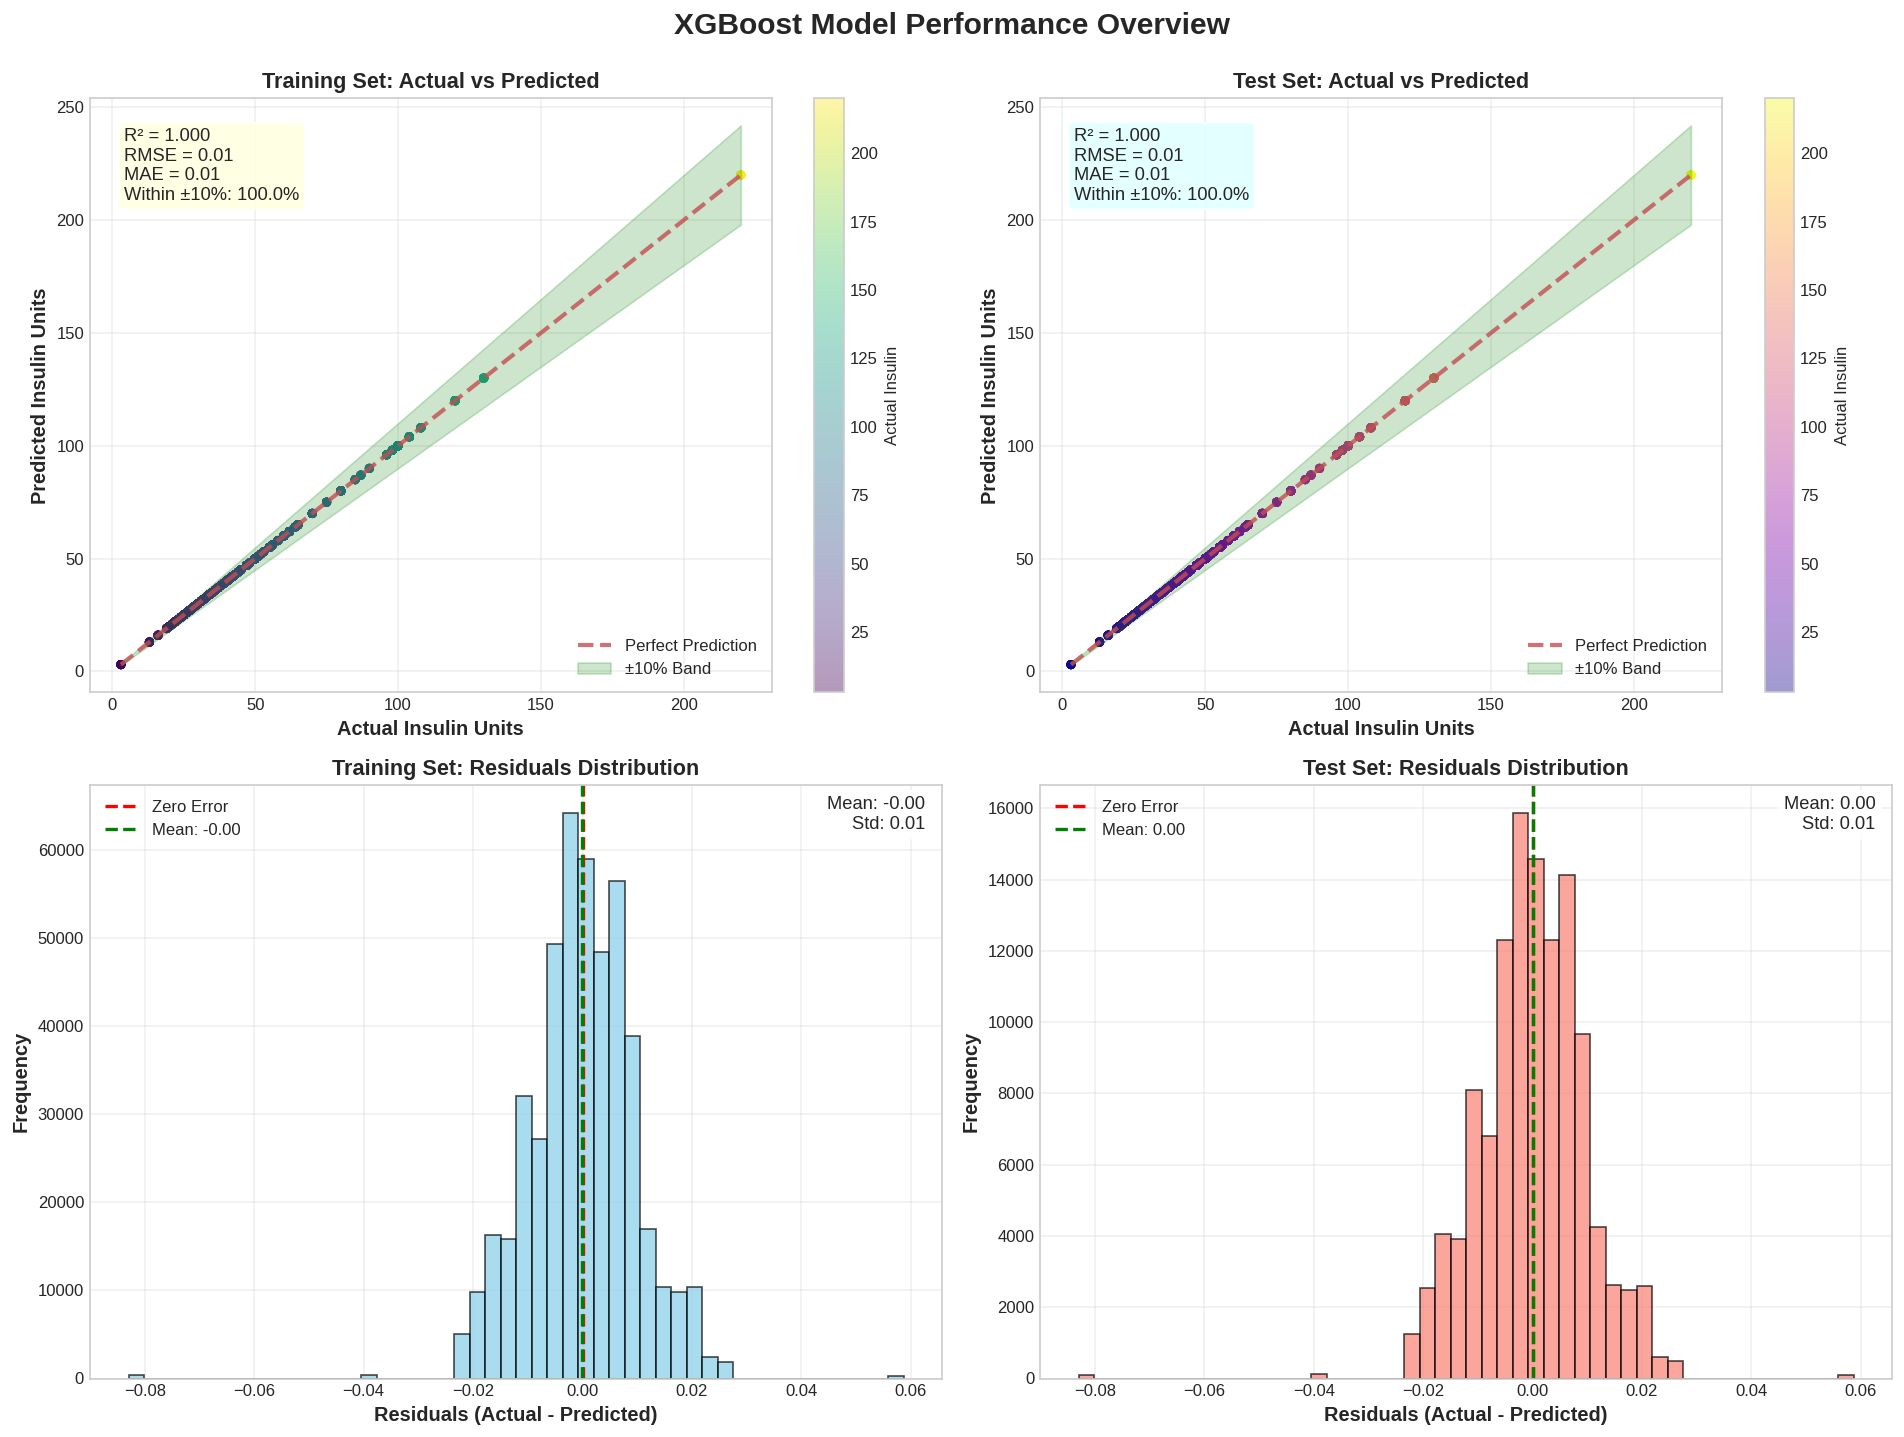

✓ Saved: ./model_results/02_feature_importance.png


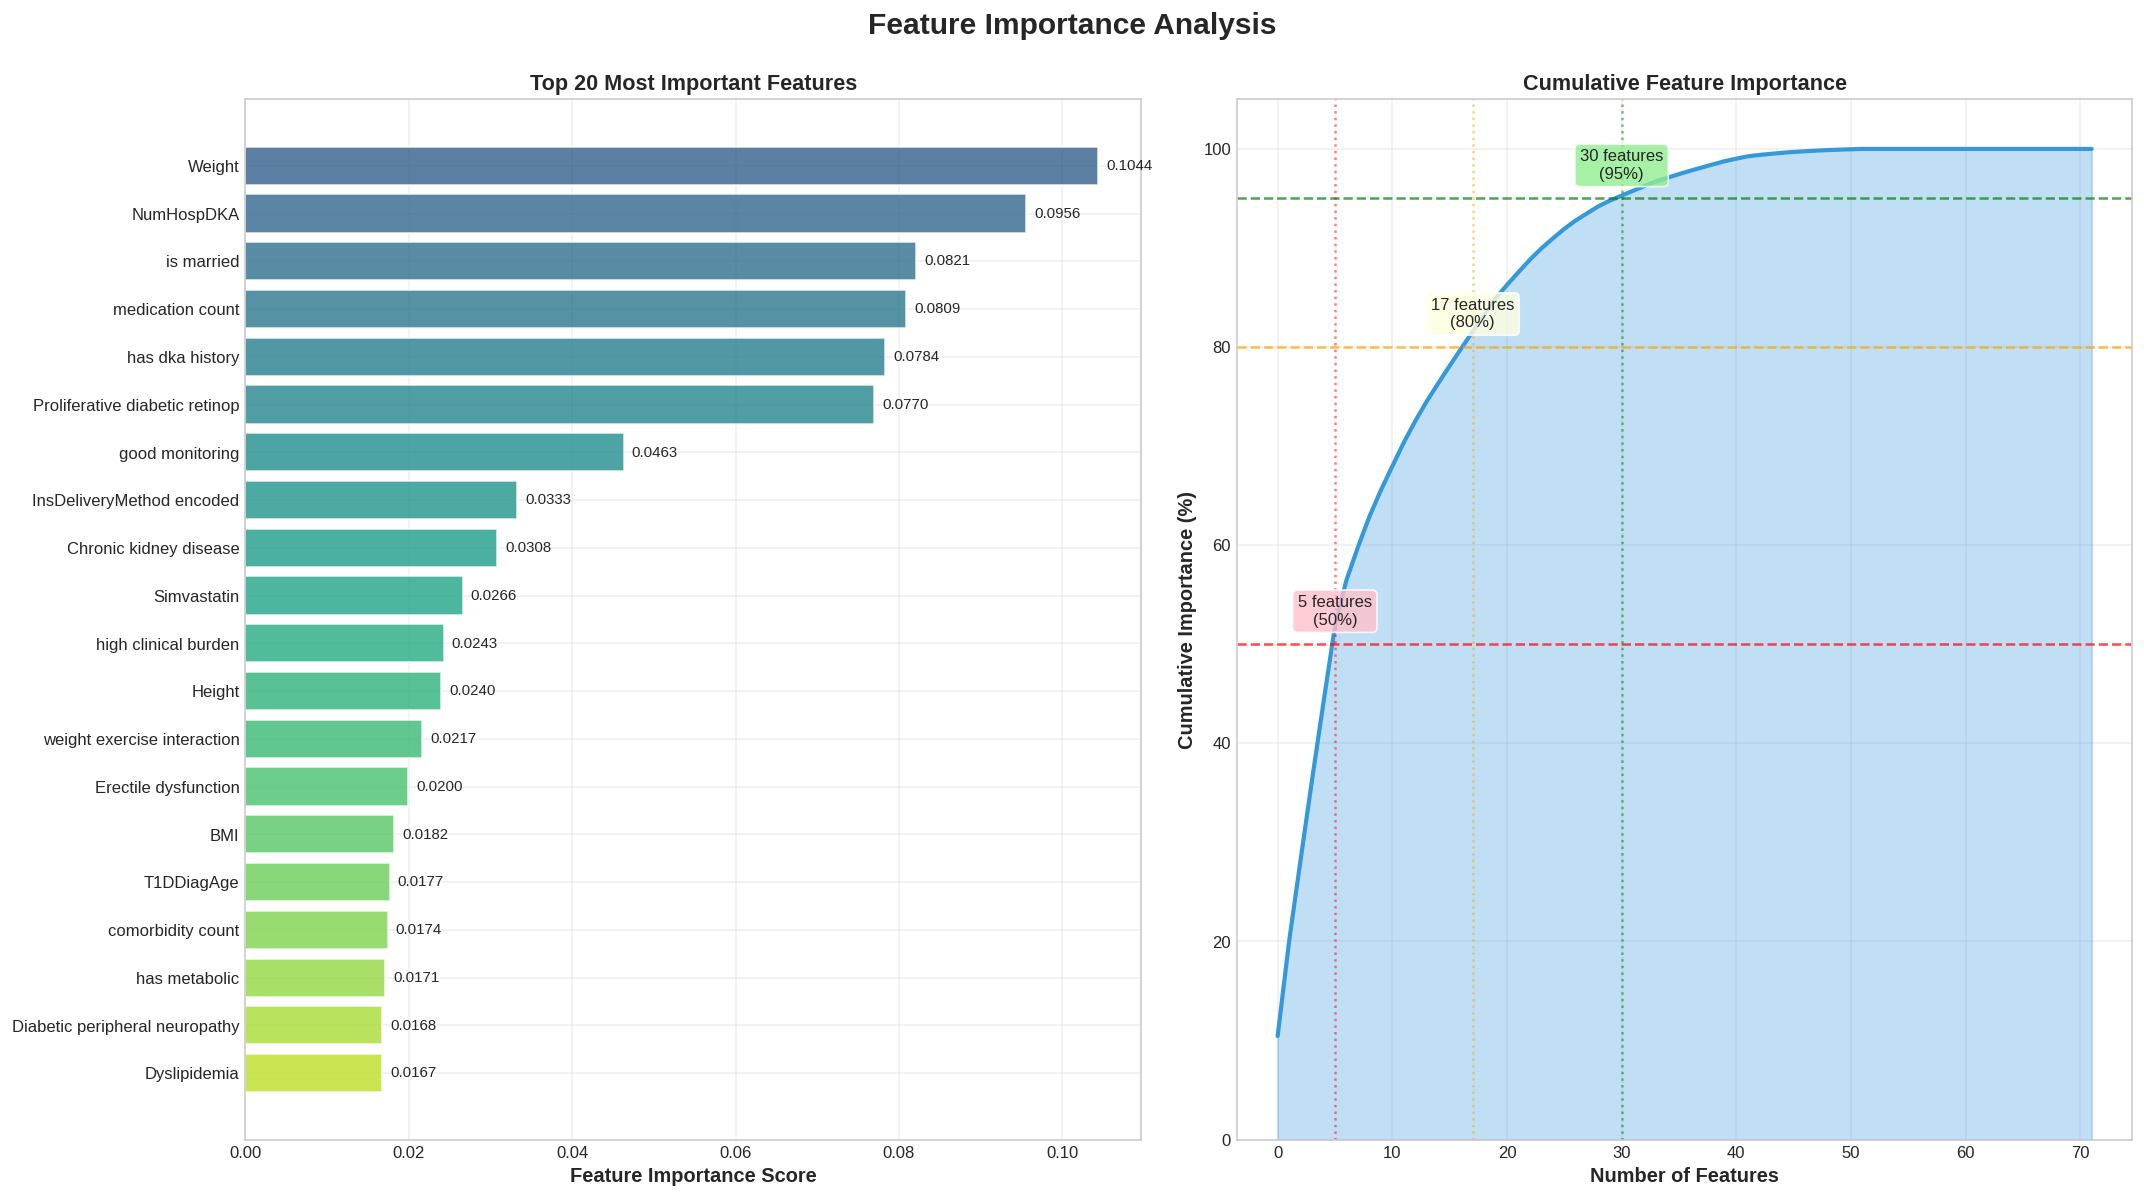

✓ Saved: ./model_results/03_error_analysis.png


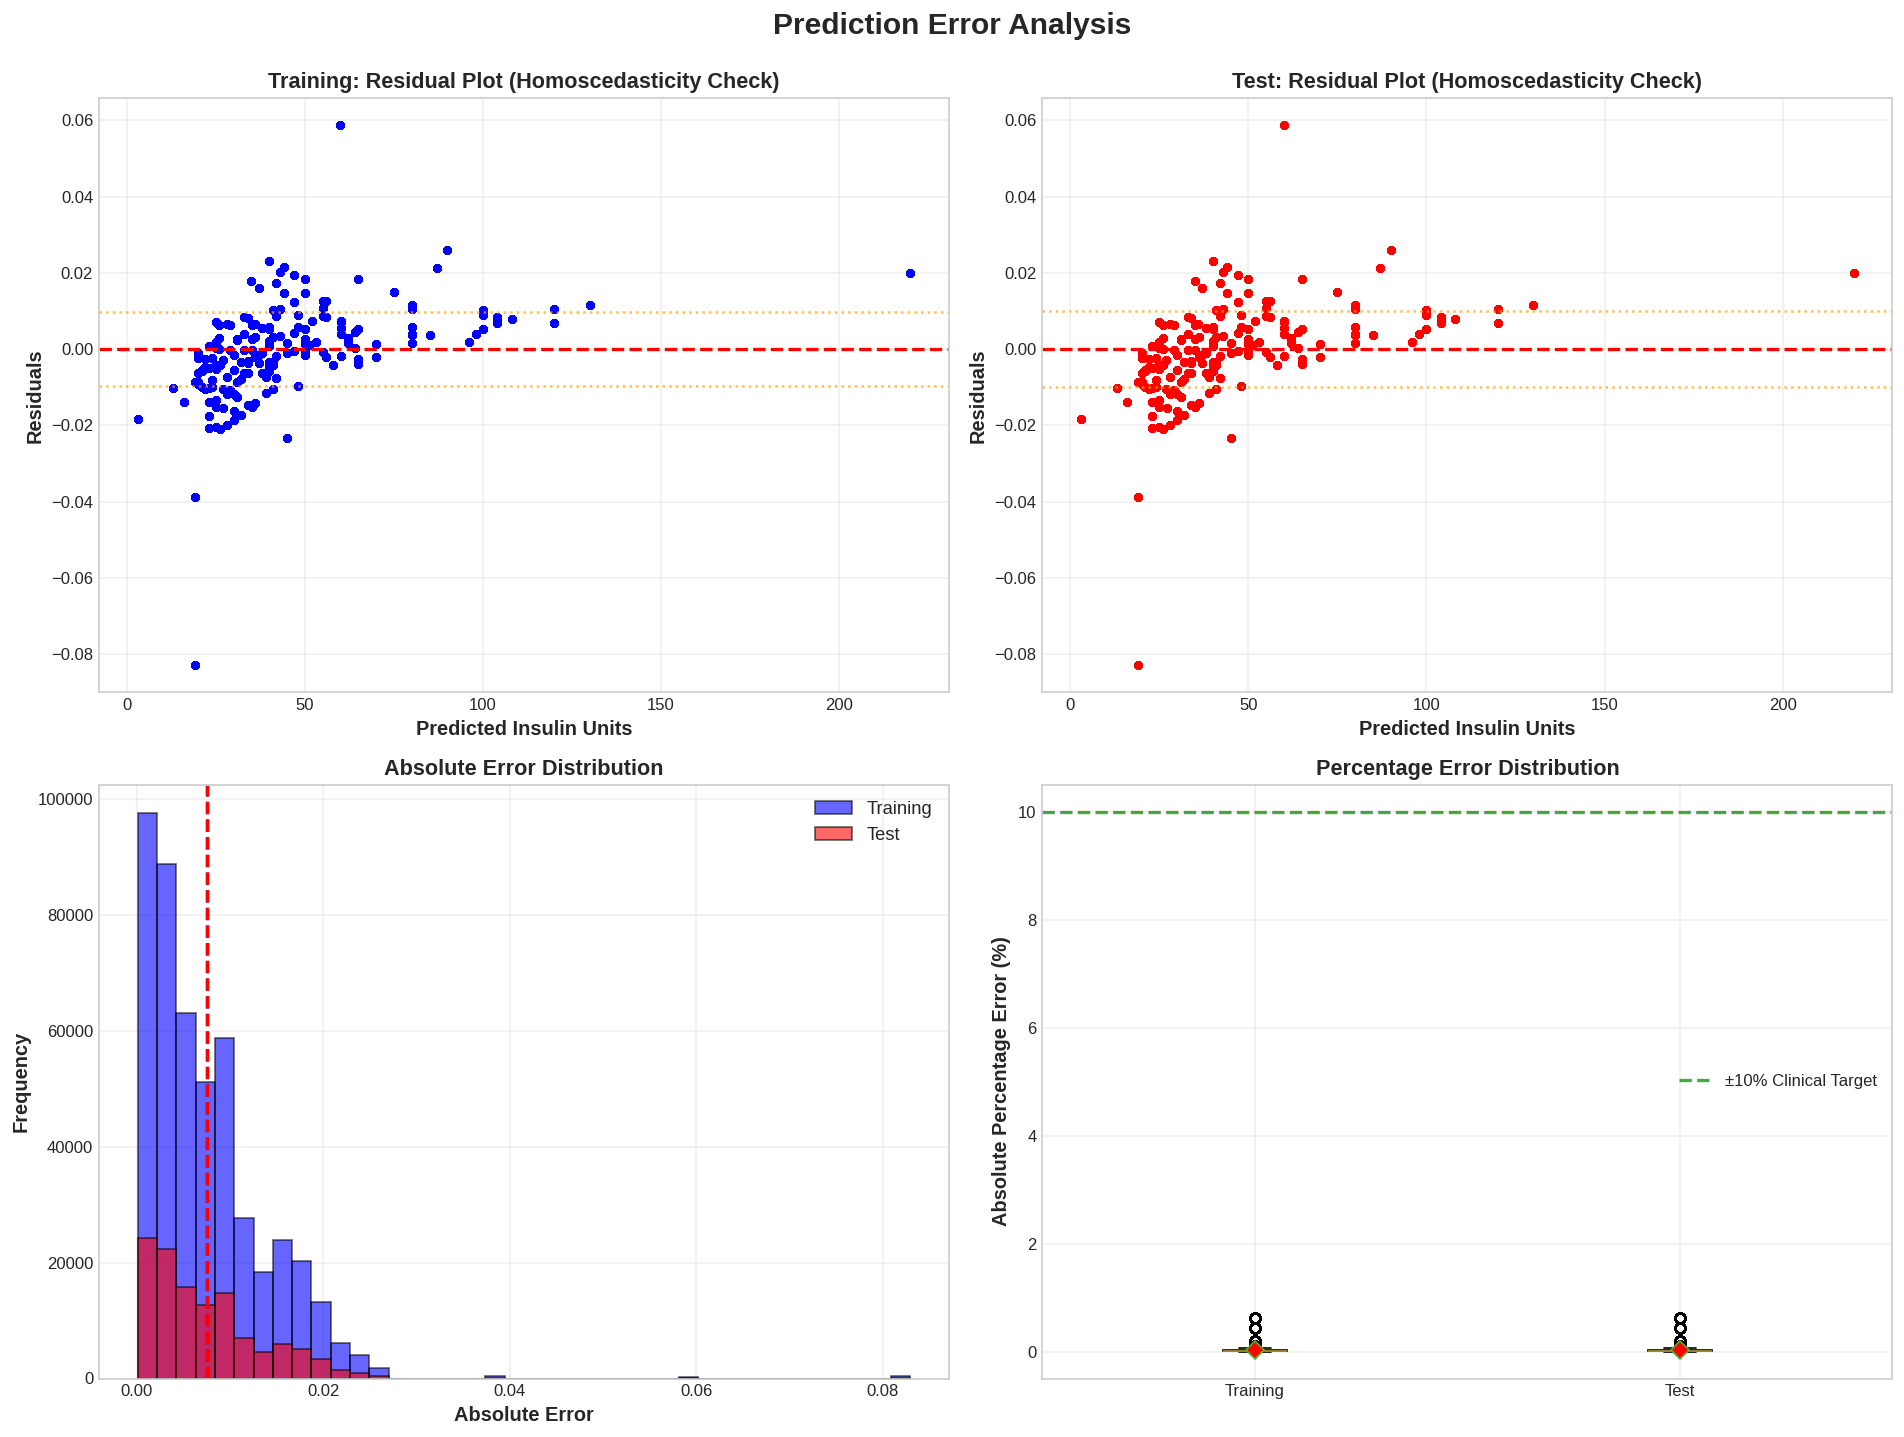

✓ Saved: ./model_results/04_performance_by_range.png


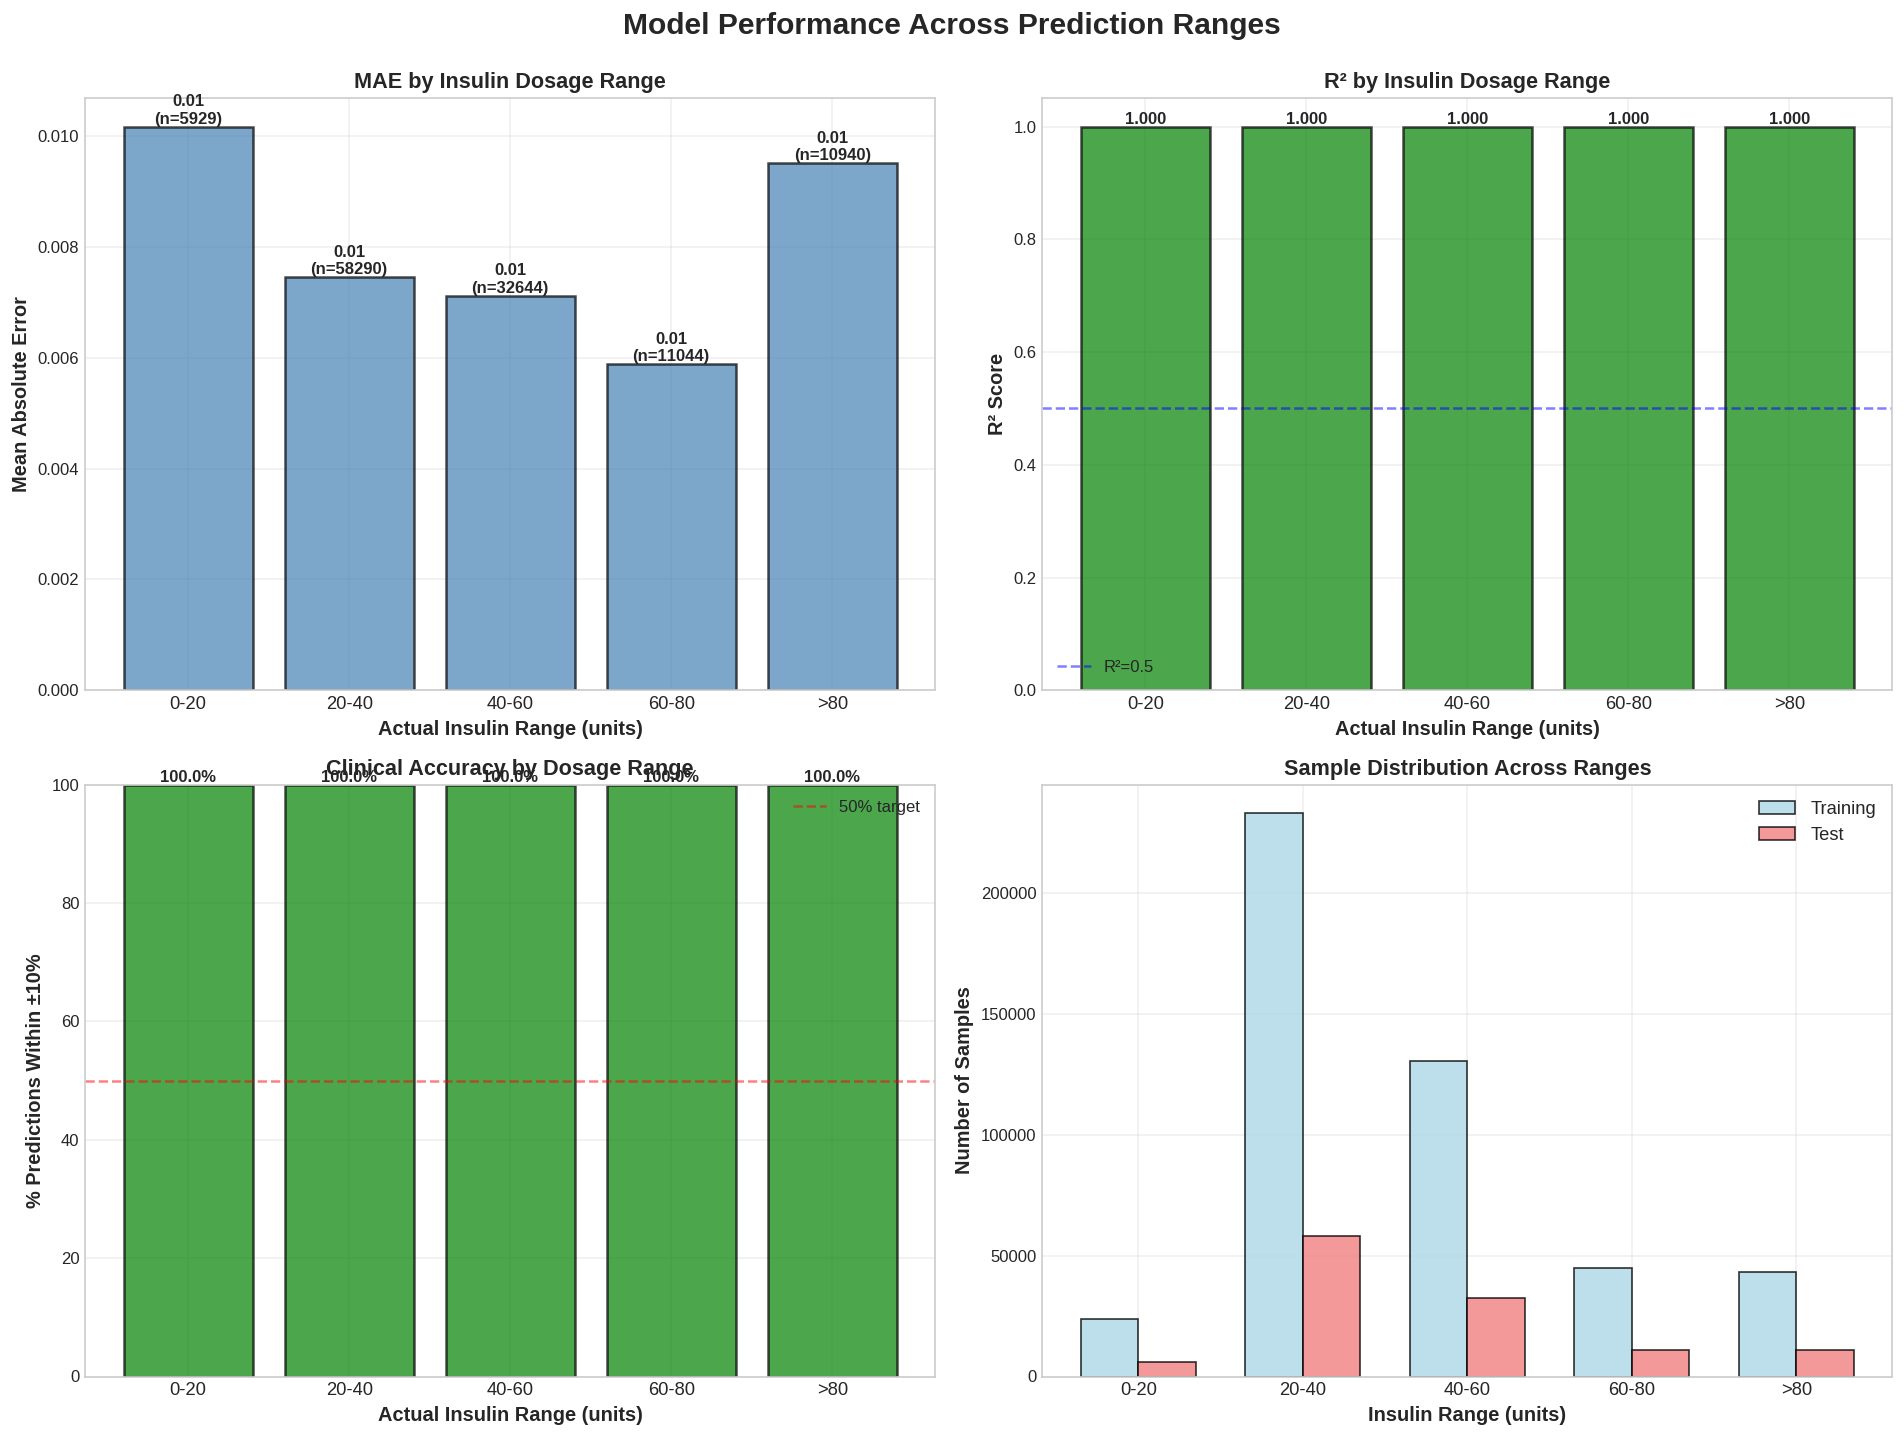


🔍 Calculating SHAP values (this may take a moment)...
✓ Saved: ./model_results/05_shap_analysis.png


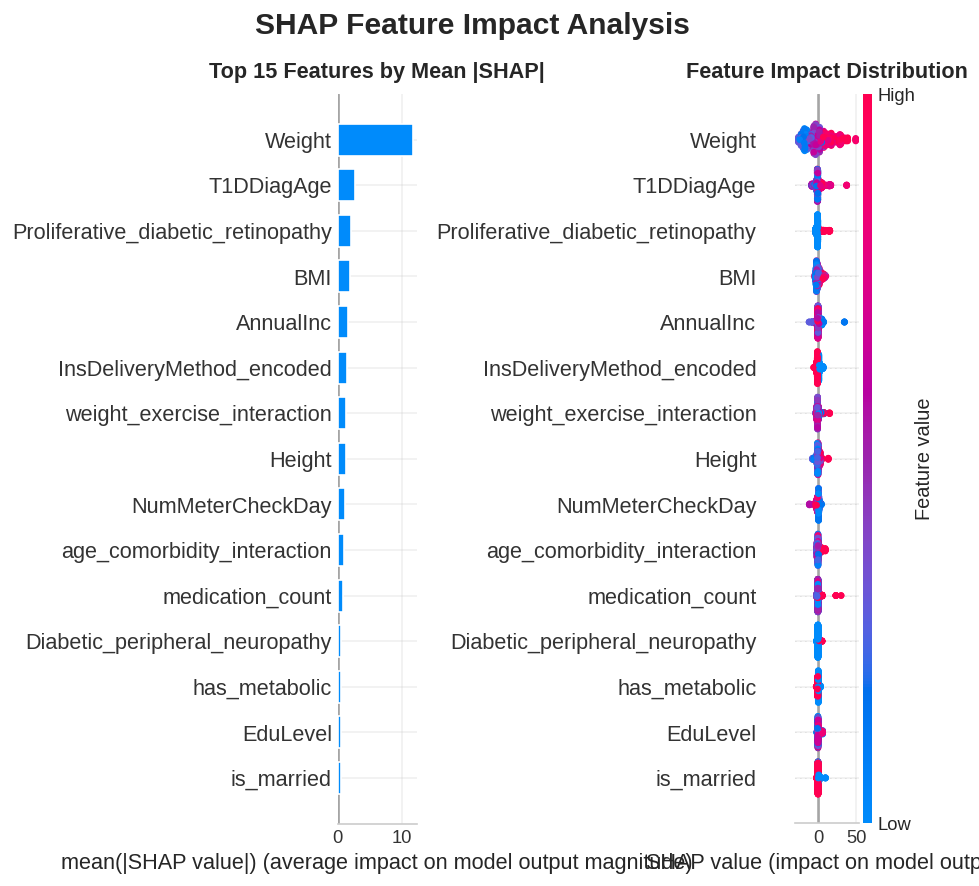


✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY

📁 Files saved in: ./model_results/
  1. 01_model_performance.png
  2. 02_feature_importance.png
  3. 03_error_analysis.png
  4. 04_performance_by_range.png
  5. 05_shap_analysis.png



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def visualize_model_results(results, output_dir='./model_results/', dpi=300):
    """
    Create comprehensive visualizations for XGBoost model results

    Parameters
    ----------
    results : dict
        Results dictionary from train_xgboost_model()
    output_dir : str
        Directory to save plots
    dpi : int
        Resolution for saved images
    """

    import os
    os.makedirs(output_dir, exist_ok=True)

    # Extract results
    model = results['model']
    metrics = results['metrics']
    feature_importance = results['feature_importance']
    X_train = results['X_train']
    X_test = results['X_test']
    y_train = results['y_train']
    y_test = results['y_test']
    y_train_pred = results['y_train_pred']
    y_test_pred = results['y_test_pred']

    print("\n" + "="*80)
    print("📊 GENERATING MODEL VISUALIZATIONS")
    print("="*80)

    # ============================================================================
    # FIGURE 1: MODEL PERFORMANCE OVERVIEW (2x2 grid)
    # ============================================================================
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle('XGBoost Model Performance Overview', fontsize=18, fontweight='bold', y=0.995)

    # 1.1 Actual vs Predicted (Training)
    ax1 = axes[0, 0]

    # Sample for faster plotting
    sample_size = min(5000, len(y_train))
    sample_idx = np.random.choice(len(y_train), sample_size, replace=False)

    scatter = ax1.scatter(y_train.iloc[sample_idx], y_train_pred[sample_idx],
                         alpha=0.4, s=20, c=y_train.iloc[sample_idx], cmap='viridis')

    # Perfect prediction line
    min_val = min(y_train.min(), y_train_pred.min())
    max_val = max(y_train.max(), y_train_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5,
            label='Perfect Prediction', alpha=0.8)

    # ±10% bands
    ax1.fill_between([min_val, max_val],
                     [min_val*0.9, max_val*0.9],
                     [min_val*1.1, max_val*1.1],
                     alpha=0.2, color='green', label='±10% Band')

    # Statistics text
    stats_text = (f"R² = {metrics['train']['r2']:.3f}\n"
                 f"RMSE = {metrics['train']['rmse']:.2f}\n"
                 f"MAE = {metrics['train']['mae']:.2f}\n"
                 f"Within ±10%: {metrics['train']['within_10pct']:.1f}%")

    ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

    ax1.set_xlabel('Actual Insulin Units', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Insulin Units', fontsize=12, fontweight='bold')
    ax1.set_title('Training Set: Actual vs Predicted', fontsize=13, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Actual Insulin', fontsize=10)

    # 1.2 Actual vs Predicted (Testing)
    ax2 = axes[0, 1]

    sample_size_test = min(5000, len(y_test))
    sample_idx_test = np.random.choice(len(y_test), sample_size_test, replace=False)

    scatter2 = ax2.scatter(y_test.iloc[sample_idx_test], y_test_pred[sample_idx_test],
                          alpha=0.4, s=20, c=y_test.iloc[sample_idx_test], cmap='plasma')

    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5,
            label='Perfect Prediction', alpha=0.8)
    ax2.fill_between([min_val, max_val],
                     [min_val*0.9, max_val*0.9],
                     [min_val*1.1, max_val*1.1],
                     alpha=0.2, color='green', label='±10% Band')

    stats_text_test = (f"R² = {metrics['test']['r2']:.3f}\n"
                      f"RMSE = {metrics['test']['rmse']:.2f}\n"
                      f"MAE = {metrics['test']['mae']:.2f}\n"
                      f"Within ±10%: {metrics['test']['within_10pct']:.1f}%")

    ax2.text(0.05, 0.95, stats_text_test, transform=ax2.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9))

    ax2.set_xlabel('Actual Insulin Units', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Predicted Insulin Units', fontsize=12, fontweight='bold')
    ax2.set_title('Test Set: Actual vs Predicted', fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Actual Insulin', fontsize=10)

    # 1.3 Residuals Distribution (Training)
    ax3 = axes[1, 0]

    residuals_train = y_train - y_train_pred

    ax3.hist(residuals_train, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax3.axvline(residuals_train.mean(), color='green', linestyle='--', linewidth=2,
               label=f'Mean: {residuals_train.mean():.2f}')

    # Add statistics
    ax3.text(0.98, 0.98,
            f'Mean: {residuals_train.mean():.2f}\nStd: {residuals_train.std():.2f}',
            transform=ax3.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    ax3.set_xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax3.set_title('Training Set: Residuals Distribution', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # 1.4 Residuals Distribution (Testing)
    ax4 = axes[1, 1]

    residuals_test = y_test - y_test_pred

    ax4.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='salmon')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax4.axvline(residuals_test.mean(), color='green', linestyle='--', linewidth=2,
               label=f'Mean: {residuals_test.mean():.2f}')

    ax4.text(0.98, 0.98,
            f'Mean: {residuals_test.mean():.2f}\nStd: {residuals_test.std():.2f}',
            transform=ax4.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    ax4.set_xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax4.set_title('Test Set: Residuals Distribution', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{output_dir}01_model_performance.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}01_model_performance.png")
    plt.show()

    # ============================================================================
    # FIGURE 2: FEATURE IMPORTANCE (Top 20)
    # ============================================================================
    fig2, axes = plt.subplots(1, 2, figsize=(18, 10))
    fig2.suptitle('Feature Importance Analysis', fontsize=18, fontweight='bold', y=0.995)

    # 2.1 Bar plot of top features
    ax1 = axes[0]

    top_features = feature_importance.head(20)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))

    bars = ax1.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.8)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels([f.replace('_', ' ')[:30] for f in top_features['feature']], fontsize=10)
    ax1.set_xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
    ax1.set_title('Top 20 Most Important Features', fontsize=13, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')

    # Add values on bars
    for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
        ax1.text(val + 0.001, i, f'{val:.4f}', va='center', fontsize=9)

    # 2.2 Cumulative importance
    ax2 = axes[1]

    cumsum = feature_importance['importance'].cumsum()
    cumsum_pct = cumsum / cumsum.iloc[-1] * 100

    ax2.plot(range(len(cumsum_pct)), cumsum_pct, linewidth=2.5, color='#3498db')
    ax2.fill_between(range(len(cumsum_pct)), cumsum_pct, alpha=0.3, color='#3498db')

    # Mark important thresholds
    idx_50 = np.argmax(cumsum_pct >= 50)
    idx_80 = np.argmax(cumsum_pct >= 80)
    idx_95 = np.argmax(cumsum_pct >= 95)

    ax2.axhline(50, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    ax2.axhline(80, color='orange', linestyle='--', alpha=0.7, linewidth=1.5)
    ax2.axhline(95, color='green', linestyle='--', alpha=0.7, linewidth=1.5)

    ax2.axvline(idx_50, color='red', linestyle=':', alpha=0.5)
    ax2.axvline(idx_80, color='orange', linestyle=':', alpha=0.5)
    ax2.axvline(idx_95, color='green', linestyle=':', alpha=0.5)

    ax2.text(idx_50, 52, f'{idx_50} features\n(50%)', ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='pink', alpha=0.8))
    ax2.text(idx_80, 82, f'{idx_80} features\n(80%)', ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax2.text(idx_95, 97, f'{idx_95} features\n(95%)', ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    ax2.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 105])

    plt.tight_layout()
    plt.savefig(f'{output_dir}02_feature_importance.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}02_feature_importance.png")
    plt.show()

    # ============================================================================
    # FIGURE 3: ERROR ANALYSIS (2x2 grid)
    # ============================================================================
    fig3, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig3.suptitle('Prediction Error Analysis', fontsize=18, fontweight='bold', y=0.995)

    # 3.1 Residuals vs Predicted (Training)
    ax1 = axes[0, 0]

    ax1.scatter(y_train_pred, residuals_train, alpha=0.3, s=15, color='blue')
    ax1.axhline(0, color='red', linestyle='--', linewidth=2)
    ax1.axhline(residuals_train.std(), color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.axhline(-residuals_train.std(), color='orange', linestyle=':', linewidth=1.5, alpha=0.7)

    ax1.set_xlabel('Predicted Insulin Units', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Residuals', fontsize=12, fontweight='bold')
    ax1.set_title('Training: Residual Plot (Homoscedasticity Check)', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # 3.2 Residuals vs Predicted (Testing)
    ax2 = axes[0, 1]

    ax2.scatter(y_test_pred, residuals_test, alpha=0.3, s=15, color='red')
    ax2.axhline(0, color='red', linestyle='--', linewidth=2)
    ax2.axhline(residuals_test.std(), color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    ax2.axhline(-residuals_test.std(), color='orange', linestyle=':', linewidth=1.5, alpha=0.7)

    ax2.set_xlabel('Predicted Insulin Units', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Test: Residual Plot (Homoscedasticity Check)', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # 3.3 Absolute Error Distribution
    ax3 = axes[1, 0]

    abs_error_train = np.abs(residuals_train)
    abs_error_test = np.abs(residuals_test)

    ax3.hist(abs_error_train, bins=40, alpha=0.6, label='Training', color='blue', edgecolor='black')
    ax3.hist(abs_error_test, bins=40, alpha=0.6, label='Test', color='red', edgecolor='black')

    ax3.axvline(abs_error_train.mean(), color='blue', linestyle='--', linewidth=2)
    ax3.axvline(abs_error_test.mean(), color='red', linestyle='--', linewidth=2)

    ax3.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax3.set_title('Absolute Error Distribution', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)

    # 3.4 Percentage Error Analysis
    ax4 = axes[1, 1]

    pct_error_train = np.abs(residuals_train / y_train) * 100
    pct_error_test = np.abs(residuals_test / y_test) * 100

    # Remove extreme outliers for better visualization
    pct_error_train_clean = pct_error_train[pct_error_train < 100]
    pct_error_test_clean = pct_error_test[pct_error_test < 100]

    bp = ax4.boxplot([pct_error_train_clean, pct_error_test_clean],
                     labels=['Training', 'Test'],
                     patch_artist=True,
                     showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')

    # Add 10% reference line
    ax4.axhline(10, color='green', linestyle='--', linewidth=2,
               label='±10% Clinical Target', alpha=0.7)

    ax4.set_ylabel('Absolute Percentage Error (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Percentage Error Distribution', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{output_dir}03_error_analysis.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}03_error_analysis.png")
    plt.show()

    # ============================================================================
    # FIGURE 4: PERFORMANCE BY PREDICTION RANGE
    # ============================================================================
    fig4, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig4.suptitle('Model Performance Across Prediction Ranges', fontsize=18, fontweight='bold', y=0.995)

    # Create prediction bins
    bins = [0, 20, 40, 60, 80, 250]
    labels = ['0-20', '20-40', '40-60', '60-80', '>80']

    # 4.1 MAE by insulin range (Test set)
    ax1 = axes[0, 0]

    test_df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_test_pred,
        'error': np.abs(y_test - y_test_pred)
    })
    test_df['bin'] = pd.cut(test_df['actual'], bins=bins, labels=labels)

    mae_by_bin = test_df.groupby('bin')['error'].mean()
    counts_by_bin = test_df.groupby('bin').size()

    bars = ax1.bar(range(len(mae_by_bin)), mae_by_bin.values,
                   color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_xticks(range(len(mae_by_bin)))
    ax1.set_xticklabels(mae_by_bin.index, fontsize=11)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Actual Insulin Range (units)', fontsize=12, fontweight='bold')
    ax1.set_title('MAE by Insulin Dosage Range', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')

    # Add values and counts
    for i, (bar, mae, count) in enumerate(zip(bars, mae_by_bin.values, counts_by_bin.values)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{mae:.2f}\n(n={count})', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 4.2 R² by insulin range
    ax2 = axes[0, 1]

    r2_by_bin = []
    for label in labels:
        bin_data = test_df[test_df['bin'] == label]
        if len(bin_data) > 10:
            r2 = r2_score(bin_data['actual'], bin_data['predicted'])
            r2_by_bin.append(r2)
        else:
            r2_by_bin.append(np.nan)

    colors = ['green' if r2 > 0.5 else 'orange' if r2 > 0.3 else 'red' for r2 in r2_by_bin]
    bars = ax2.bar(range(len(labels)), r2_by_bin, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, fontsize=11)
    ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Actual Insulin Range (units)', fontsize=12, fontweight='bold')
    ax2.set_title('R² by Insulin Dosage Range', fontsize=13, fontweight='bold')
    ax2.axhline(0.5, color='blue', linestyle='--', alpha=0.5, label='R²=0.5')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')

    for bar, r2 in zip(bars, r2_by_bin):
        if not np.isnan(r2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{r2:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 4.3 Percentage within ±10% by range
    ax3 = axes[1, 0]

    test_df['within_10pct'] = (np.abs(test_df['actual'] - test_df['predicted']) / test_df['actual'] <= 0.1)
    pct_within_by_bin = test_df.groupby('bin')['within_10pct'].mean() * 100

    bars = ax3.bar(range(len(pct_within_by_bin)), pct_within_by_bin.values,
                   color='green', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_xticks(range(len(pct_within_by_bin)))
    ax3.set_xticklabels(pct_within_by_bin.index, fontsize=11)
    ax3.set_ylabel('% Predictions Within ±10%', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Actual Insulin Range (units)', fontsize=12, fontweight='bold')
    ax3.set_title('Clinical Accuracy by Dosage Range', fontsize=13, fontweight='bold')
    ax3.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% target')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, 100])

    for bar, pct in zip(bars, pct_within_by_bin.values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 4.4 Sample distribution across ranges
    ax4 = axes[1, 1]

    train_bins = pd.cut(y_train, bins=bins, labels=labels).value_counts().sort_index()
    test_bins = pd.cut(y_test, bins=bins, labels=labels).value_counts().sort_index()

    x = np.arange(len(labels))
    width = 0.35

    ax4.bar(x - width/2, train_bins.values, width, label='Training',
           color='lightblue', alpha=0.8, edgecolor='black')
    ax4.bar(x + width/2, test_bins.values, width, label='Test',
           color='lightcoral', alpha=0.8, edgecolor='black')

    ax4.set_xticks(x)
    ax4.set_xticklabels(labels, fontsize=11)
    ax4.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Insulin Range (units)', fontsize=12, fontweight='bold')
    ax4.set_title('Sample Distribution Across Ranges', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{output_dir}04_performance_by_range.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}04_performance_by_range.png")
    plt.show()

    # ============================================================================
    # FIGURE 5: SHAP VALUES (Feature Impact)
    # ============================================================================
    print("\n🔍 Calculating SHAP values (this may take a moment)...")

    # Sample for SHAP calculation
    X_train_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train_sample)

    fig5, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig5.suptitle('SHAP Feature Impact Analysis', fontsize=18, fontweight='bold', y=0.98)

    # 5.1 SHAP Summary Plot
    ax1 = axes[0]
    plt.sca(ax1)
    shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False, max_display=15)
    ax1.set_title('Top 15 Features by Mean |SHAP|', fontsize=13, fontweight='bold', pad=10)

    # 5.2 SHAP Beeswarm Plot
    ax2 = axes[1]
    plt.sca(ax2)
    shap.summary_plot(shap_values, X_train_sample, show=False, max_display=15)
    ax2.set_title('Feature Impact Distribution', fontsize=13, fontweight='bold', pad=10)

    plt.tight_layout()
    plt.savefig(f'{output_dir}05_shap_analysis.png', dpi=dpi, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}05_shap_analysis.png")
    plt.show()

    print("\n" + "="*80)
    print("✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY")
    print("="*80)
    print(f"\n📁 Files saved in: {output_dir}")
    print("  1. 01_model_performance.png")
    print("  2. 02_feature_importance.png")
    print("  3. 03_error_analysis.png")
    print("  4. 04_performance_by_range.png")
    print("  5. 05_shap_analysis.png")
    print("="*80 + "\n")



# ============================================================================
# After training:
visualize_model_results(results, output_dir='./model_results/', dpi=300)

In [ ]:
!mv /content/08_feature_importance.png /content/drive/MyDrive/Ans-Fyp

mv: cannot stat '/content/08_feature_importance.png': No such file or directory
